In [158]:
# ТЕМА: ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ (СТОИМОСТЬ БЕНЗИНА)

In [159]:
import itertools
import warnings
import ezodf

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet as Prophet
import ml_metrics as metrics
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras import regularizers
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Activation, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization

In [183]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (16, 8)
sns.set(style="whitegrid", color_codes=True)
sns.set_context("notebook", font_scale=1.2)

In [161]:
# ПОДГОТОВКА ДАННЫХ

In [162]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]] for col in tab.columns()})

In [163]:
price = read_ods('data.ods')

In [164]:
price['Date']= pd.to_datetime(price['Date'], format="%d.%m.%Y")
price.set_index('Date')

BYN_by_liter   NaN
Date                          
2019-12-08          1.71  None
2019-12-01          1.70  None
2019-11-24          1.69  None
2019-09-29          1.68  None
2019-09-22          1.67  None
...                  ...   ...
2011-06-07       5800.00  None
2011-05-24       4350.00  None
2011-03-31       3750.00  None
2011-03-03       3400.00  None
2010-12-01       3240.00  None

[88 rows x 2 columns]

In [165]:
exchange = read_ods('Br_USD.ods')

In [166]:
exchange['Date'] = pd.to_datetime(exchange['Date'])
exchange.set_index('Date')

BYN_by_USD   NaN
Date                        
2010-01-01   2859.0000  None
2010-01-02   2859.0000  None
2010-01-03   2859.0000  None
2010-01-04   2859.0000  None
2010-01-05   2859.0000  None
...                ...   ...
2019-12-08      2.1154  None
2019-12-09      2.1154  None
2019-12-10      2.1159  None
NaT                NaN  None
NaT                NaN  None

[3633 rows x 2 columns]

In [167]:
data = exchange.merge(price, left_on='Date', right_on='Date', how = 'outer')

In [168]:
data.drop(['None_x','None_y'], axis =1 ,inplace = True)

In [169]:
data = data.ffill()

In [170]:
data = data[334:].reset_index(drop=True)

In [171]:
data['USD_by_liter'] = data['BYN_by_liter']/data['BYN_by_USD']

In [175]:
data.set_index('Date', inplace = True)

In [176]:
data

BYN_by_USD  BYN_by_liter  USD_by_liter
Date                                              
2010-12-01   3032.0000       3240.00      1.068602
2010-12-02   3031.0000       3240.00      1.068954
2010-12-03   3031.0000       3240.00      1.068954
2010-12-04   3026.0000       3240.00      1.070720
2010-12-05   3026.0000       3240.00      1.070720
...                ...           ...           ...
2019-12-08      2.1154          1.71      0.808358
2019-12-09      2.1154          1.71      0.808358
2019-12-10      2.1159          1.71      0.808167
2019-12-10      2.1159          1.71      0.808167
2019-12-10      2.1159          1.71      0.808167

[3299 rows x 3 columns]

In [177]:
data['BYN_by_USD'][:'2016-06-30'] = data['BYN_by_USD'][:'2016-06-30']/10000 # деноменация
data['BYN_by_liter'][:'2016-06-30'] = data['BYN_by_liter'][:'2016-06-30']/10000

In [178]:
# АНАЛИЗ

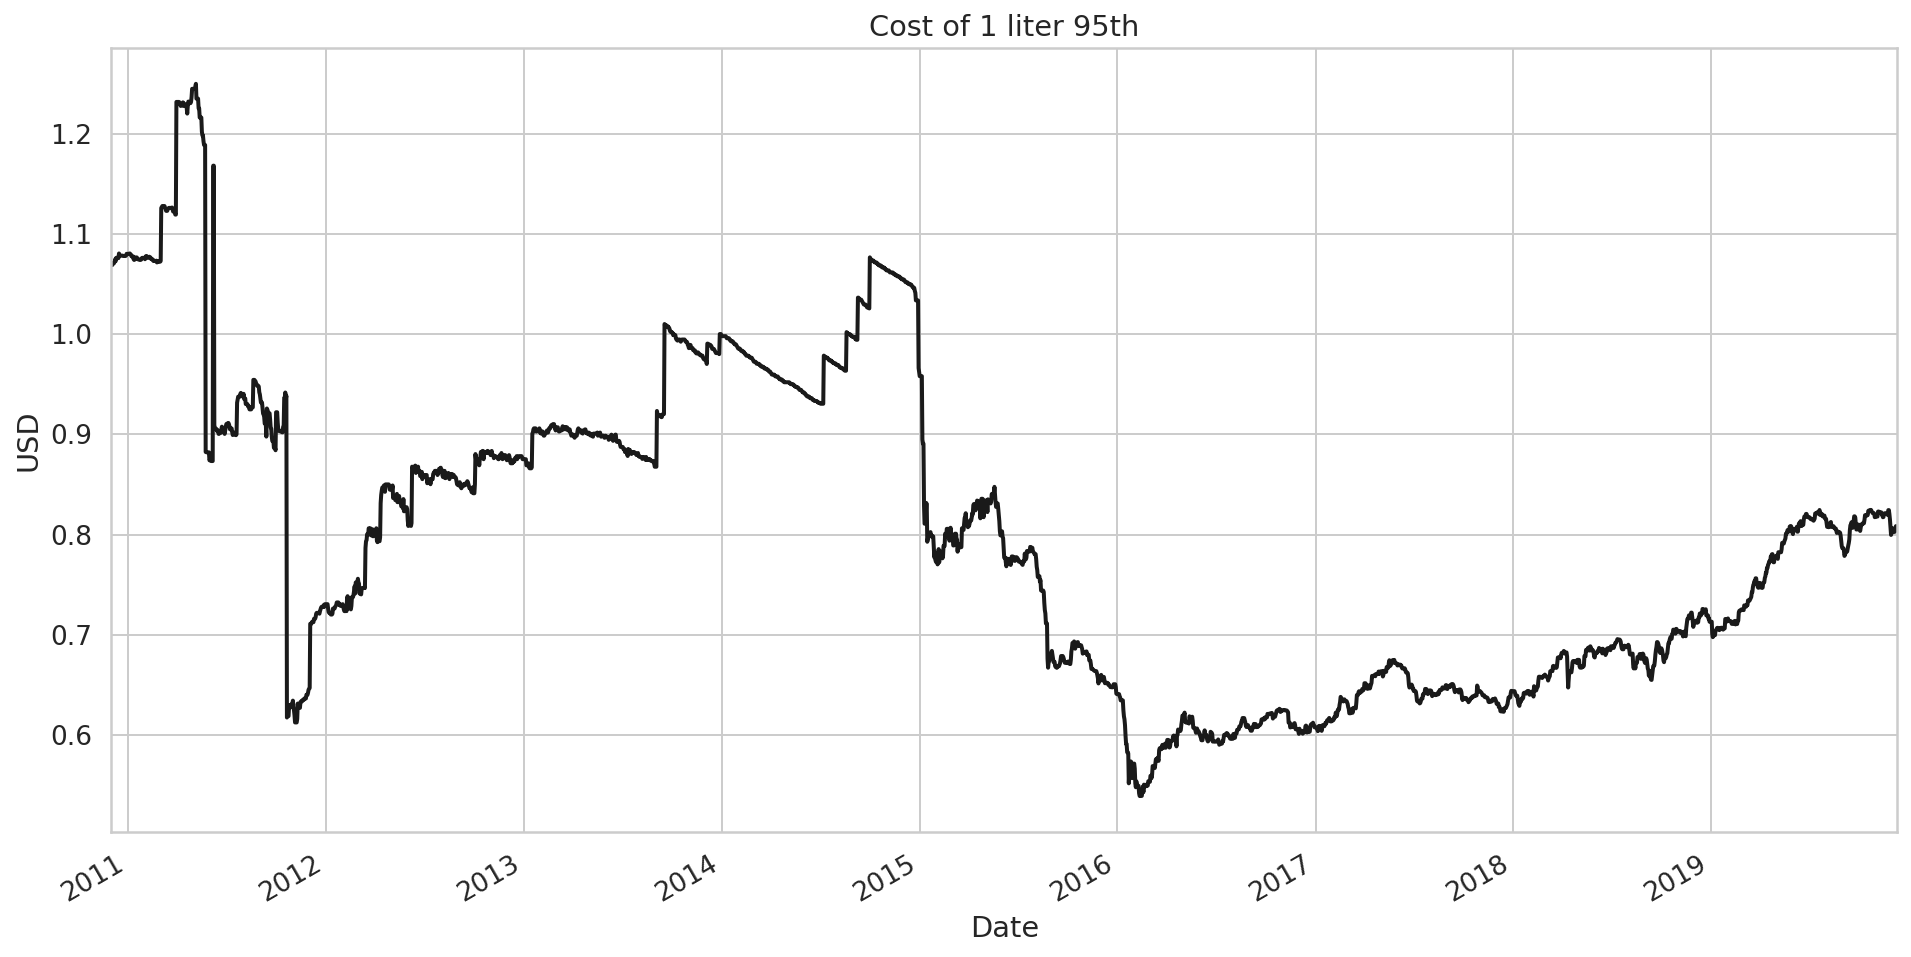

In [184]:
data['USD_by_liter'].plot(c = 'k', linewidth = 2)

plt.title('Сost of 1 liter 95th')
plt.ylabel('USD');

In [180]:
# сравниваем цену в USD с нефтью

In [181]:
start = '2010-12-01'
end = '2019-12-10'
brent = web.DataReader('DCOILBRENTEU', 'fred', start=start, end=end)
data['Brent'] = brent

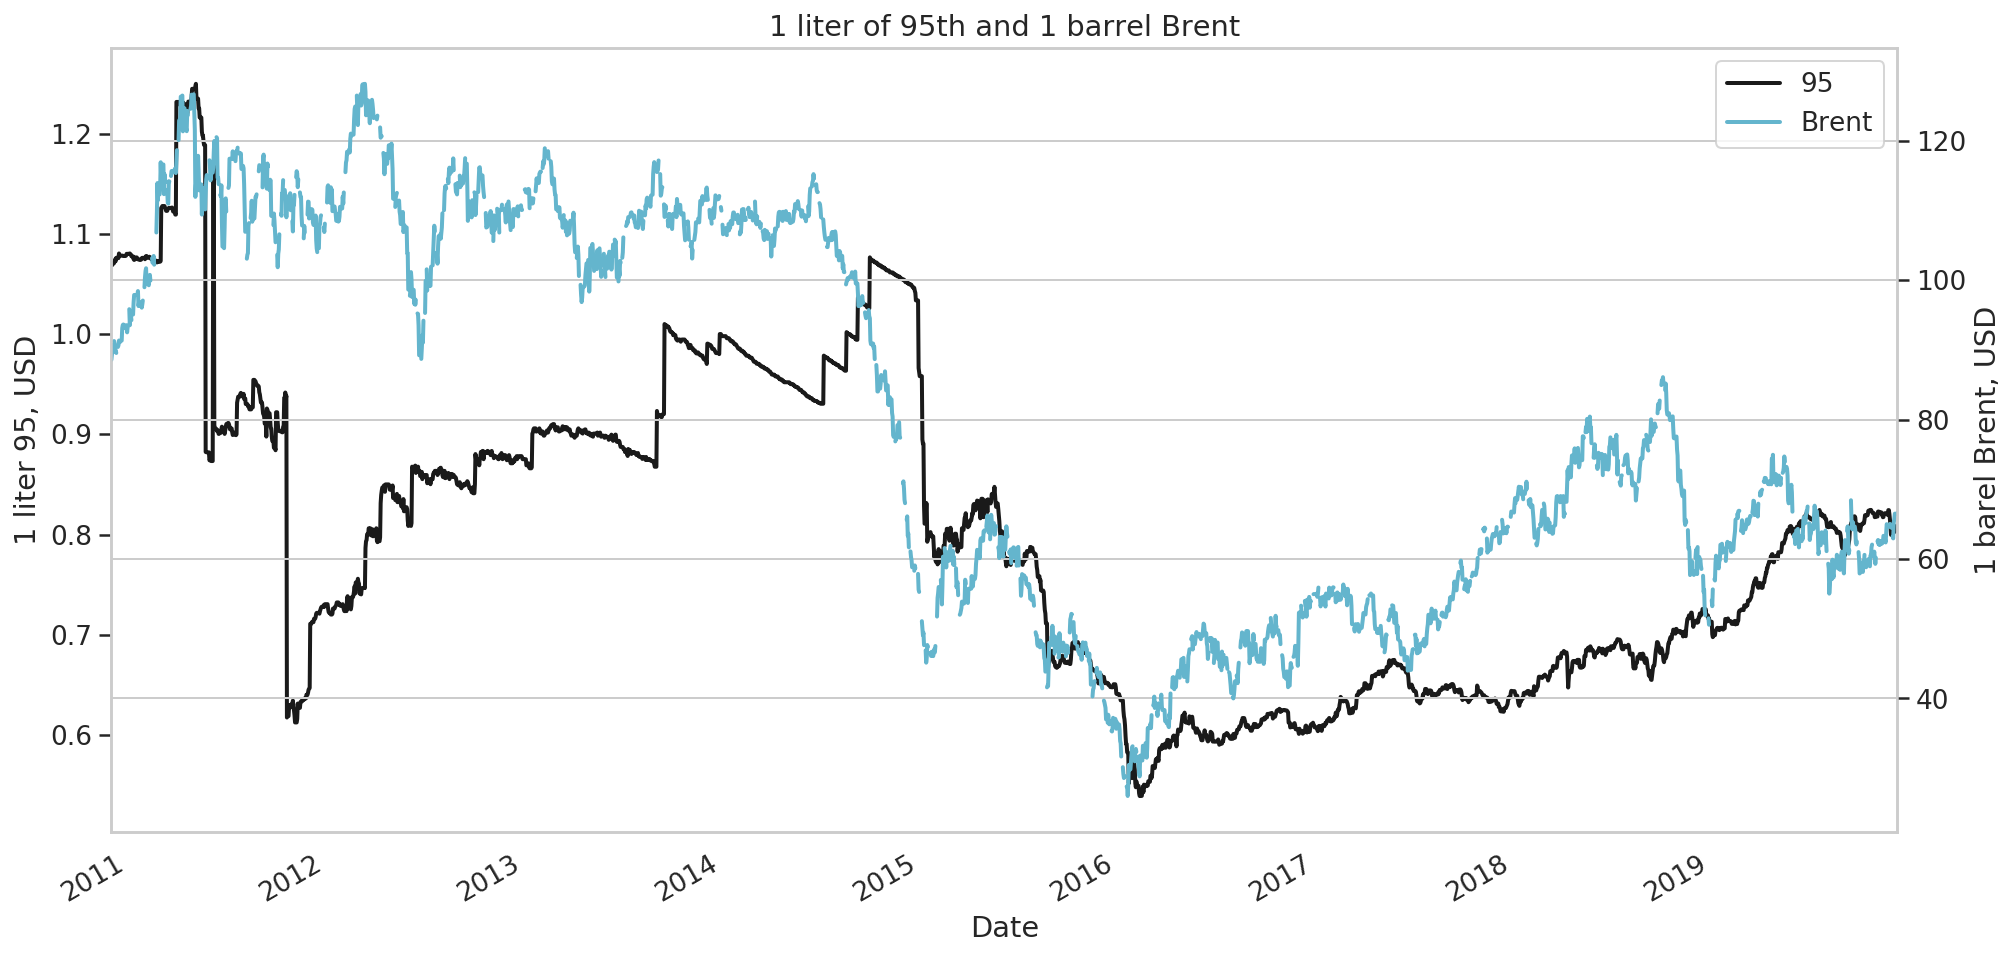

In [186]:
ax1 = data['USD_by_liter'].plot(c='k',linewidth = 2,label='95')
ax2 = data['Brent'].plot(c='c',linewidth = 2, secondary_y=True, label='Brent')

plt.title('1 liter of 95th and 1 barrel Brent')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_ylabel('1 liter 95, USD')
ax2.set_ylabel('1 barel Brent, USD')
plt.legend(h1+h2, l1+l2, loc=1)

plt.show()

In [92]:
# сравниваем цену в BYN с курсом BYN к USD

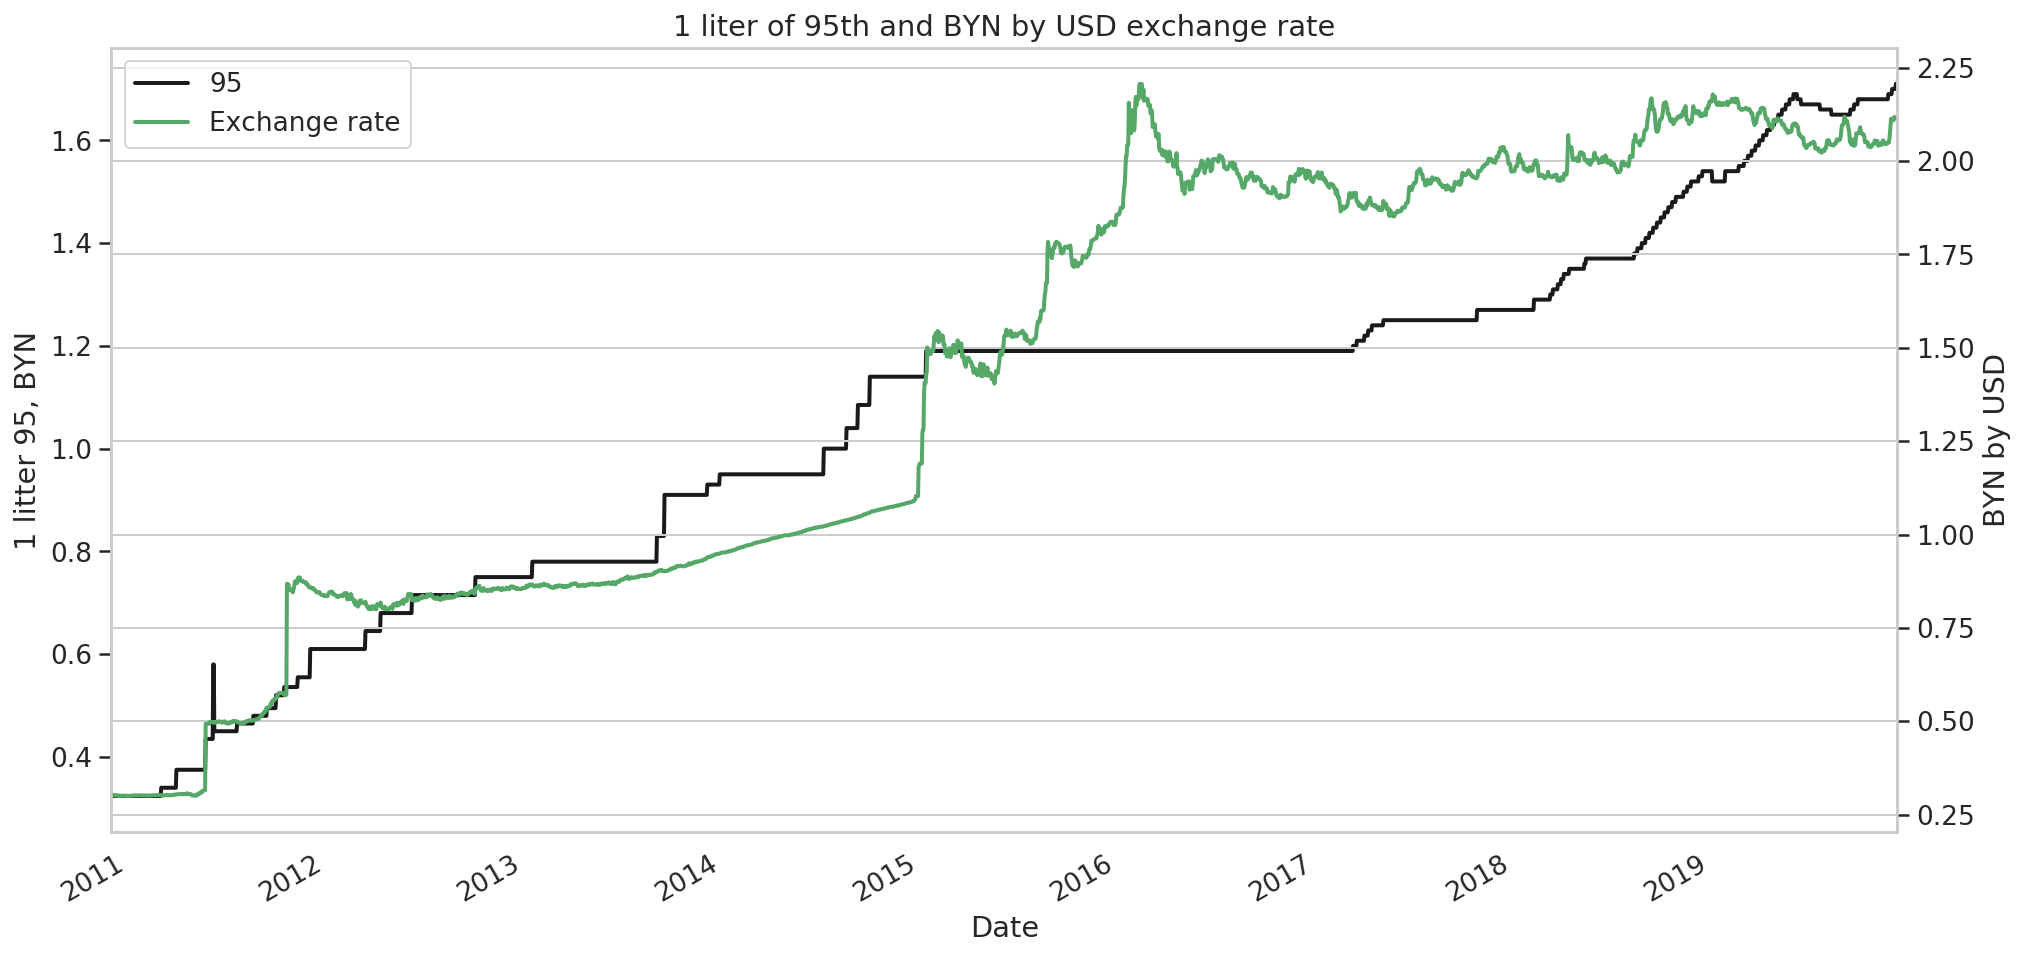

In [187]:
ax1 = data['BYN_by_liter'].plot(c='k',linewidth = 2, label='95')
ax2 = data['BYN_by_USD'].plot(c='g', linewidth = 2, secondary_y=True, label='Exchange rate')

plt.title('1 liter of 95th and BYN by USD exchange rate')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_ylabel('1 litter 95, BYN')
ax2.set_ylabel('BYN by USD')
plt.legend(h1+h2, l1+l2, loc=2)

plt.show()

In [106]:
# корреляции

In [107]:
corr_USD_Brent = (data['USD_by_liter']).corr(data['Brent'])
"Correlation USD by liter vs Brent is {:.3}".format(corr_USD_Brent)

'Correlation USD by liter vs Brent is 0.717'

In [108]:
corr_BYN_by_liter_and_USD = (data['BYN_by_liter']).corr(data['BYN_by_USD'])
"Correlation BYN by liter vs BYN by USD is {:.3}".format(corr_BYN_by_liter_and_USD)

'Correlation BYN by liter vs BYN by USD is 0.926'

In [109]:
# корреляции изменений процентов будущих значений рядов

In [120]:
corr_USD_Brent = (data['USD_by_liter'].pct_change()).corr(data['Brent'].pct_change())
"Correlation USD by liter vs Brent is {:.3}".format(corr_USD_Brent)

'Correlation USD by liter vs Brent is -0.0434'

In [121]:
corr_BYN_by_liter_and_USD = (data['BYN_by_liter'].pct_change()).corr(data['BYN_by_USD'].pct_change())
"Correlation BYN by liter vs BYN by USD change future % is {:.3}".format(corr_BYN_by_liter_and_USD)

'Correlation BYN by liter vs BYN by USD change future % is 0.221'

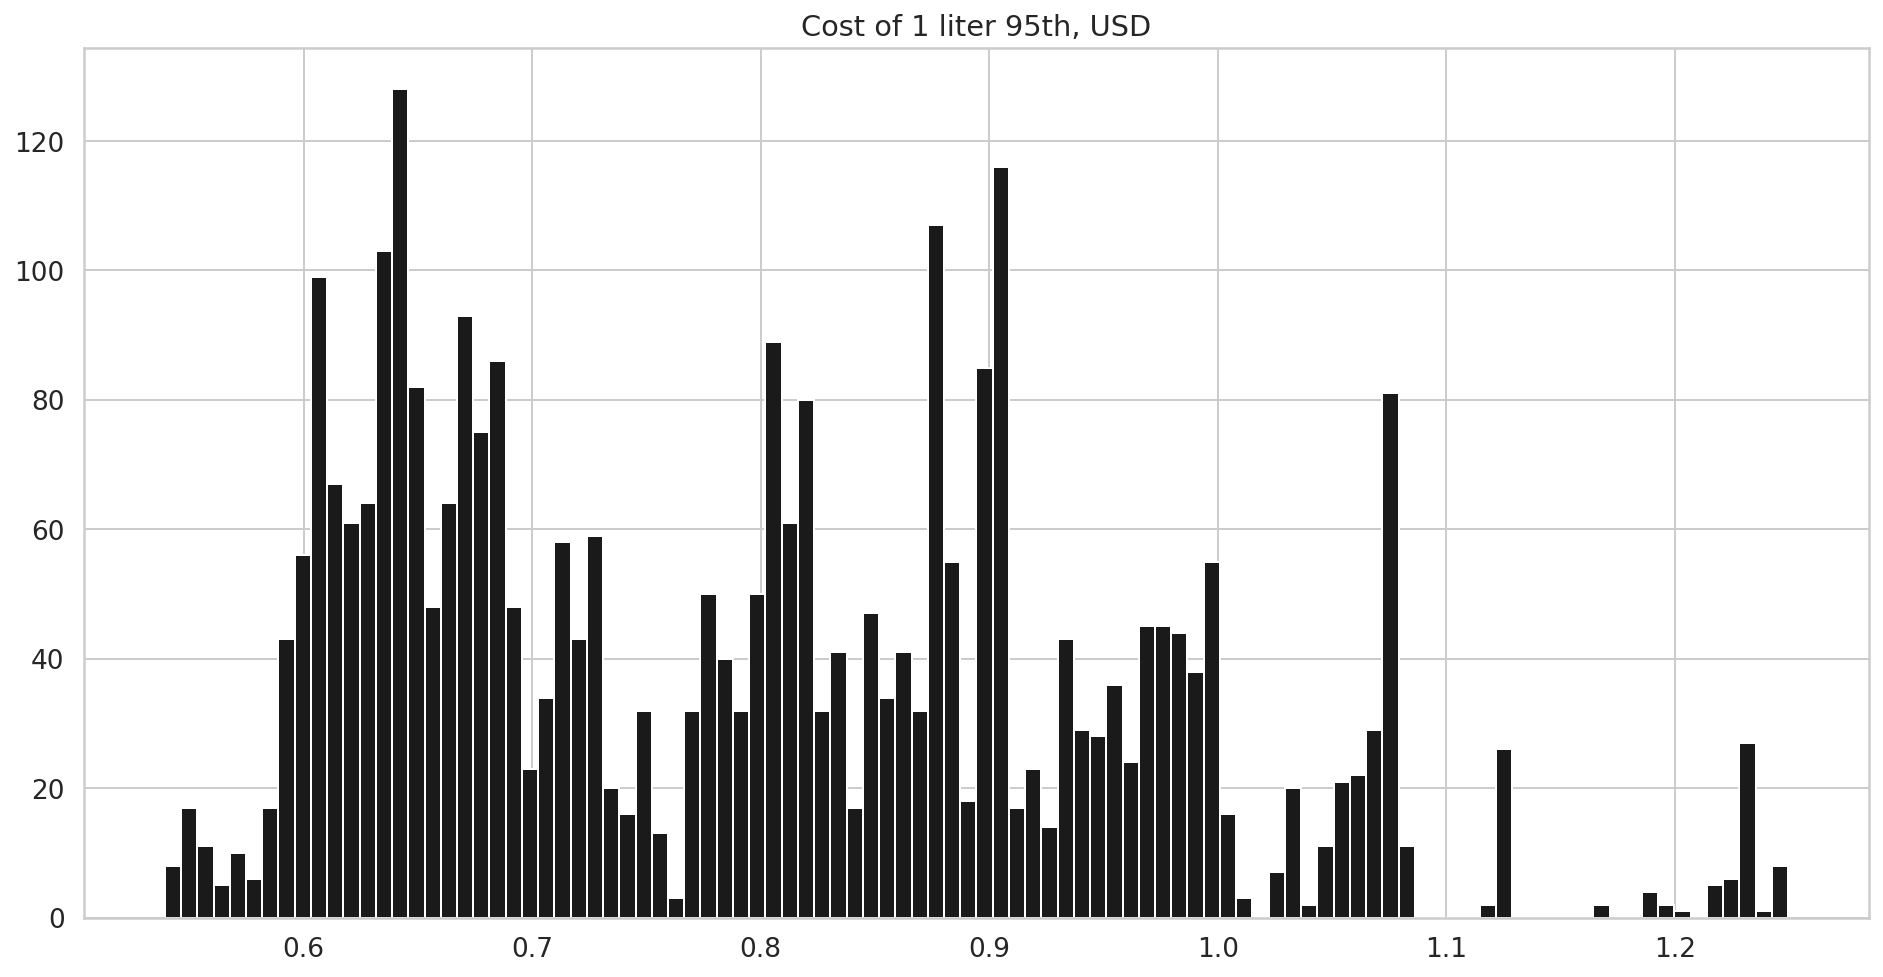

In [197]:
data['USD_by_liter'].hist(color ='k', bins = 100)

plt.title('Сost of 1 liter 95th, USD');

In [123]:
desc =  data['USD_by_liter'].describe()
print(desc)

count    3299.000000
mean        0.797893
std         0.153997
min         0.539218
25%         0.659845
50%         0.795455
75%         0.903091
max         1.249583
Name: USD_by_liter, dtype: float64


In [124]:
# Коэффициент вариации V = std/mean

In [125]:
V = desc['std']/desc['mean']
print('V =', V.round(4)) 

V = 0.193


In [126]:
# V между 0.1 и 0.2 => выборка вариабельна средне

In [127]:
# Тест Харки-Бера (определение нормальности распределения)
# — это статистический тест, проверяющий ошибки наблюдений на нормальность 
# посредством сверки асимметрии и эксцесса с моментами нормального распределения, где
# H0 S=0, K=3

In [128]:
JB = sm.stats.stattools.jarque_bera(data['USD_by_liter'])

In [129]:
print('JB = ', JB[0], '\np-value = ', JB[1], '\nskew = ', JB[2], '\nkurtosis = ', JB[3])

JB =  176.26995821296262 
p-value =  5.29011254285914e-39 
skew =  0.5129358044737989 
kurtosis =  2.520480067249251


In [130]:
# распределение не нормальное

In [131]:
# Автокорреляция

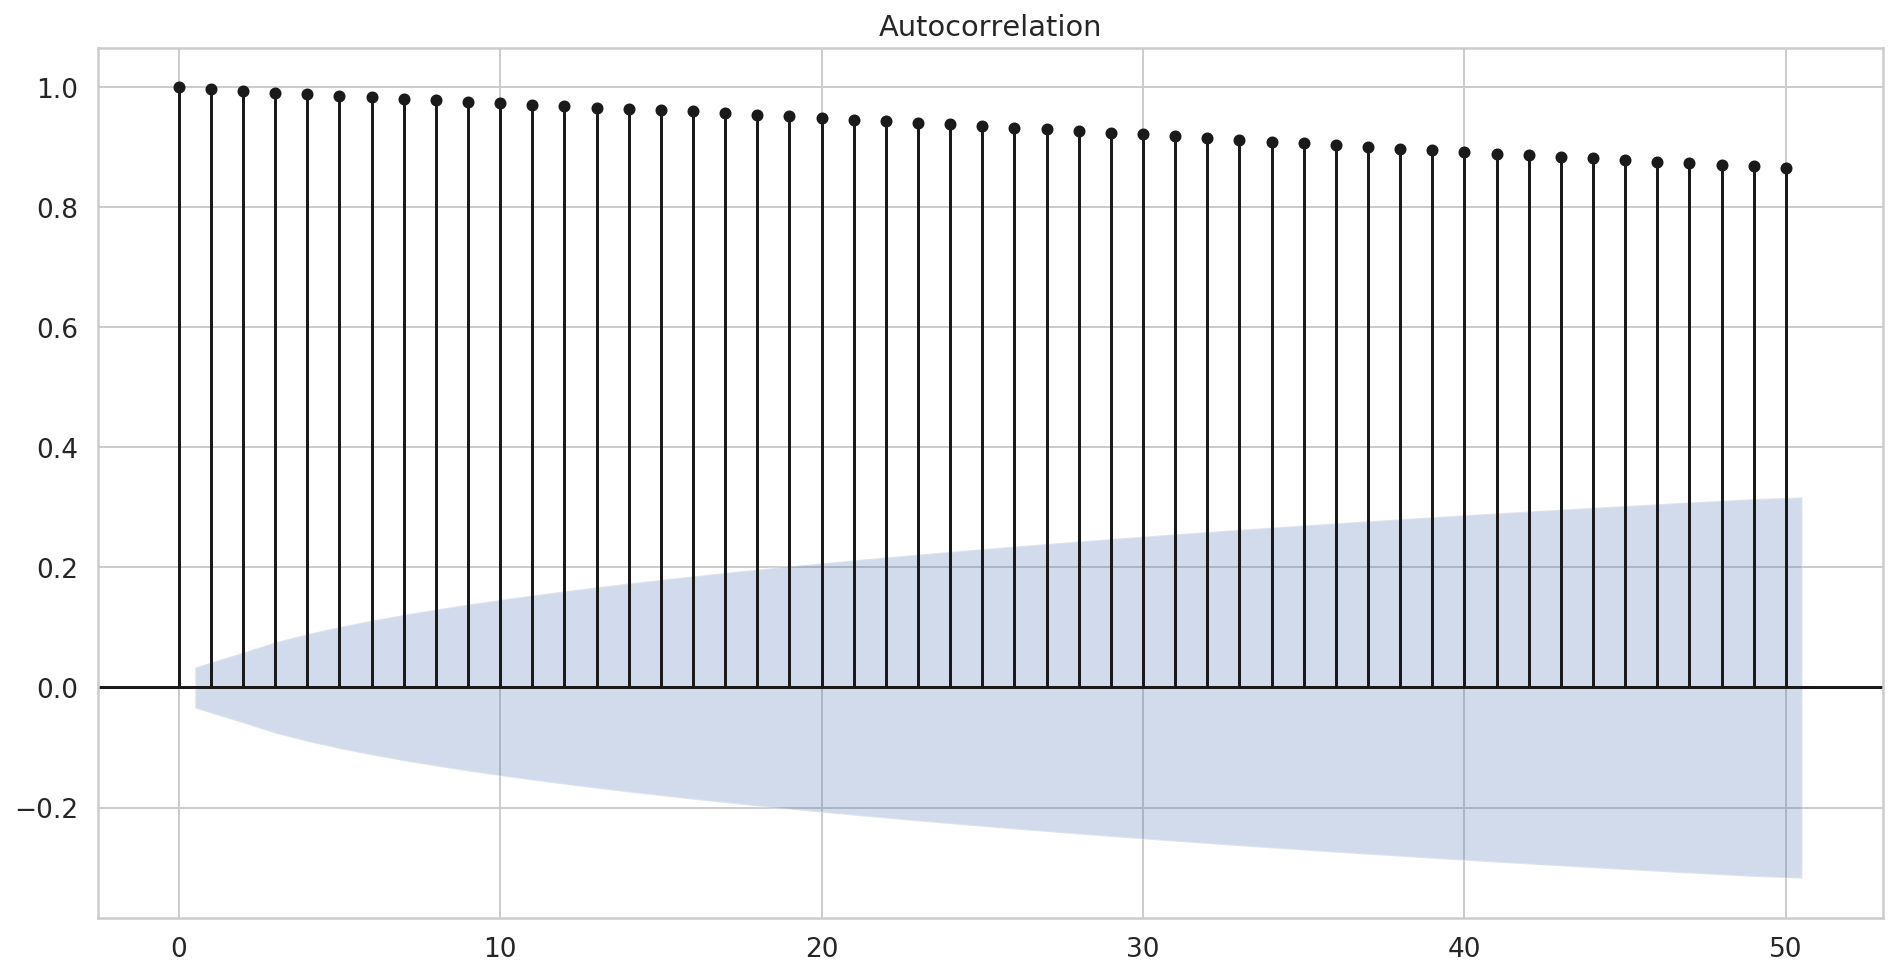

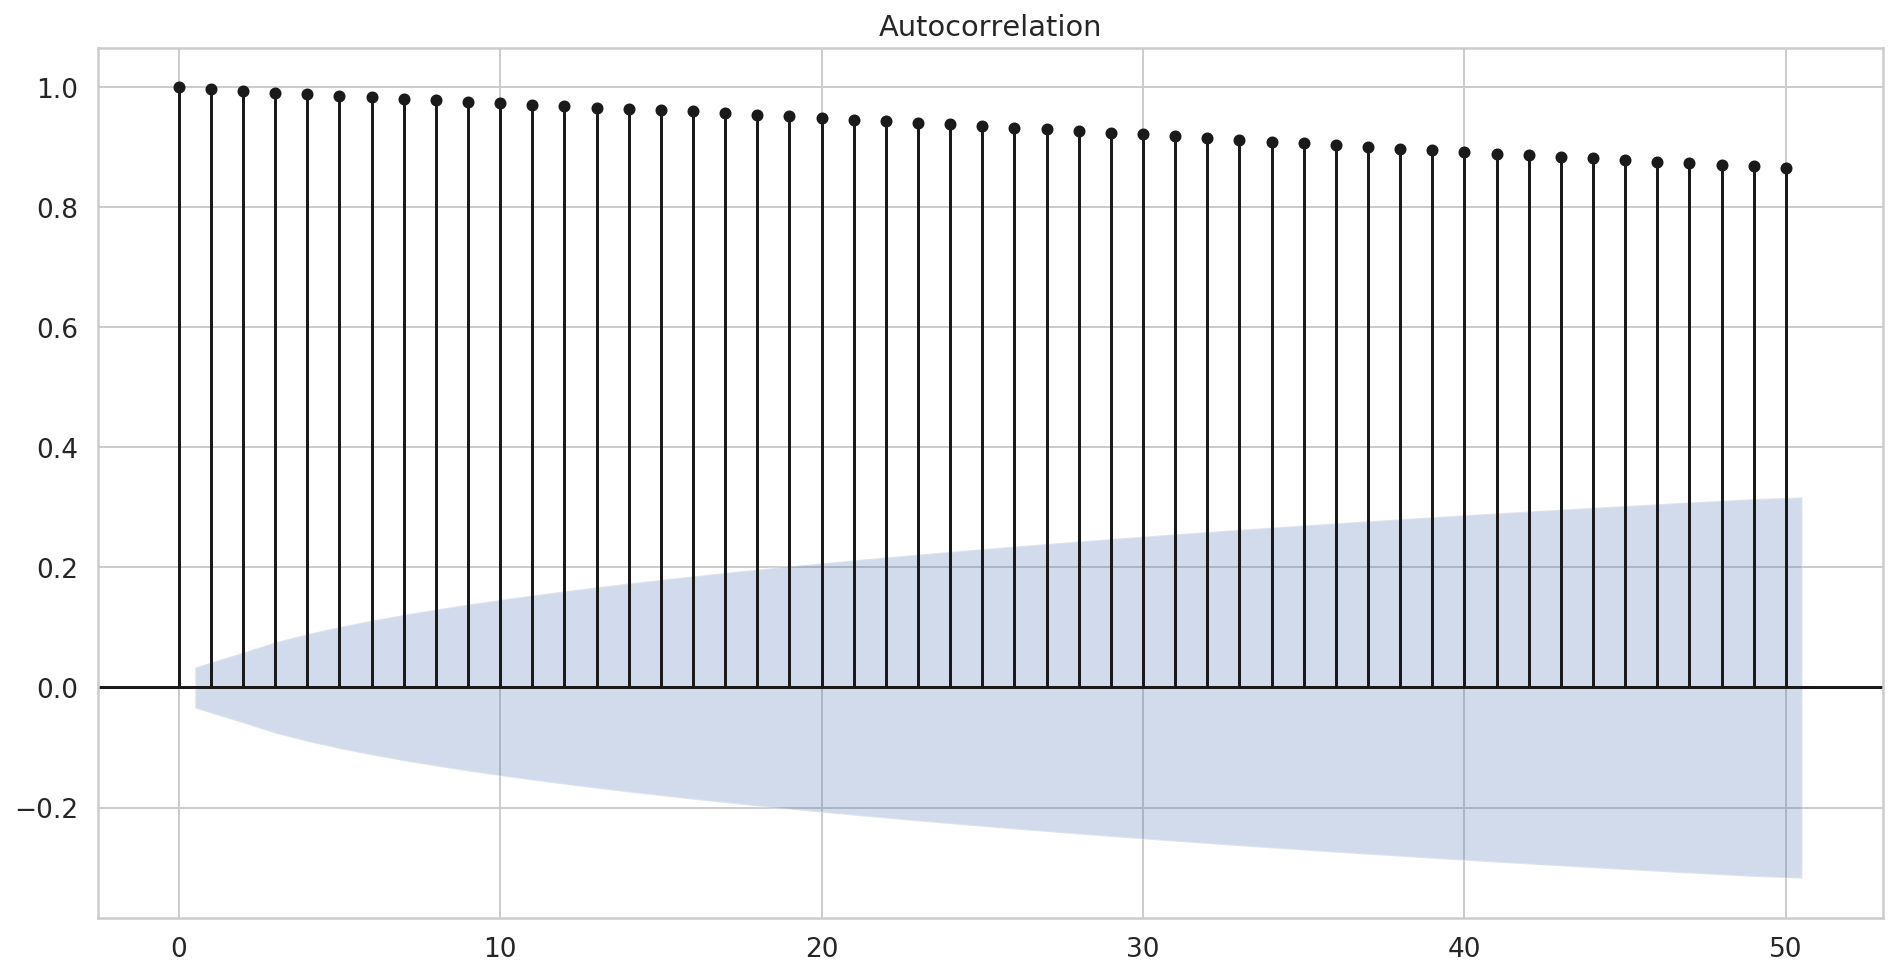

In [200]:
plot_acf(data['USD_by_liter'], color = 'k', lags = 50)

In [137]:
# Частичная автокорреляция

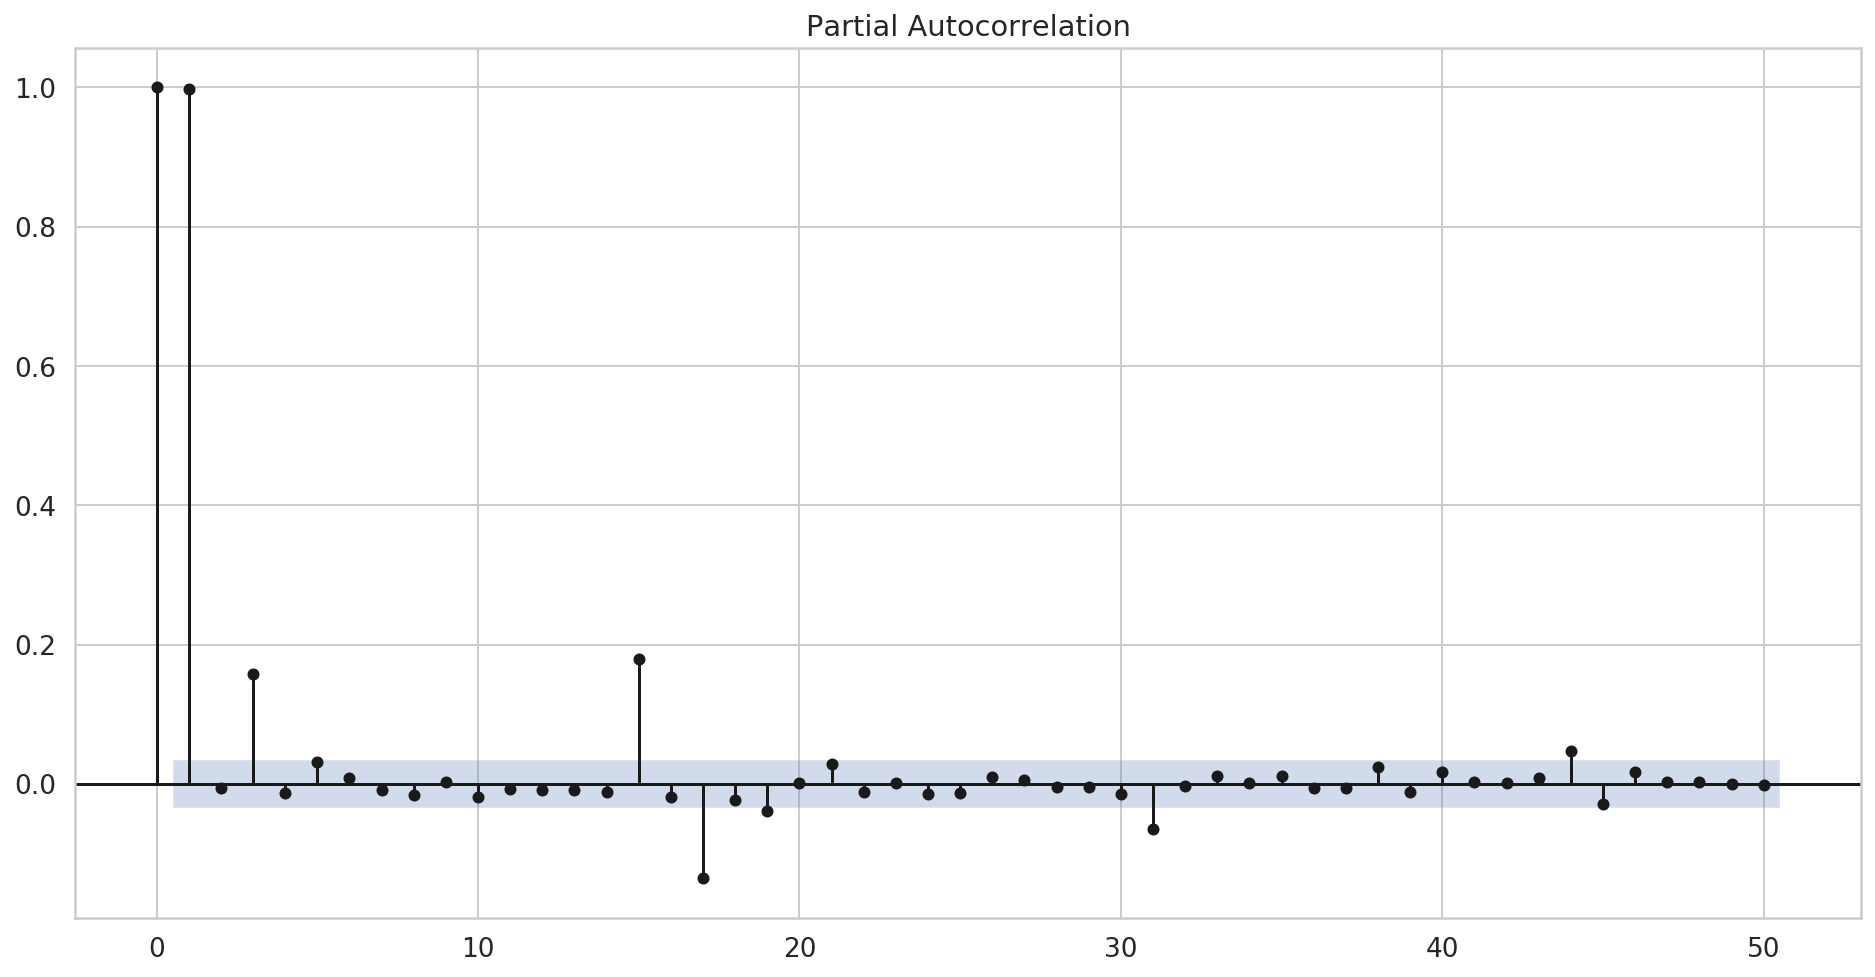

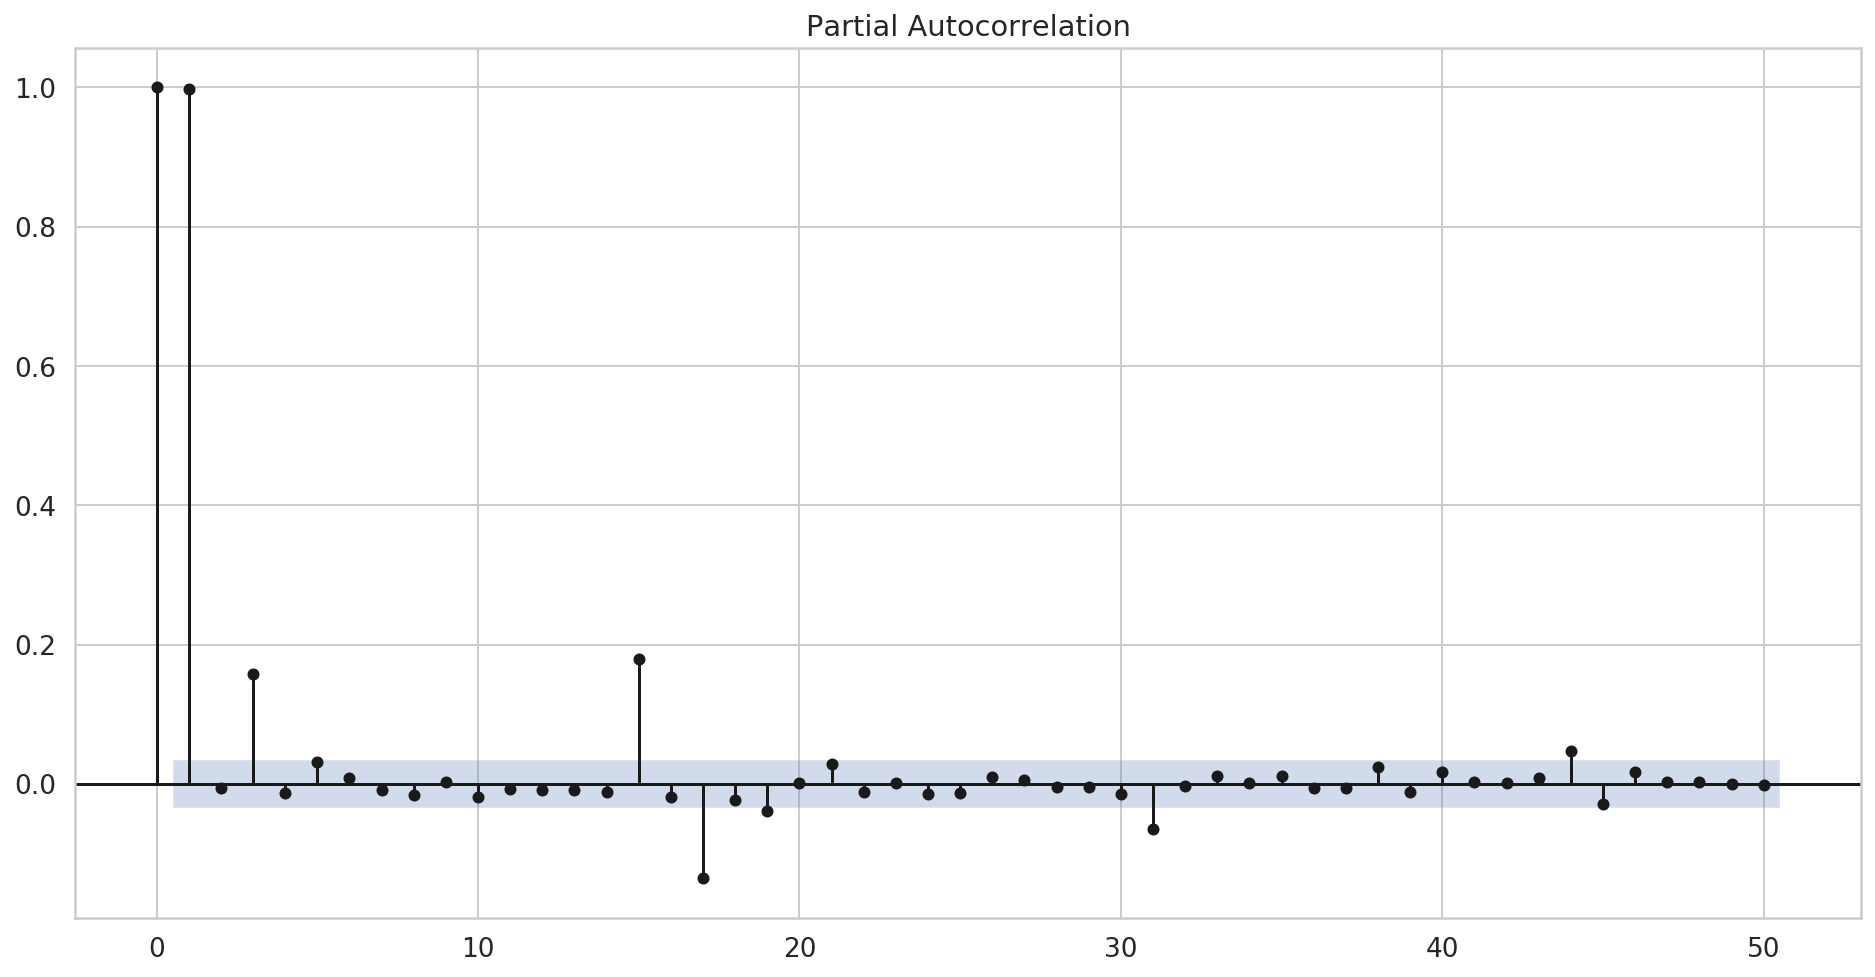

In [198]:
plot_pacf(data['USD_by_liter'], color ='k', lags = 50)

In [139]:
# Автокорреляция для ряда первой разницы

In [140]:
diff_1 = data['USD_by_liter'].diff(periods=1).dropna()

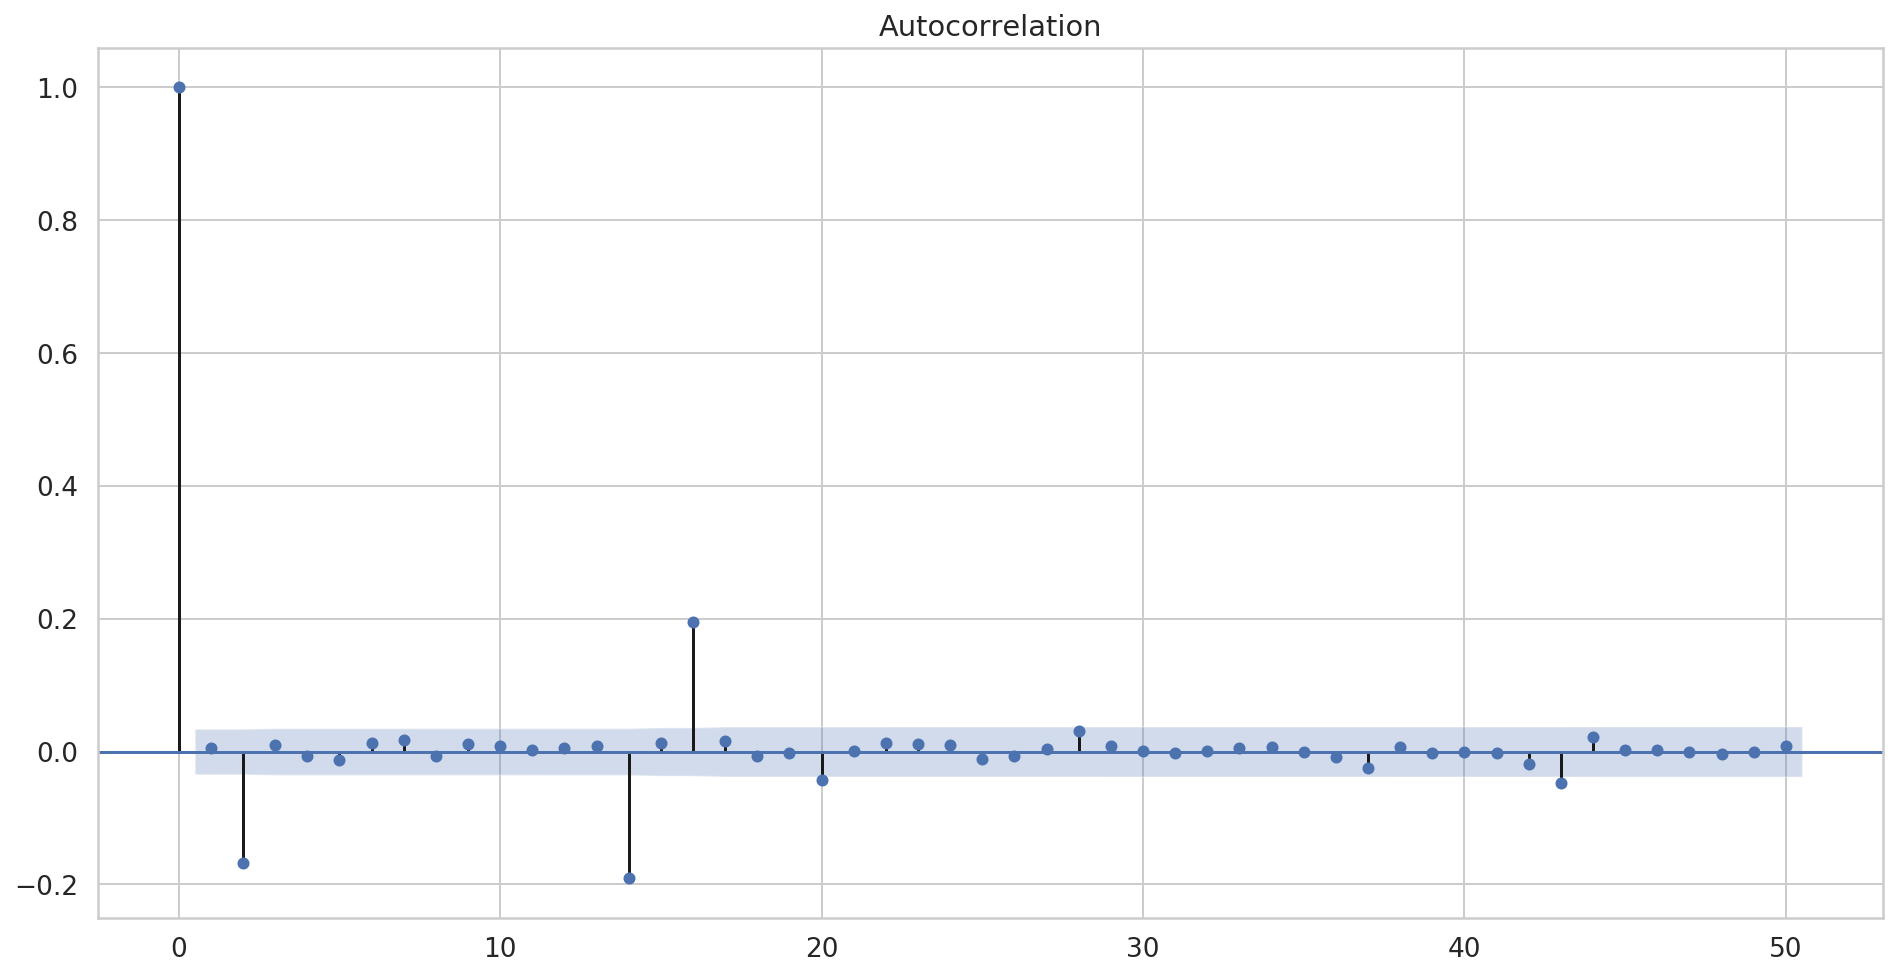

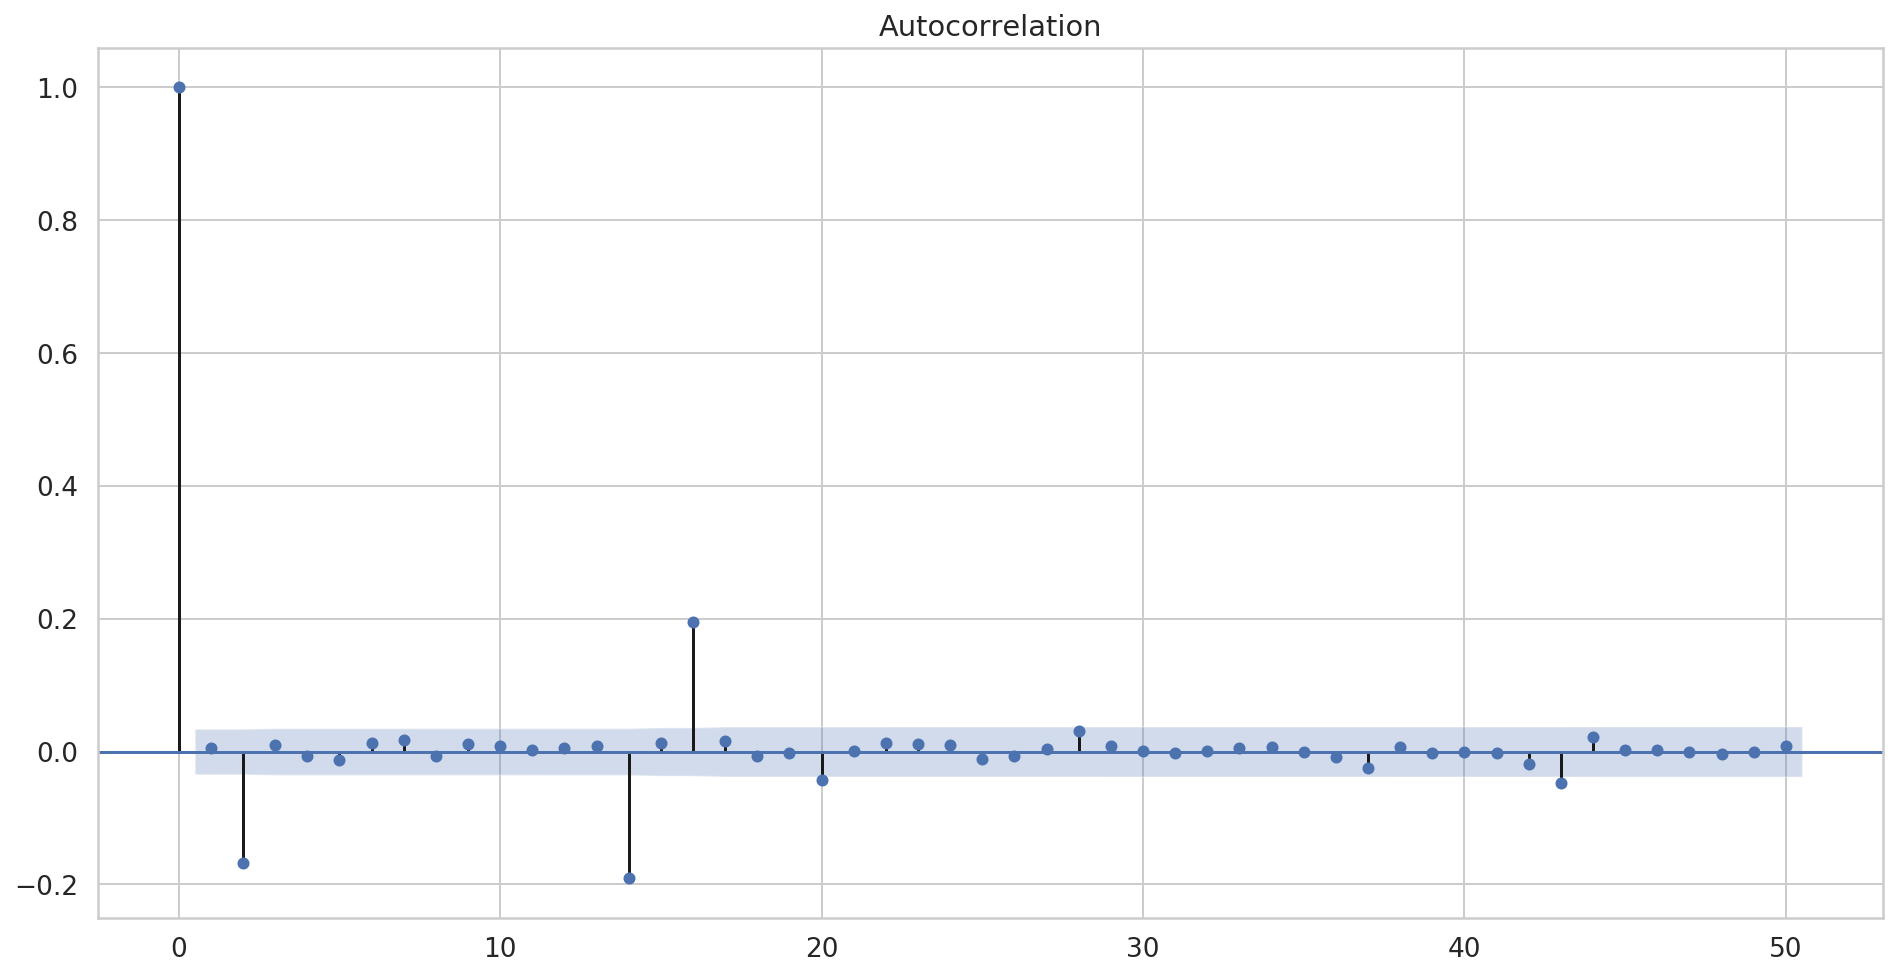

In [237]:
plot_acf(diff_1, color = 'b', lags = 50)

In [142]:
# Частичная автокорреляция для ряда первой разницы

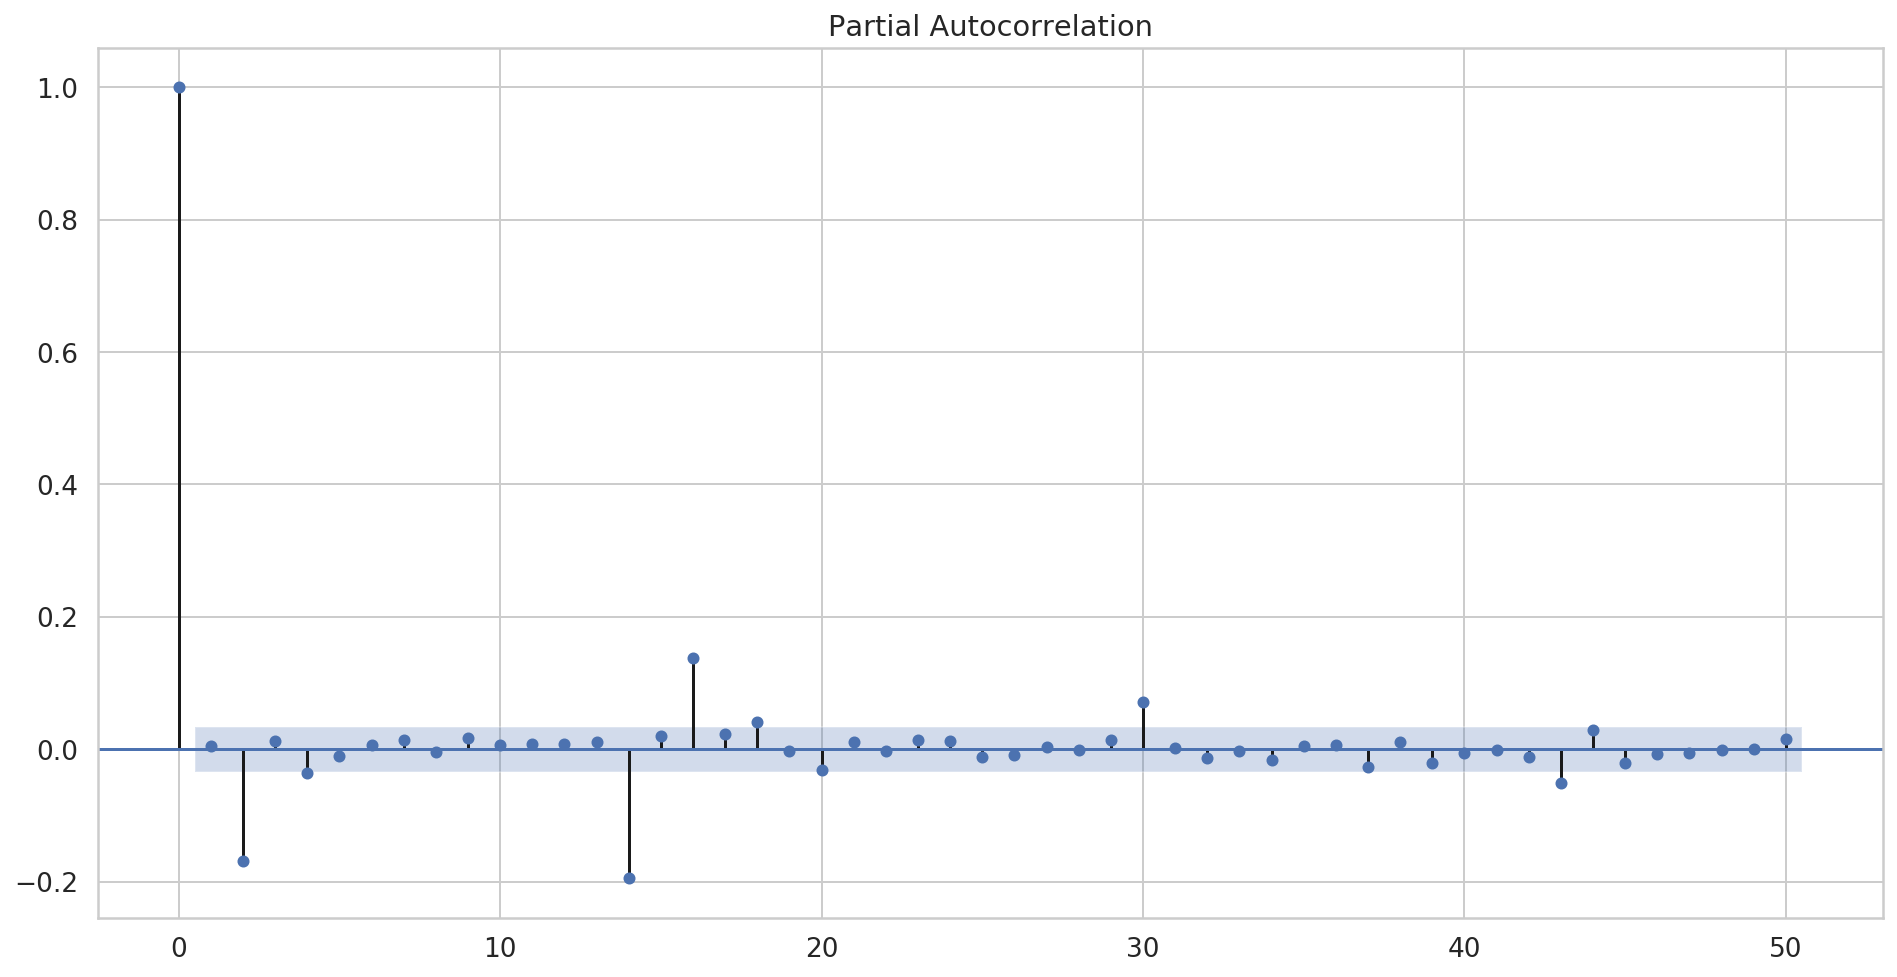

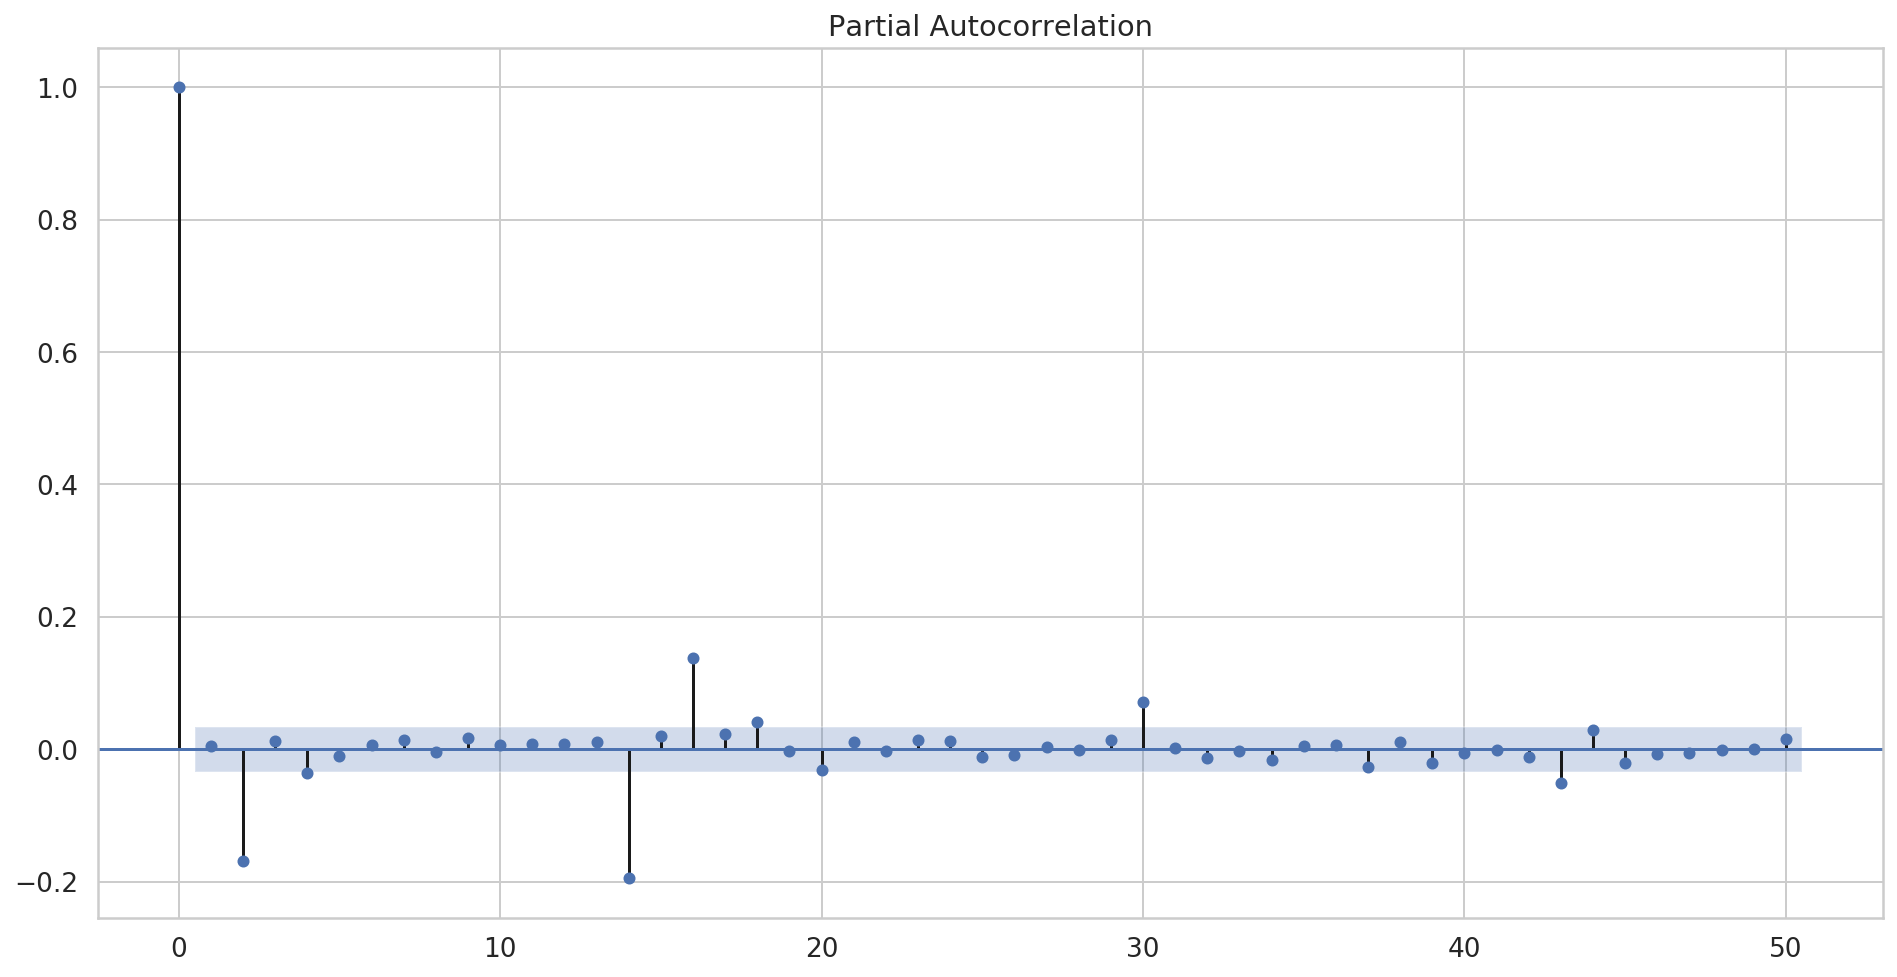

In [238]:
plot_pacf(diff_1, color = 'b', lags = 50)

In [144]:
#Q=0, q=16, P=0, p=16

In [145]:
# Стационарность
# тк ряд имеет тренд, он не стационарен

In [146]:
# Обобщенный тест Дикки-Фуллера  (определение стационарности ряда)
# H0 - ряд не стационарен

In [147]:
ADF = sm.tsa.adfuller(data['USD_by_liter'])

In [148]:
print('ADF = ',             ADF[0], 
'\np-value = ',             ADF[1], 
'\nCritical values 10% = ', ADF[4]['10%'],
'\nCritical values 5% = ',  ADF[4]['5%'])

ADF =  -2.3973737794559438 
p-value =  0.14247901243050803 
Critical values 10% =  -2.5672392854885486 
Critical values 5% =  -2.862421583712013


In [149]:
# тк ADF > Critical values 5% , есть единичные корни и ряд не стационарен

In [150]:
ADF_diff_1 = sm.tsa.adfuller(diff_1)

In [151]:
print('ADF_diff_1 = ',           ADF_diff_1[0],
      '\np-value = ',            ADF_diff_1[1],
      '\nCritical values 5% = ', ADF_diff_1[4]['5%'],
      '\nCritical values 1% = ', ADF_diff_1[4]['1%'])

ADF_diff_1 =  -12.625377550241804 
p-value =  1.5457749842659762e-23 
Critical values 5% =  -2.862421583712013 
Critical values 1% =  -3.4323452515445956


In [152]:
# тк ADF diff_1 < Critical values 1% , единичные корни отсутствуют и ряд diff_1 - стационарен

In [153]:
mean = int(len(diff_1)/2)
r1 = sm.stats.DescrStatsW(diff_1[mean:])
r2 = sm.stats.DescrStatsW(diff_1[:mean])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.6280168064935716


In [55]:
# Нулевая гипотеза о равенстве средних верна, ряд стационарен

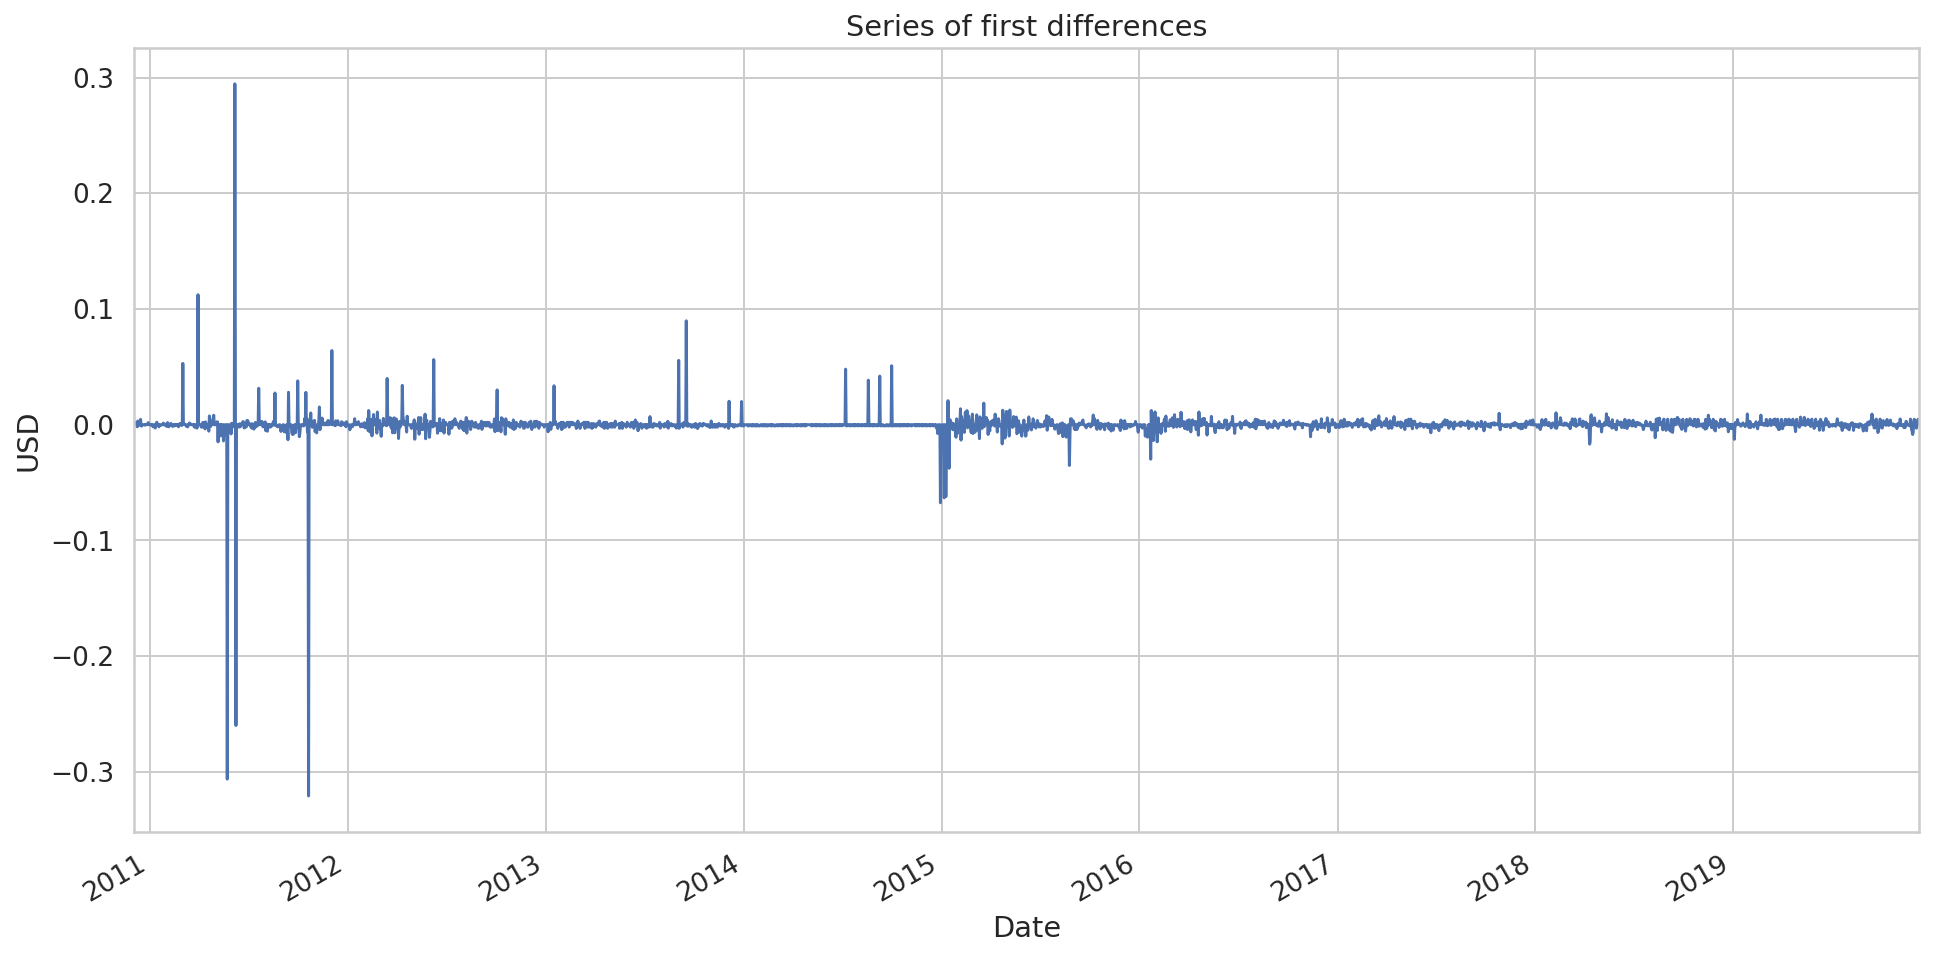

In [259]:
diff_1.plot(c='b')
plt.title('Series of first differences')
plt.ylabel('USD');

In [202]:
# тренд отсутствует
# Исходный ряд - интегрированный ряд 1-го порядка

In [203]:
#ARIMA

In [204]:
#AR(p) (авторегрессионная составляющая)

\begin{array}\\
y_t = \alpha + \phi_1y_{t-1} + \phi_2y_{t-2} + \phi_3y_{t-3} + ...+ \phi_py_{t-p} + \varepsilon_t\\
y_t\quad-\quadпредсказание\\
\alpha\quad-\quadконстанта\\
\phi_1..\phi_p - постоянные\quadкоэффициенты\\
\varepsilon_t\quad-\quadгаусов\quadбелый\quadшум\\
p\quad-\quadпорядок\quadавторегрессии\quad(длина\quadэл-тов\quadв\quadлинейной\quadкомбинации)
\end{array}

In [205]:
#MA(q) (состовляющая скользящего среднего) - авторегрессия на шум

\begin{array}\\
y_t = \alpha + \Theta_1\varepsilon_{t-1} + \Theta_2\varepsilon_{t-2} + \Theta_3\varepsilon_{t-3} +...+ \Theta_q\varepsilon_{t-q} + \varepsilon_t\\
y_t\quad-\quadпредсказание\\
\alpha\quad-\quadконстанта\\
\Theta_1..\Theta_q\quad-\quadпостоянные\quadкоэффициенты\\
\varepsilon_t..\varepsilon_{t-q}\quad-\quadгаусов\quadбелый\quadшум\\
q\quad-\quadпорядок\quadскользящего\quadсреднего\quad(длина\quadэл-тов\quadв\quadлинейной\quadкомбинации)
\end{array}

In [206]:
# Теорема Водьда: любой стационарный ряд может быть описан моделью ARMA(p,q) c любой заданной наперед точностью

In [207]:
# Ряд описывается ARIMA(p,d,q), если d раз продифференциированный ряд описывается ARMA(p,q)

In [208]:
# train test split
train_data = data['USD_by_liter'][:'2018-01-01']
test_data = data['USD_by_liter']['2018-01-01':]

\begin{array}\\
r2_{score}\quad -\quadдоля\quadдиссперсии\quadзависимой\quadпеременной\\
r2_{score} = 1 - \frac{D_{y|x}}{D_y}\\
rmse\quad-\quadкорень\quadиз\quadсреднеквадратичной\quadошибки\\
rsme = \sqrt{\sum_{i=1}^n (y_i-\bar{y_i})^2}\\
mae\quad-\quad cредняя\quadабсолютная\quadошибкa\\
mae = \frac{1}{T} \sum_{t=1}^T  |y_t-\bar{y_t}|
\end{array}

\begin{array}\\
Для\quadподбора \quad p, P, q, Q\quadможно\quadиспользовать\quadкритерий\quadАкаике:\\
AIC = -2logL+2k\\
k = p + P + q + Q + 1\\
L\quad-\quadправдоподобие\\
Чем\quad AIC \quadменьше,\quadтем\quadлучше\\
\end{array}

In [344]:
def describe_prediction(full_data, test_data, pred_data):
    
    r2 = r2_score(test_data, pred_data)
    rmse = metrics.rmse(test_data, pred_data)
    mae = metrics.mae(test_data,pred_data)
    print(' r2: %1.2f \n rmse: %1.2f \n mae: %1.2f' % (r2, rmse, mae))
    
    pd.plotting.register_matplotlib_converters()
    fig, ax = plt.subplots()
    
    ax.plot(full_data, c = 'k', linewidth = 2)
    ax.plot(pred_data, c = '#FF0000', linewidth = 2)
    
    ax.set_title('Сost of 1 liter 95th and prediction')
    ax.set_ylabel('USD')
    ax.set_xlabel('Date')
    ax.legend(['full_data', 'prediction_data'])

    return r2, rmse, mae

In [215]:
arima_1 = sm.tsa.ARIMA(train_data, order=(0,1,0)).fit()

/home/mneminic/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/mneminic/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [216]:
arima_1_pred = arima_1.forecast(steps=len(test_data))

In [217]:
arima_1_forecast = pd.DataFrame(index = pd.date_range(start='2018-01-01', end='2019-12-12', freq='d'),\
                          data = arima_1_pred[1] + data['USD_by_liter']['2018-01-01'])

 r2: -5.14 
 rmse: 0.18 
 mae: 0.15


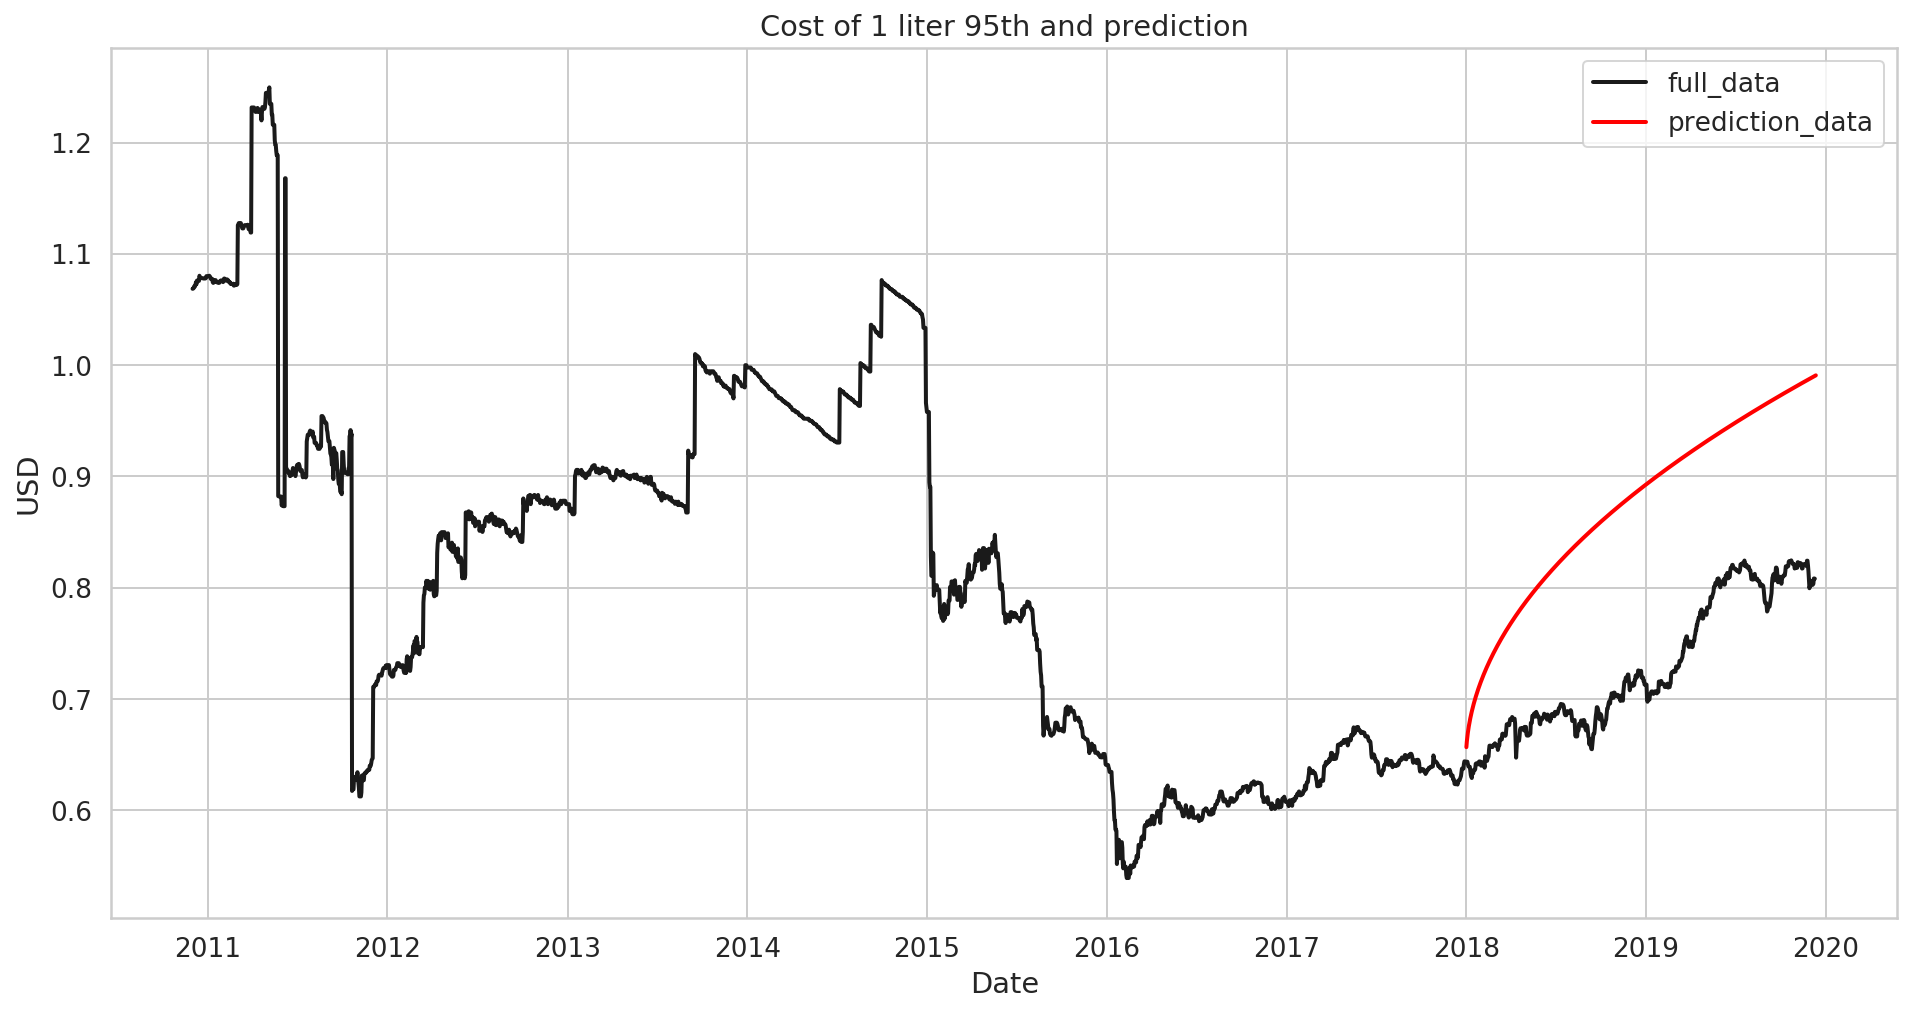

In [345]:
r2_arima_1, rmse_arima_1, mae_arima_1 = \
describe_prediction(\
                    data['USD_by_liter'],\
                    test_data,\
                    arima_1_forecast)

In [120]:
# Определили p, q в диапазоне 0-10
p = q = range(0, 10)
# Сгенерировали различные комбинации p и q
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]

In [121]:
warnings.filterwarnings("ignore")

parameters = []

for param in pdq:
    try:     
        mod = sm.tsa.ARIMA(train_data, order=param)
        results = mod.fit()
        predicrion = results.predict(start=pd.to_datetime('2018-01-01'), \
                                         end=pd.to_datetime('2019-12-12'), \
                                         dynamic=False)
        
        r2 = r2_score(test_data, predicrion)
        aic = results.aic
        parameters.append([param,aic,r2])      
    except:
        continue

In [123]:
result_table_arima = pd.DataFrame(parameters)
result_table_arima.columns = ['parameters','aic','r2']
result_table_arima = result_table_arima.sort_values(by='aic', ascending=True).reset_index(drop=True)

In [124]:
result_table_arima.head()

parameters           aic          r2
0  (8, 1, 9) -15279.617701 -144.539802
1  (8, 1, 8) -15278.232966 -144.539024
2  (8, 1, 7) -15273.956315 -144.539553
3  (9, 1, 7) -15272.284957 -144.540217
4  (9, 1, 8) -15271.245446 -144.540302

In [219]:
arima_2 = sm.tsa.ARIMA(train_data, order=(8,1,9)).fit()
arima_2_pred = arima_2.forecast(steps=len(test_data))
arima_2_forecast = pd.DataFrame(index = pd.date_range(start='2018-01-01', end='2019-12-12', freq='d'),\
                          data = arima_2_pred[1] + data['USD_by_liter']['2018-01-01'])

/home/mneminic/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/mneminic/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/mneminic/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 r2: -2.16 
 rmse: 0.14 
 mae: 0.12


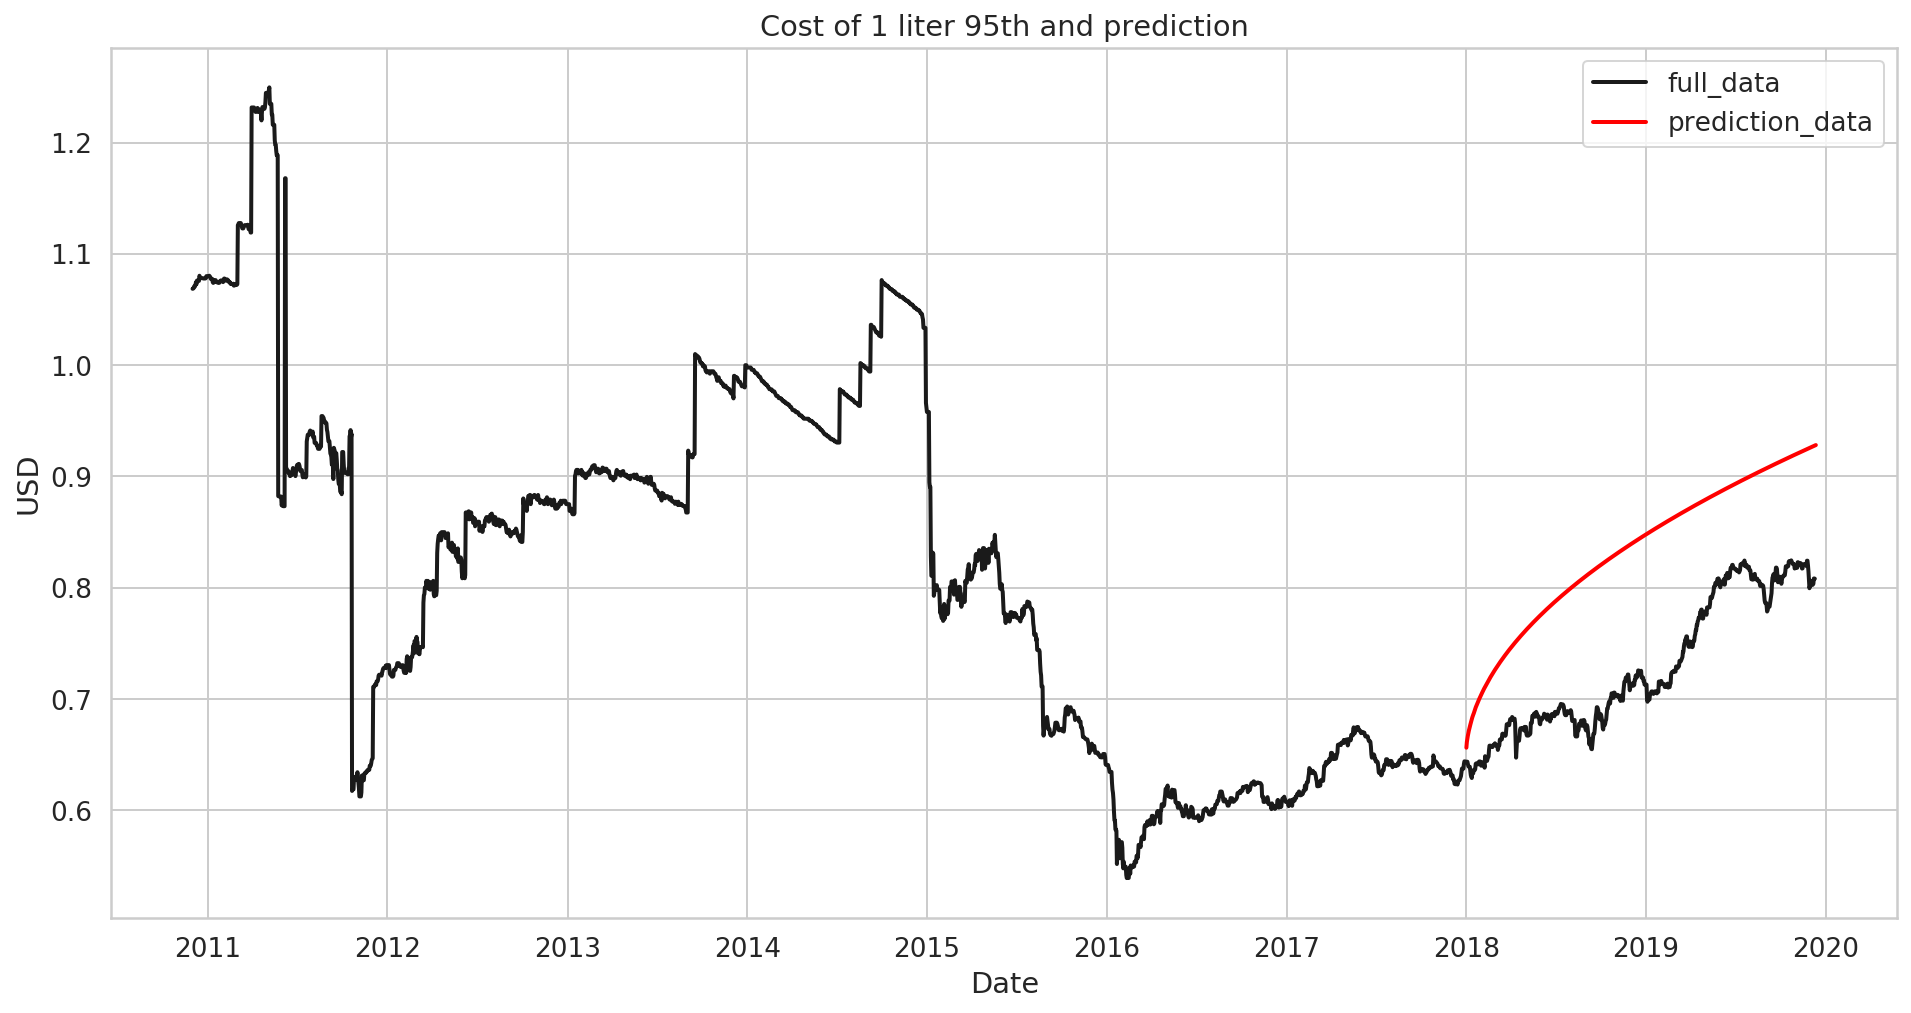

In [346]:
r2_arima_2, rmse_arima_2, mae_arima_2 = \
describe_prediction(\
                    data['USD_by_liter'],\
                    test_data,\
                    arima_2_forecast)

In [243]:
# SARIMAX

In [244]:
#Q=0, q=16, P=0, p=16

In [245]:
# Определили p, q в диапазоне 15-17
p = q = range(15, 17)
# Сгенерировали различные комбинации p и q
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]

In [246]:
# Сгенерировали комбинации сезонных параметров P, D, Q, X 
P = D = Q = range(0, 2)
X = range(12,36,12)
sesonal_PDQX = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(P,D,Q,X))]

In [247]:
len_of_iter = len(pdq)*len(sesonal_PDQX)

In [248]:
parameters = []
count = 0

warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in sesonal_PDQX:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data, order=param, seasonal_order=param_seasonal,\
                                                enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            predicrion = results.predict(start=pd.to_datetime('2018-01-01'), \
                                             end=pd.to_datetime('2019-12-12'), \
                                             dynamic=False)
            count = count + 1 

            r2 = r2_score(test_data, predicrion)
            aic = results.aic
            parameters.append([param, param_seasonal, aic, r2]) 
            print(count, 'from', len_of_iter, 'param: ', param, param_seasonal, 'aic: ', aic, 'r2: ', r2)
        except:
            continue

1 from 64 param:  (15, 1, 15) (0, 0, 0, 12) aic:  -15214.44076219974 r2:  -1.9961266676424887
2 from 64 param:  (15, 1, 15) (0, 0, 0, 24) aic:  -15214.44076219974 r2:  -1.9961266676424887
3 from 64 param:  (15, 1, 15) (0, 0, 1, 12) aic:  -15130.676853719535 r2:  -1.9756985165058105
4 from 64 param:  (15, 1, 15) (0, 0, 1, 24) aic:  -15046.64776877813 r2:  -1.9958958141300656
5 from 64 param:  (15, 1, 15) (0, 1, 0, 12) aic:  -15010.992723606572 r2:  0.8831937464171054
6 from 64 param:  (15, 1, 15) (0, 1, 0, 24) aic:  -13554.469140707843 r2:  -6.639702909199052
7 from 64 param:  (15, 1, 15) (0, 1, 1, 12) aic:  -14926.083245075342 r2:  -5.150678719448947
8 from 64 param:  (15, 1, 15) (0, 1, 1, 24) aic:  -14757.090514089603 r2:  -5.771488878774175
9 from 64 param:  (15, 1, 15) (1, 0, 0, 12) aic:  -15135.740418835458 r2:  -1.9931546566406633
10 from 64 param:  (15, 1, 15) (1, 0, 0, 24) aic:  -15052.63451840499 r2:  -1.998740838516016
11 from 64 param:  (15, 1, 15) (1, 0, 1, 12) aic:  -15125.

In [249]:
result_table = pd.DataFrame(parameters)
result_table.columns = ['pdq', 'PDQX','aic','r2']
result_table_aic = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
result_table_r2 = result_table.sort_values(by='r2', ascending=False).reset_index(drop=True)

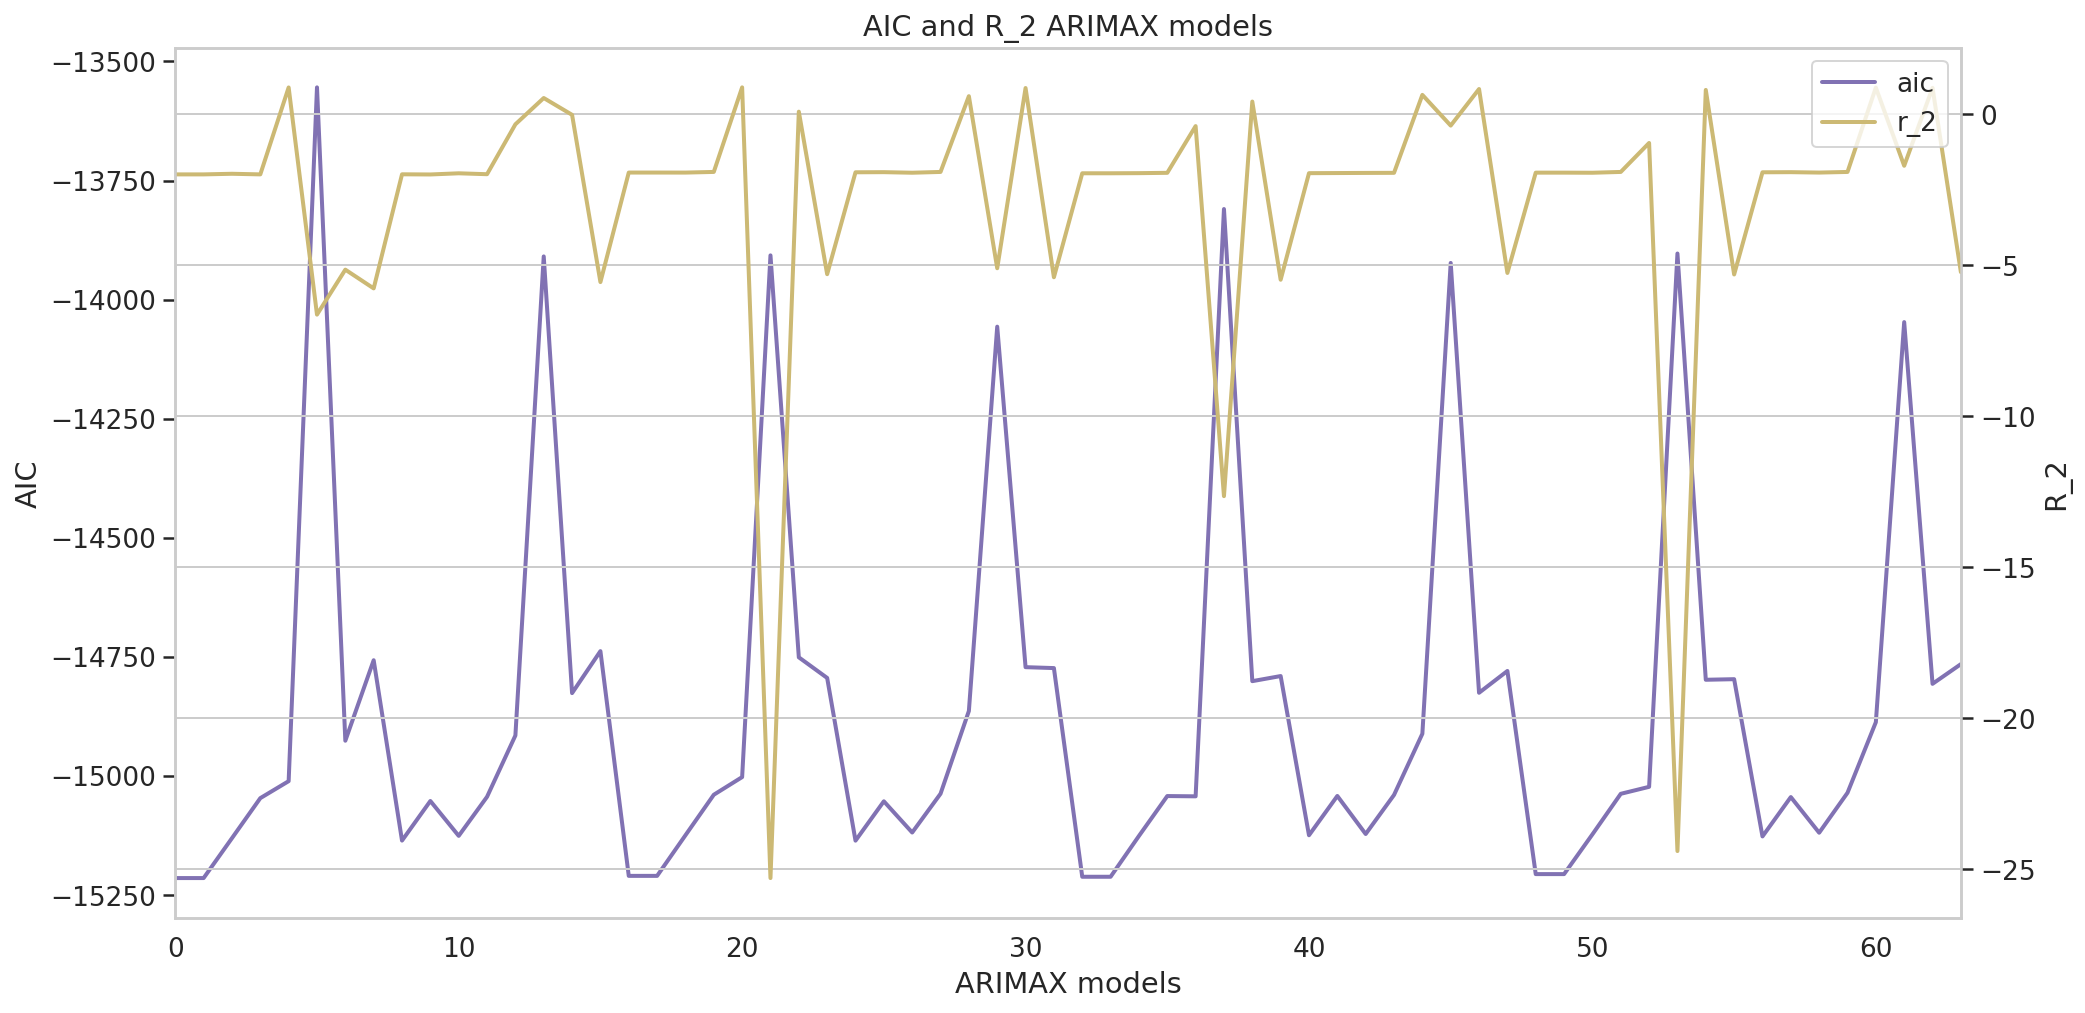

In [302]:
ax1 = result_table['aic'].plot(c='m', linewidth = 2, label='aic')
ax2 = result_table['r2'].plot(c='y', linewidth = 2, secondary_y=True, label='r_2')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.title('AIC and R_2 ARIMAX models')
ax1.set_xlabel('ARIMAX models')
ax1.set_ylabel('AIC')
ax2.set_ylabel('R_2')
plt.legend(h1+h2, l1+l2, loc=1)

plt.show()

In [251]:
result_table_aic.head(10)

pdq           PDQX           aic        r2
0  (15, 1, 15)  (0, 0, 0, 12) -15214.440762 -1.996127
1  (15, 1, 15)  (0, 0, 0, 24) -15214.440762 -1.996127
2  (16, 1, 15)  (0, 0, 0, 24) -15211.707275 -1.959312
3  (16, 1, 15)  (0, 0, 0, 12) -15211.707275 -1.959312
4  (15, 1, 16)  (0, 0, 0, 24) -15209.831617 -1.935315
5  (15, 1, 16)  (0, 0, 0, 12) -15209.831617 -1.935315
6  (16, 1, 16)  (0, 0, 0, 12) -15206.129556 -1.938322
7  (16, 1, 16)  (0, 0, 0, 24) -15206.129556 -1.938322
8  (15, 1, 16)  (1, 0, 0, 12) -15135.883476 -1.926492
9  (15, 1, 15)  (1, 0, 0, 12) -15135.740419 -1.993155

In [252]:
result_table_r2.head(10)

pdq           PDQX           aic        r2
0  (15, 1, 16)  (0, 1, 0, 12) -15002.445902  0.885181
1  (15, 1, 15)  (0, 1, 0, 12) -15010.992724  0.883194
2  (16, 1, 16)  (1, 1, 0, 12) -14887.245969  0.878241
3  (16, 1, 16)  (1, 1, 1, 12) -14806.670472  0.869669
4  (15, 1, 16)  (1, 1, 1, 12) -14771.687948  0.863445
5  (16, 1, 15)  (1, 1, 1, 12) -14825.423309  0.830397
6  (16, 1, 16)  (0, 1, 1, 12) -14798.143158  0.800233
7  (16, 1, 15)  (1, 1, 0, 12) -14911.468781  0.637100
8  (15, 1, 16)  (1, 1, 0, 12) -14863.695380  0.594236
9  (15, 1, 15)  (1, 1, 0, 24) -13909.363468  0.533057

In [253]:
SARIMAX_aic = sm.tsa.statespace.SARIMAX(train_data, order=(15, 1, 15), seasonal_order= (0, 0, 0, 12),\
                                        enforce_stationarity=False, enforce_invertibility=False).fit()
SARIMAX_aic_pred = SARIMAX_aic.forecast(steps=len(test_data))

In [254]:
SARIMAX_r2 = sm.tsa.statespace.SARIMAX(train_data, order=(15, 1, 16), seasonal_order= (0, 1, 0, 12),\
                                        enforce_stationarity=False, enforce_invertibility=False).fit()
SARIMAX_r2_pred = SARIMAX_r2.forecast(steps=len(test_data))

 r2: -2.00 
 rmse: 0.11 
 mae: 0.09


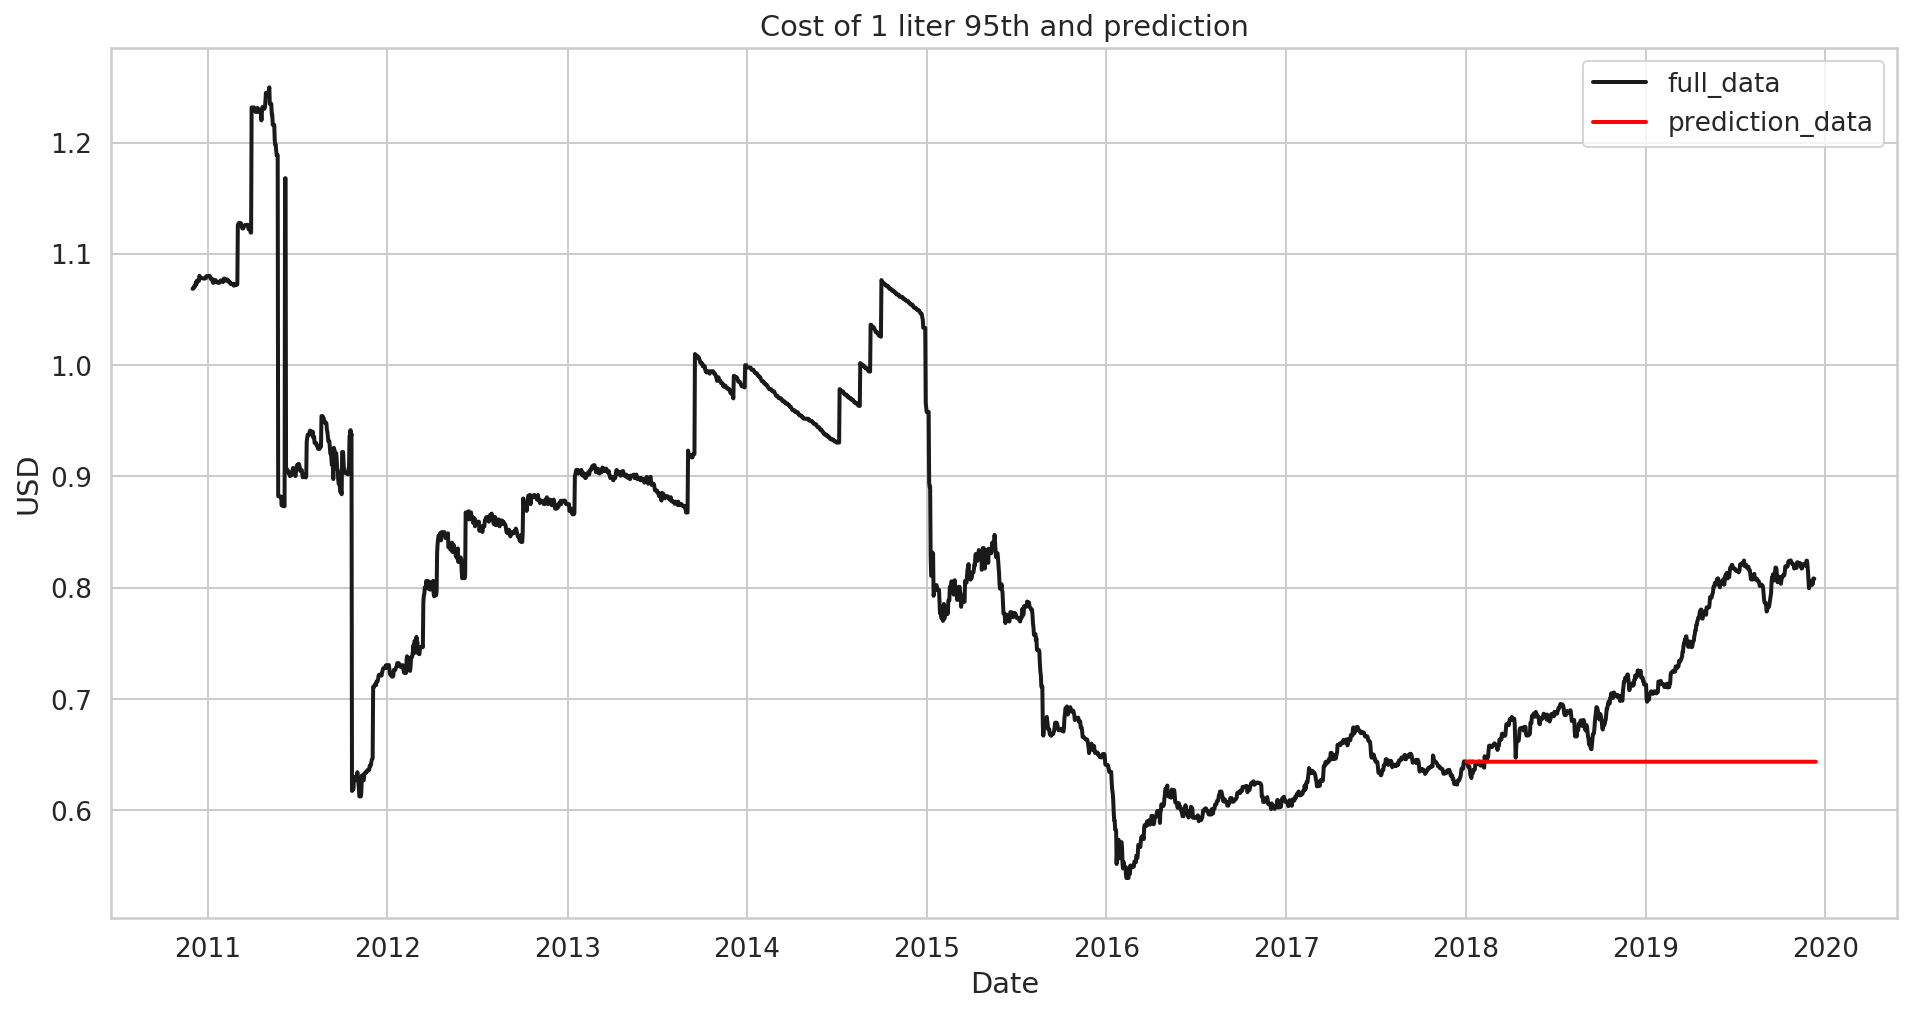

In [347]:
r2_sarimax_aic, rmse_sarimax_aic, mae_sarimax_aic = \
describe_prediction(data['USD_by_liter'], test_data, SARIMAX_aic_pred)

 r2: 0.89 
 rmse: 0.02 
 mae: 0.02


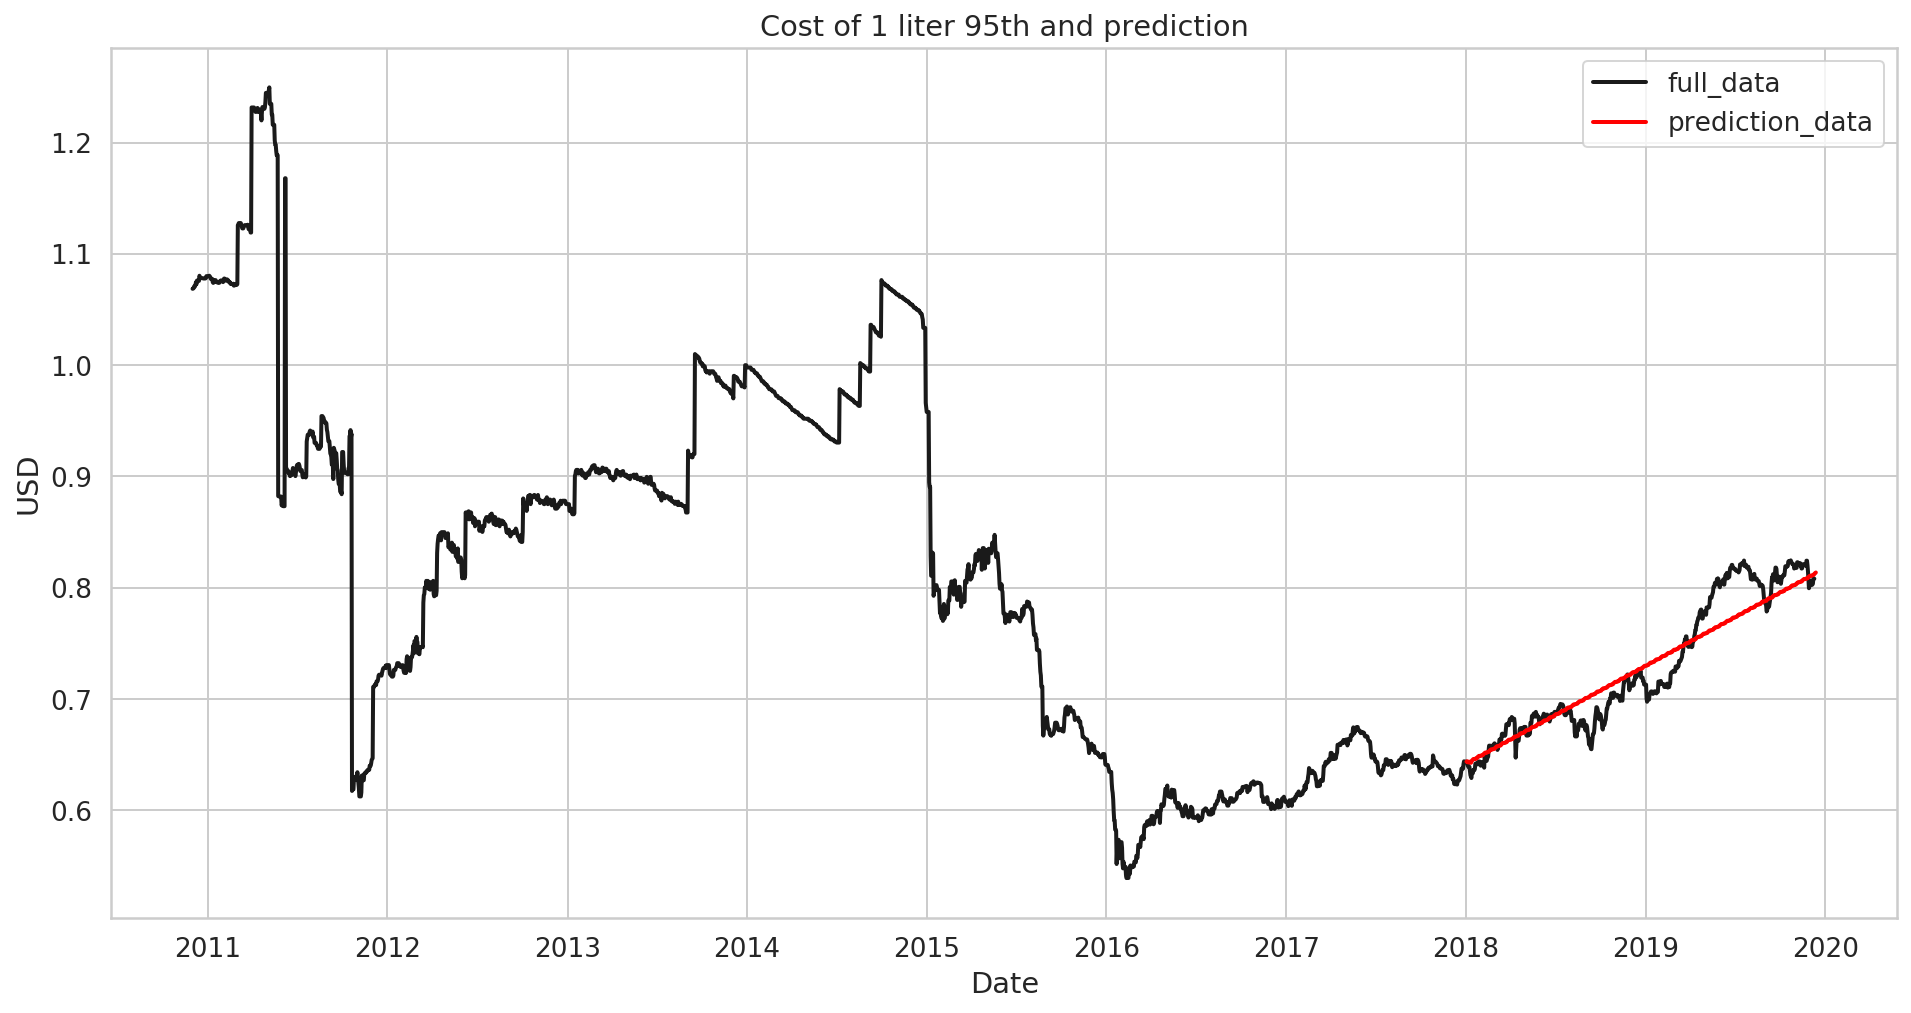

In [348]:
r2_sarimax_r2, rmse_sarimax_r2, mae_sarimax_r2 = \
describe_prediction(data['USD_by_liter'], test_data, SARIMAX_r2_pred)

In [261]:
SARIMAX_r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                  
============================================================================================
Dep. Variable:                         USD_by_liter   No. Observations:                 2589
Model:             SARIMAX(15, 1, 16)x(0, 1, 0, 12)   Log Likelihood                7533.223
Date:                              Thu, 02 Jan 2020   AIC                         -15002.446
Time:                                      21:35:16   BIC                         -14815.330
Sample:                                  12-01-2010   HQIC                        -14934.594
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0610      2.192     -0.028      0.978      -4.357       4.235
ar.L2         -0.3652      0.059     -6.188      0.000      -0.481      -0.250
ar.L3         -0.0912      0.786     -0.116      0.908      -1.632       1.450
ar.L4         -0.1792      0.155     -1.157      0.247      -0.483       0.124
ar.L5         -0.0606      0.249     -0.244      0.807      -0.548       0.427
ar.L6         -0.0604      0.119     -0.507      0.612      -0.294       0.173
ar.L7         -0.0248      0.106     -0.234      0.815      -0.233       0.183
ar.L8         -0.0143      0.059     -0.244      0.808      -0.129       0.101
ar.L9         -0.0108      0.035     -0.312      0.755      -0.079       0.057
ar.L10         0.0064      0.033      0.194      0.846      -0.058       0.071
ar.L11        -0.0009      0.035     -0.027      0.978      -0.069       0.067
ar.L12        -0.0819      0.022     -3.747      0.000      -0.125      -0.039
ar.L13         0.0081      0.186      0.044      0.965      -0.357       0.373
ar.L14        -0.2266      0.026     -8.726      0.000      -0.278      -0.176
ar.L15        -0.0109      0.506     -0.022      0.983      -1.002       0.980
ma.L1          0.0769      2.200      0.035      0.972      -4.236       4.390
ma.L2          0.2000      0.085      2.352      0.019       0.033       0.367
ma.L3          0.1073      0.433      0.248      0.804      -0.742       0.957
ma.L4          0.1123      0.211      0.532      0.595      -0.301       0.526
ma.L5          0.0482      0.084      0.574      0.566      -0.116       0.213
ma.L6          0.0496      0.105      0.473      0.636      -0.156       0.255
ma.L7          0.0465      0.103      0.452      0.651      -0.155       0.248
ma.L8          0.0473      0.097      0.485      0.627      -0.144       0.238
ma.L9          0.0507      0.094      0.537      0.591      -0.134       0.236
ma.L10         0.0321      0.104      0.308      0.758      -0.172       0.236
ma.L11         0.0528      0.064      0.827      0.408      -0.072       0.178
ma.L12        -0.9480      0.111     -8.508      0.000      -1.166      -0.730
ma.L13        -0.0341      2.095     -0.016      0.987      -4.140       4.072
ma.L14        -0.1578      0.063     -2.514      0.012      -0.281      -0.035
ma.L15        -0.0616      0.350     -0.176      0.860      -0.747       0.624
ma.L16        -0.0707      0.129     -0.548      0.583      -0.324       0.182
sigma2         0.0002   4.52e-06     35.259      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       57.34   Jarque-Bera (JB):          12478011.79
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -9.51
Prob(H) (two-s

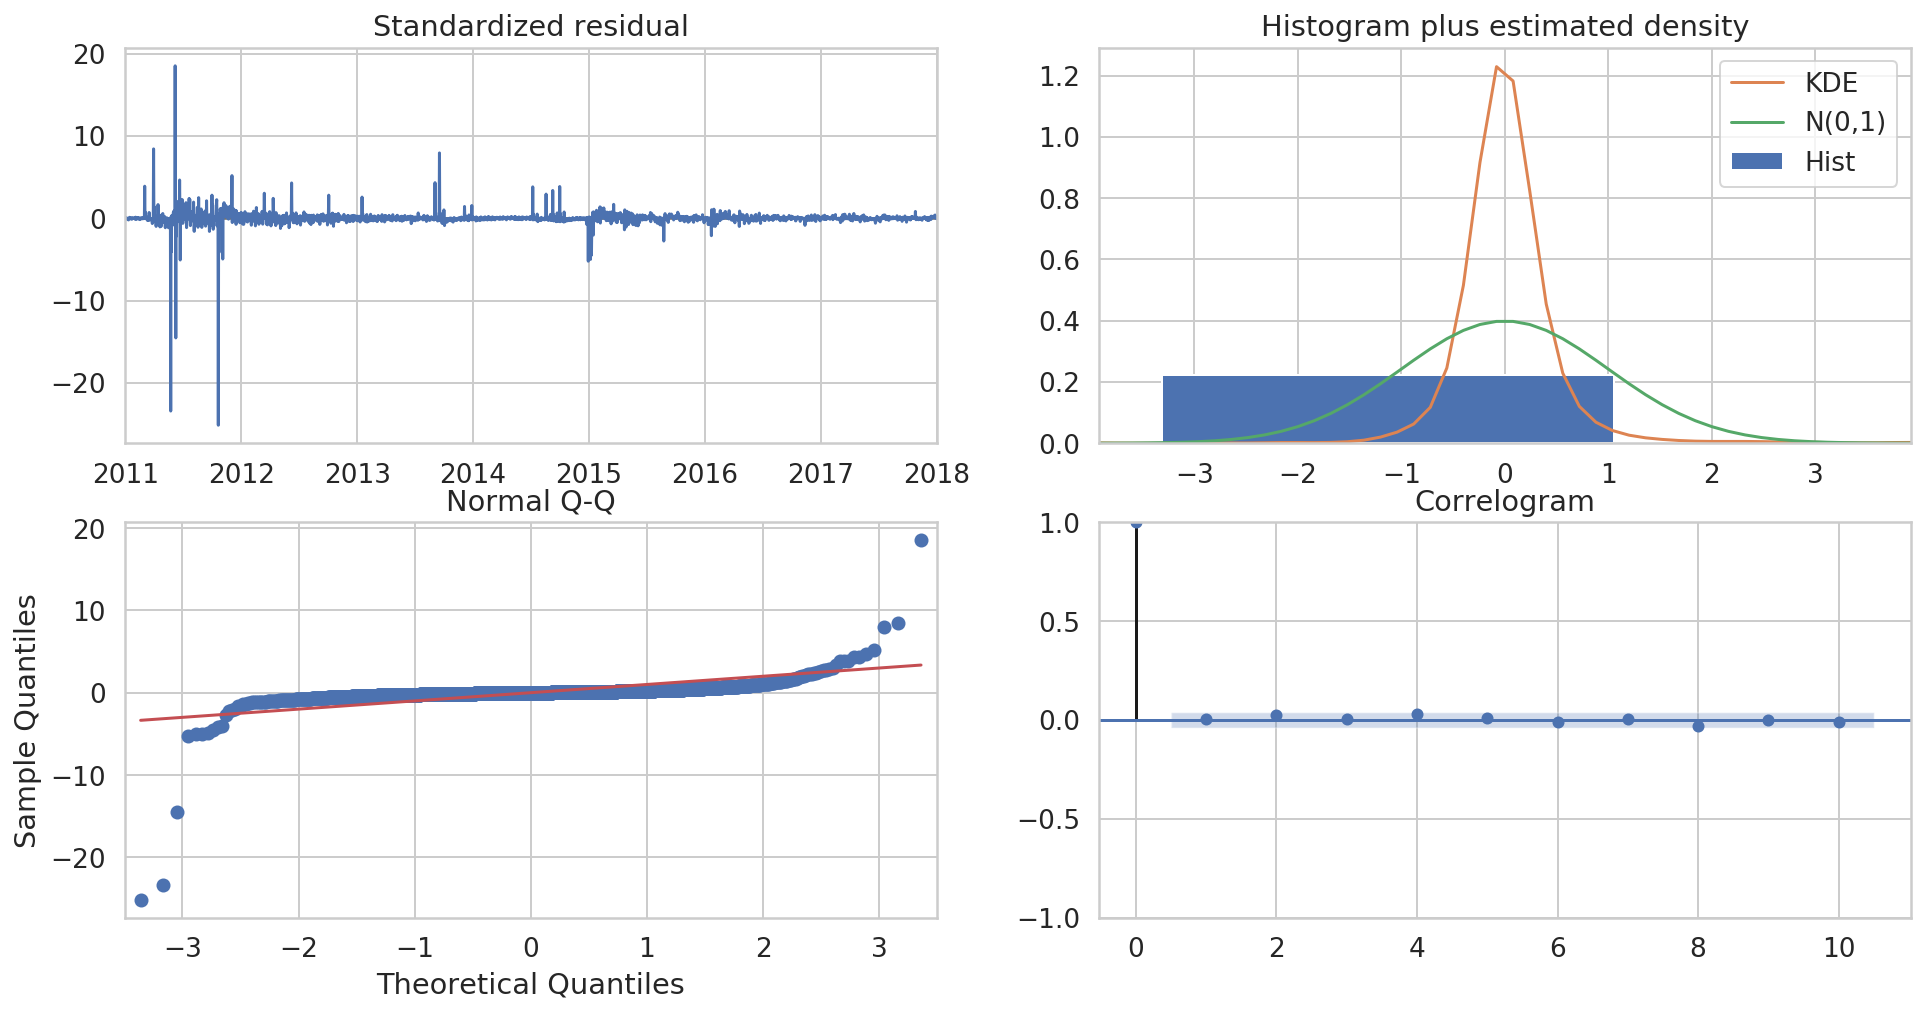

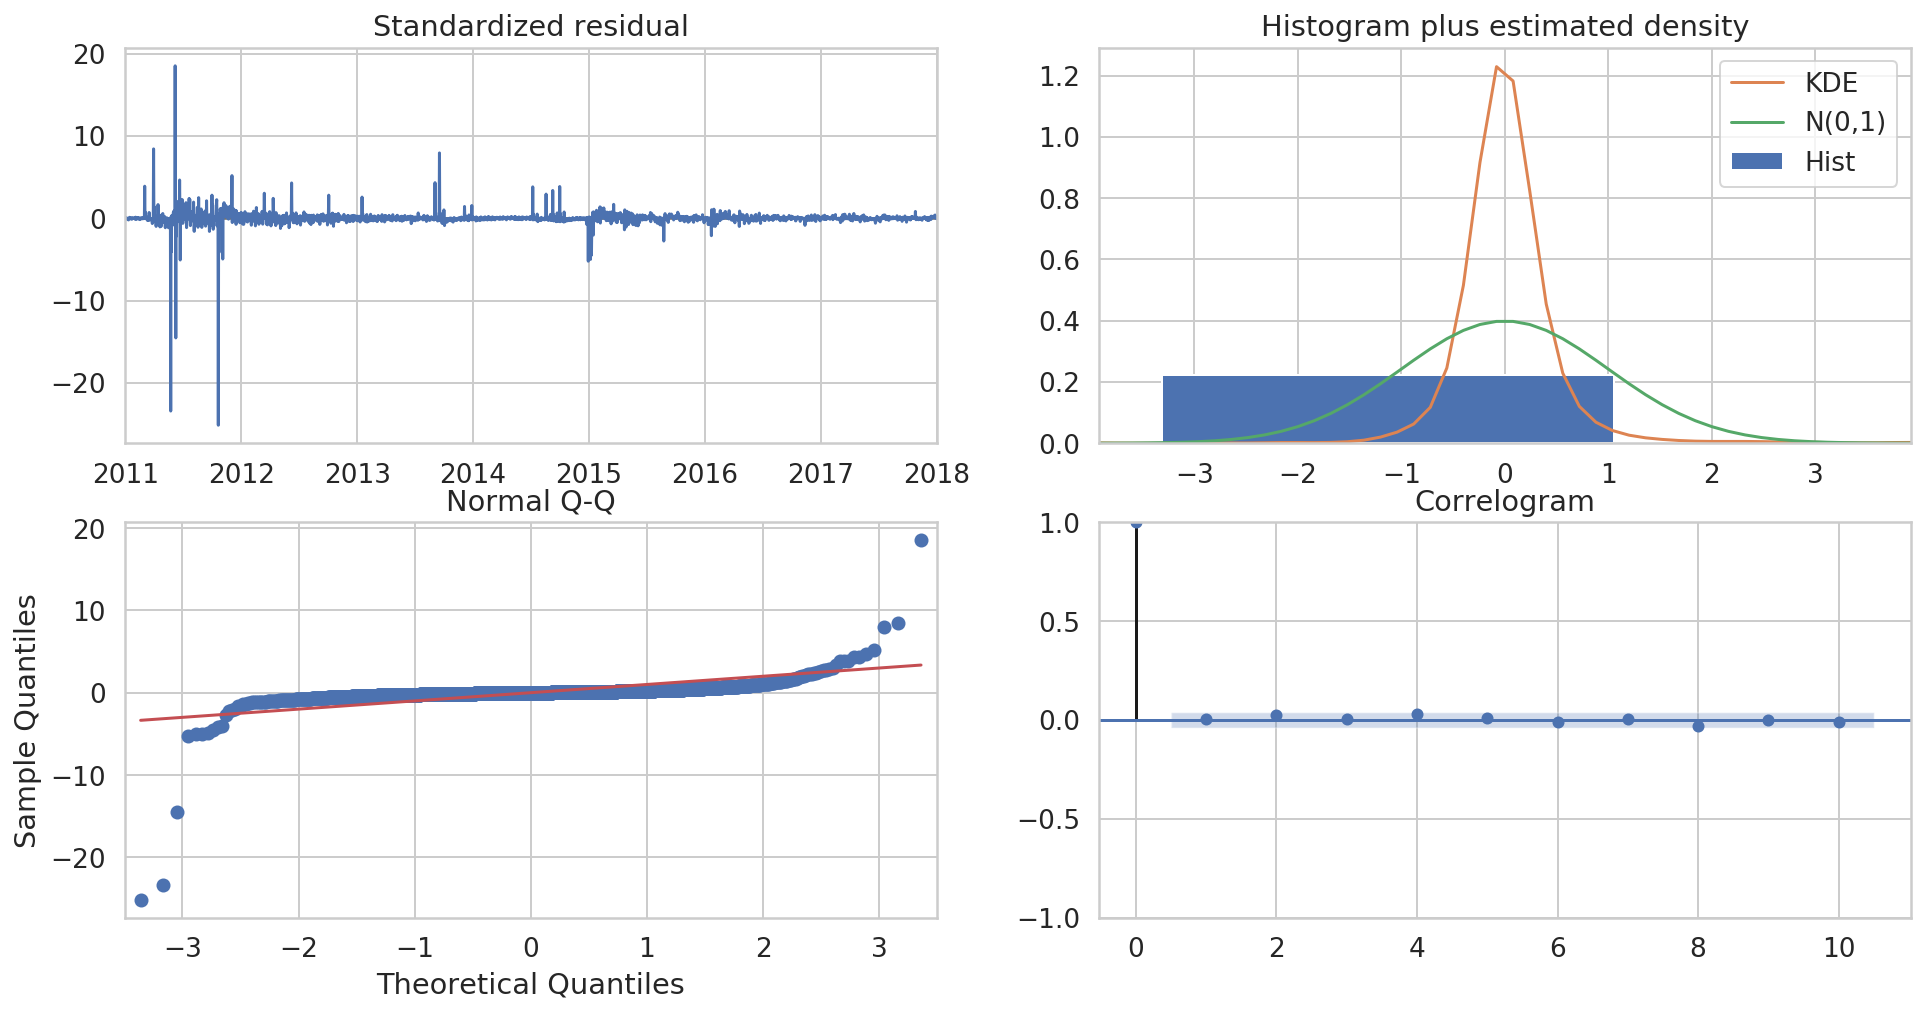

In [265]:
SARIMAX_r2.plot_diagnostics()

In [268]:
# Facebook fbProphet

\begin{array}\\
y(t) = g(t) + s(t) + h(t) + \varepsilon(t)\\
s(t)\quad-\quadсезонность\quad(недельную\quadможно\quadзадавать\quadтаблично,\quadгодовая\quadмоделируется\quadрядами\quadФурье)\\
g(t)\quad-\quadтренд,\quadкусочно-линейная\quadили\quadлогистическая\quadфункция,\quadбиблиотека\quadможет\quadсама\quadвыбирать\quadоптимальные\quadточки\quadизменения\quadтренда,\quadили\quadих\quadможно\quadзадать\quadвручную\\
h(t)\quad-\quadаномальные\quadдни,\quadкоторые\quadпользователь\quadзадает\quadсам\\
\varepsilon(t)\quad-\quadошибка
\end{array}

In [269]:
df = pd.DataFrame({'ds': data.index, 'y': data['USD_by_liter']}) 

In [270]:
df = df[:'2018-01-01'].reset_index(drop = True)

In [286]:
m = Prophet.Prophet(growth='linear',\
                    changepoint_prior_scale=0.01,\
                    yearly_seasonality = True,
                    weekly_seasonality = False,\
                    daily_seasonality = False)
m.fit(df)

In [287]:
future = m.make_future_dataframe(periods=len(data['2018-01-01':]))

In [288]:
forecast = m.predict(future)

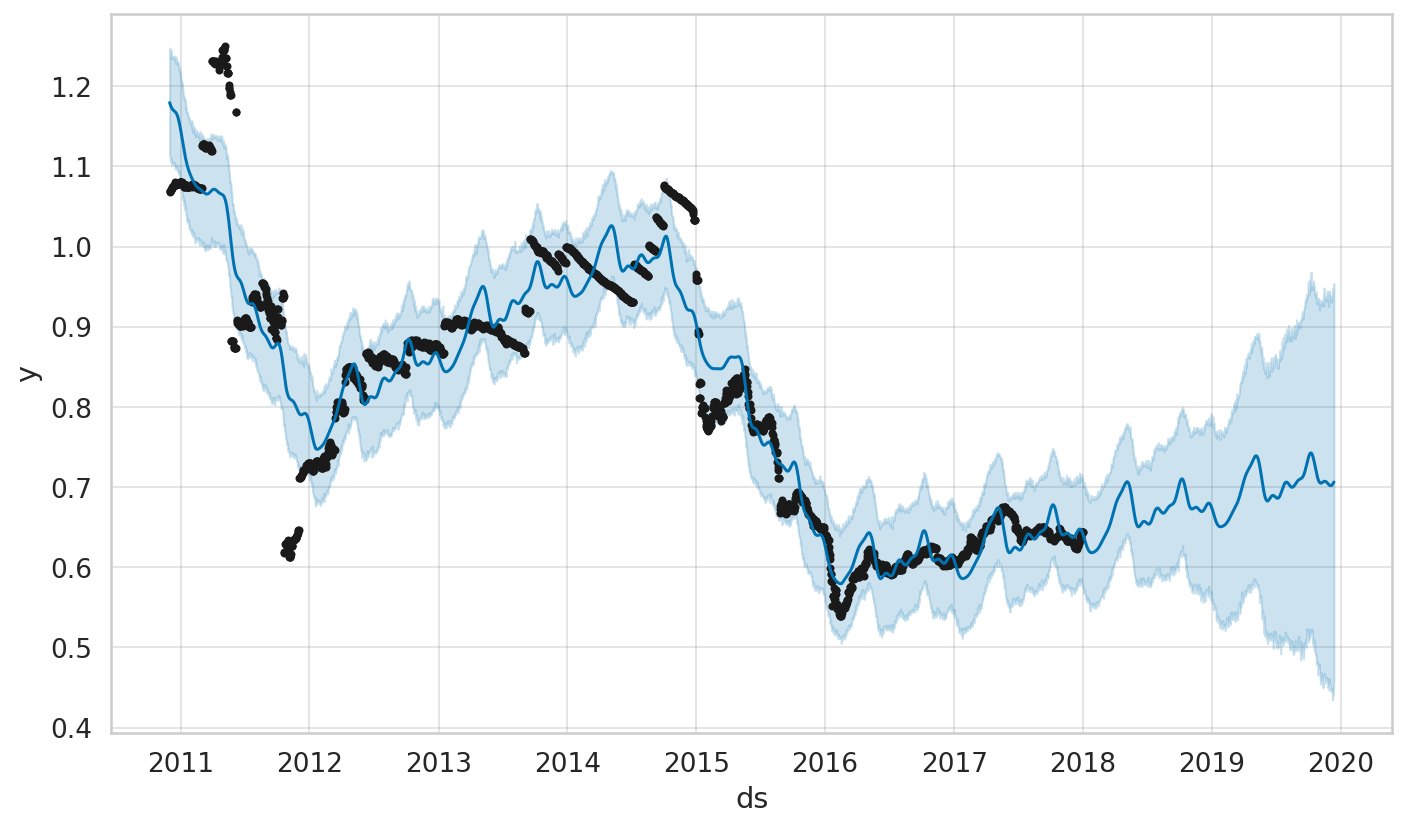

In [289]:
fig1 = m.plot(forecast)

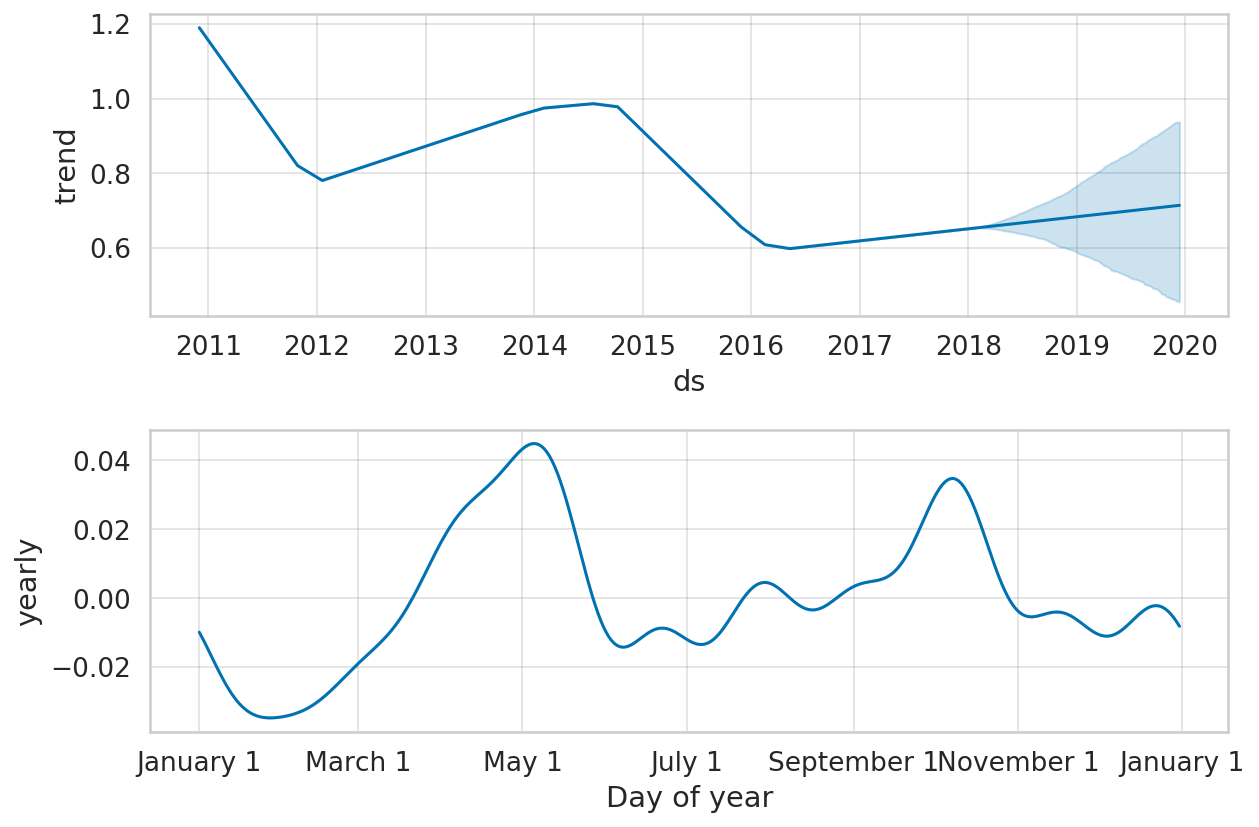

In [290]:
fig2 = m.plot_components(forecast)

In [291]:
prophet_pred = forecast['yhat'][forecast['ds']>pd.Timestamp('2018-01-01')]

In [292]:
prophet_pred = forecast[['ds', 'yhat']][forecast['ds']>pd.Timestamp('2018-01-01')]
prophet_pred = prophet_pred.set_index('ds')

 r2: -0.14 
 rmse: 0.08 
 mae: 0.06


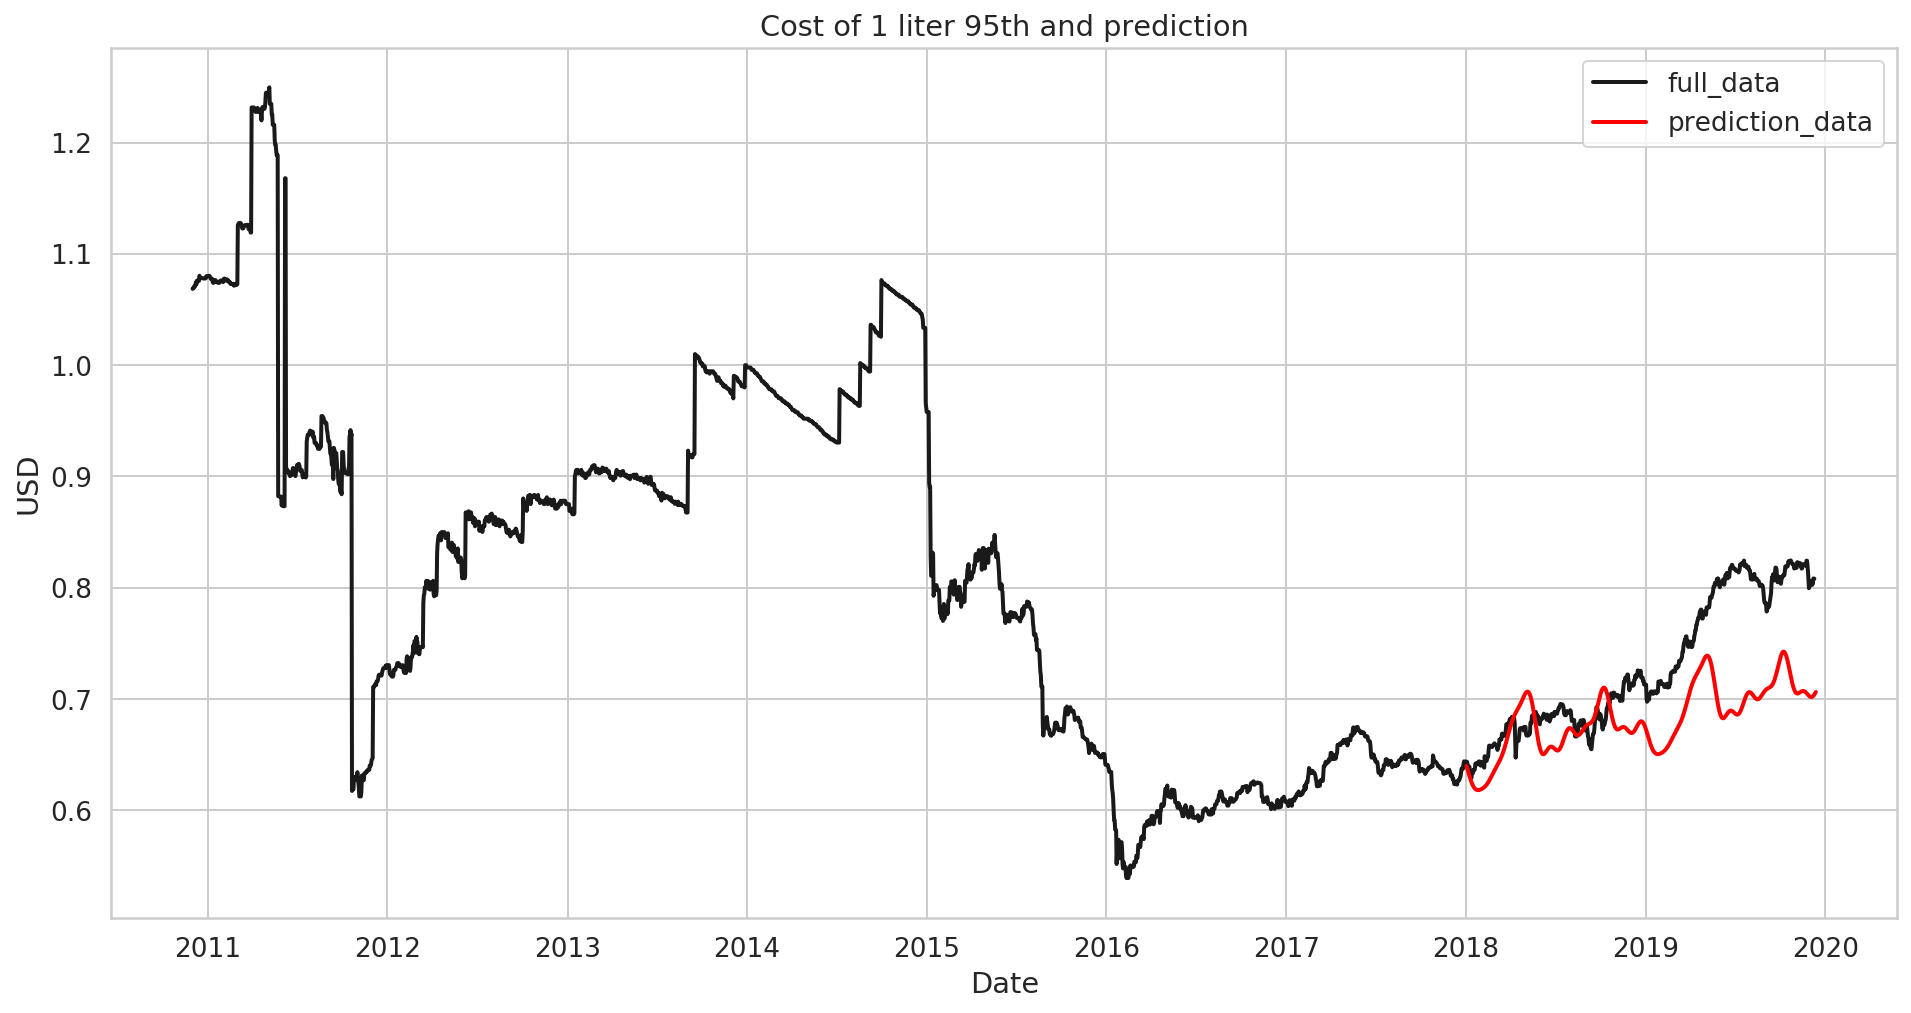

In [349]:
r2_prophet, rmse_prophet, mae_prophet = \
describe_prediction(data['USD_by_liter'], test_data, prophet_pred)

In [294]:
# НЕЙРОСЕТЬ

In [295]:
def preprocessing_for_ml(series, diff=True, normalization=True, regr=True):
    
    series_copy = series
    
    if diff:
        series = series.diff(periods=1).dropna()

    # size time window
    WINDOW = 30
    STEP = 1

    # creating time windows
    X, Y = [], []
    for i in range(0, len(series), STEP): 
        
        try:
            x_i = series[i:i+WINDOW]
            y_i = series[i+WINDOW]  

            last_close = x_i[WINDOW-1]
            next_close = y_i

            if last_close < next_close:
                y_i = [1, 0]
            else:
                y_i = [0, 1] 

        except Exception as e:
            print(e)
            break

        X.append(x_i)
        Y.append(y_i)
        
    if normalization:
        X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
    
    if regr:
        Y = series_copy[0:len(X)]
        
    return np.array(X), np.array(Y)

In [296]:
X_class, Y_class         = preprocessing_for_ml(data['USD_by_liter'], diff=False, normalization=True,  regr=False)
X_regr, Y_regr           = preprocessing_for_ml(data['USD_by_liter'], diff=False, normalization=False, regr=True)
X_diff_regr, Y_diff_regr = preprocessing_for_ml(data['USD_by_liter'], diff=True,  normalization=False, regr=True)

index out of bounds
index out of bounds
index out of bounds


In [297]:
X_class_train     = X_class[0:2589] # 01.01.2018
Y_class_train     = Y_class[0:2589]
X_class_test      = X_class[2589:]
Y_class_test      = Y_class[2589:]

X_regr_train      = X_regr[0:2589]
Y_regr_train      = Y_regr[0:2589]
X_regr_test       = X_regr[2589:]
Y_regr_test       = Y_regr[2589:]

X_diff_regr_train = X_diff_regr[0:2589]
Y_diff_regr_train = Y_diff_regr[0:2589]
X_diff_regr_test  = X_diff_regr[2589:]
Y_diff_regr_test  = Y_diff_regr[2589:]

In [298]:
# классификация

In [299]:
model = Sequential()
model.add(Dense(64, input_dim=30))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [300]:
opt = Nadam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [301]:
history = model.fit(X_class_train, Y_class_train, 
          nb_epoch = 150, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_class_test, Y_class_test),
          shuffle=True,
          callbacks=[reduce_lr])

Train on 2589 samples, validate on 680 samples
Epoch 1/150
2589/2589 [==============================] - 1s 273us/step - loss: 0.7796 - accuracy: 0.5284 - val_loss: 0.6988 - val_accuracy: 0.5162
Epoch 2/150
2589/2589 [==============================] - 0s 43us/step - loss: 0.6128 - accuracy: 0.6910 - val_loss: 0.7006 - val_accuracy: 0.5779
Epoch 3/150
2589/2589 [==============================] - 0s 40us/step - loss: 0.5758 - accuracy: 0.7227 - val_loss: 0.6987 - val_accuracy: 0.5985
Epoch 4/150
2589/2589 [==============================] - 0s 45us/step - loss: 0.5635 - accuracy: 0.7381 - val_loss: 0.7108 - val_accuracy: 0.6000
Epoch 5/150
2589/2589 [==============================] - 0s 39us/step - loss: 0.5593 - accuracy: 0.7389 - val_loss: 0.7082 - val_accuracy: 0.5971
Epoch 6/150
2589/2589 [==============================] - 0s 43us/step - loss: 0.5557 - accuracy: 0.7428 - val_loss: 0.7100 - val_accuracy: 0.6000
Epoch 7/150
2589/2589 [==============================] - 0s 33us/step - loss

2589/2589 [==============================] - 0s 35us/step - loss: 0.5216 - accuracy: 0.7528 - val_loss: 0.7124 - val_accuracy: 0.5985

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
Epoch 53/150
2589/2589 [==============================] - 0s 28us/step - loss: 0.5207 - accuracy: 0.7520 - val_loss: 0.7101 - val_accuracy: 0.6000
Epoch 54/150
2589/2589 [==============================] - 0s 31us/step - loss: 0.5198 - accuracy: 0.7516 - val_loss: 0.7055 - val_accuracy: 0.5985
Epoch 55/150
2589/2589 [==============================] - 0s 29us/step - loss: 0.5205 - accuracy: 0.7528 - val_loss: 0.7081 - val_accuracy: 0.5956
Epoch 56/150
2589/2589 [==============================] - 0s 21us/step - loss: 0.5204 - accuracy: 0.7540 - val_loss: 0.7055 - val_accuracy: 0.6044
Epoch 57/150
2589/2589 [==============================] - 0s 20us/step - loss: 0.5210 - accuracy: 0.7516 - val_loss: 0.7099 - val_accuracy: 0.6029

Epoch 00057: ReduceLROnPlateau reducing learning

2589/2589 [==============================] - 0s 22us/step - loss: 0.5136 - accuracy: 0.7524 - val_loss: 0.7120 - val_accuracy: 0.5941

Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0001350851875031367.
Epoch 103/150
2589/2589 [==============================] - 0s 21us/step - loss: 0.5123 - accuracy: 0.7513 - val_loss: 0.7114 - val_accuracy: 0.5926
Epoch 104/150
2589/2589 [==============================] - 0s 21us/step - loss: 0.5112 - accuracy: 0.7563 - val_loss: 0.7125 - val_accuracy: 0.5926
Epoch 105/150
2589/2589 [==============================] - 0s 27us/step - loss: 0.5111 - accuracy: 0.7528 - val_loss: 0.7143 - val_accuracy: 0.5926
Epoch 106/150
2589/2589 [==============================] - 0s 28us/step - loss: 0.5124 - accuracy: 0.7536 - val_loss: 0.7144 - val_accuracy: 0.5971
Epoch 107/150
2589/2589 [==============================] - 0s 37us/step - loss: 0.5113 - accuracy: 0.7567 - val_loss: 0.7131 - val_accuracy: 0.5926

Epoch 00107: ReduceLROnPlateau reducing lear

In [317]:
def drow_ml_metrics(history):
    plt.plot(history.history['loss'], c = '#008080', linewidth = 2)
    plt.plot(history.history['val_loss'], c = '#00FF00', linewidth = 2)
    
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'], c = '#008080', linewidth = 2)
    plt.plot(history.history['val_accuracy'], c = '#00FF00', linewidth = 2)
    
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

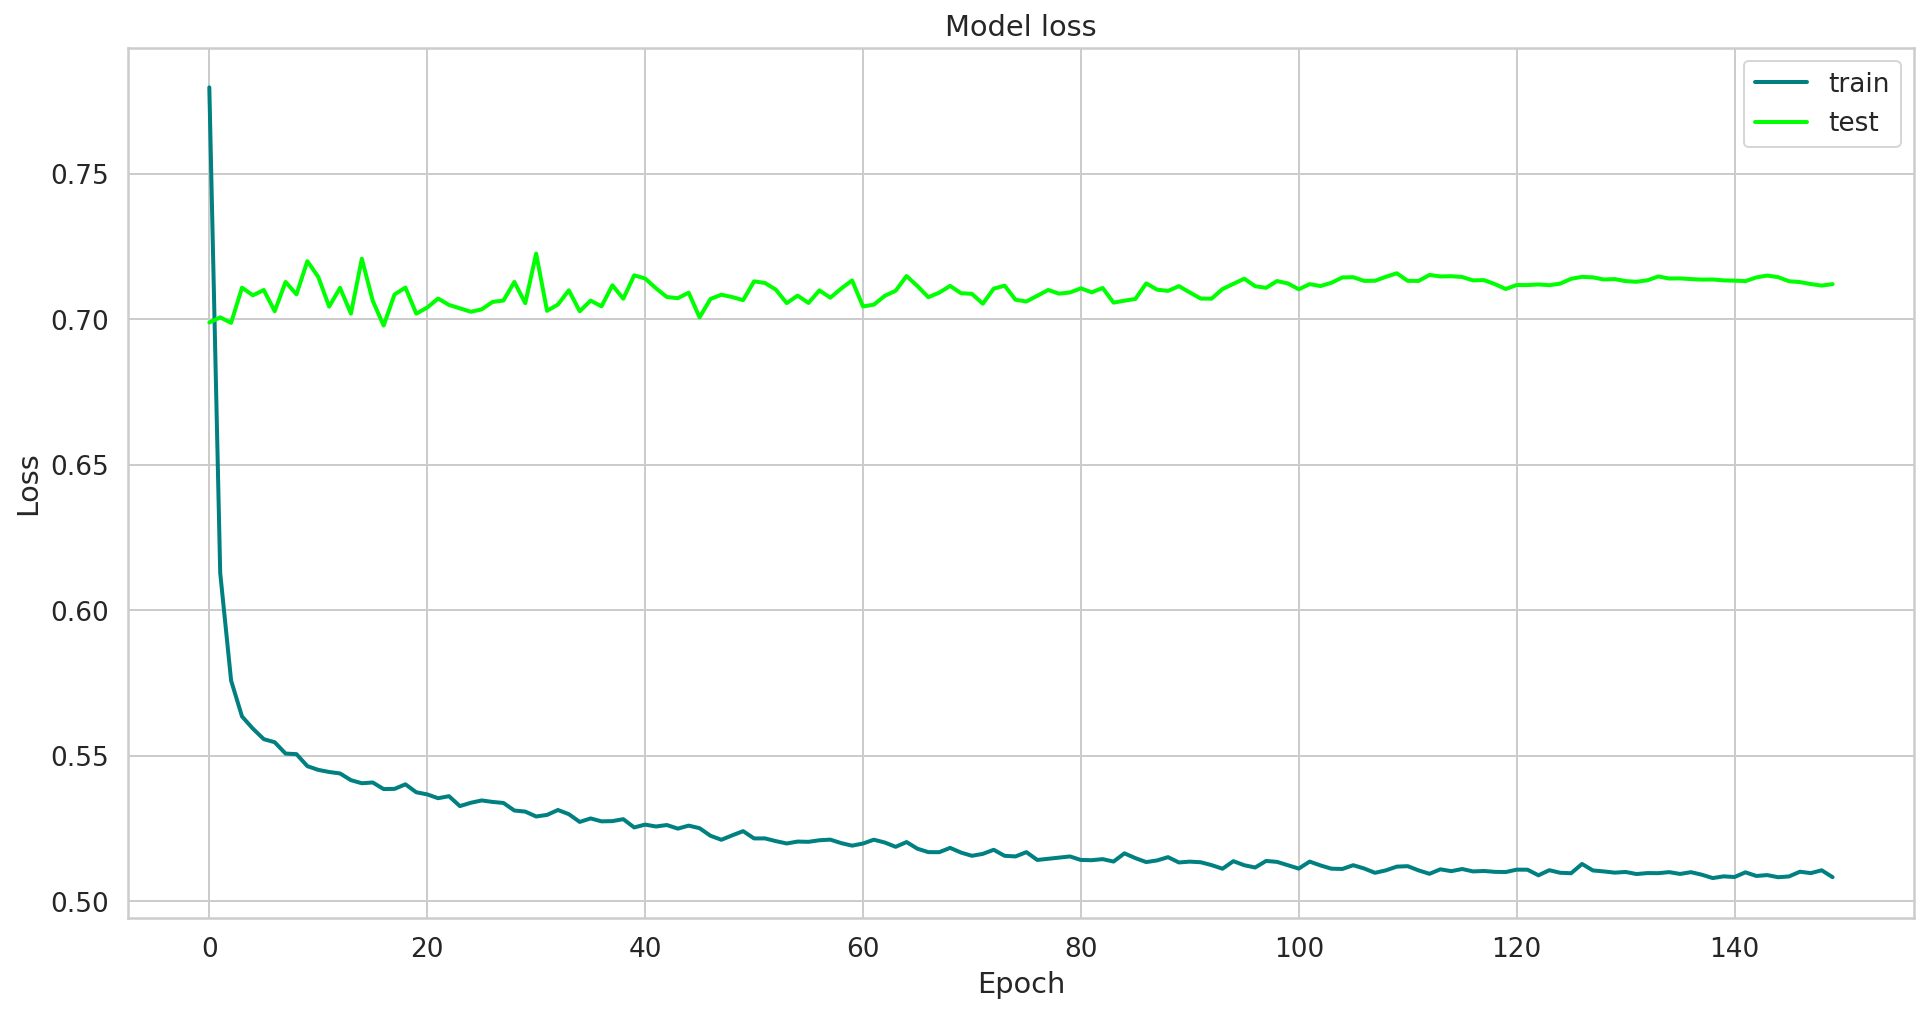

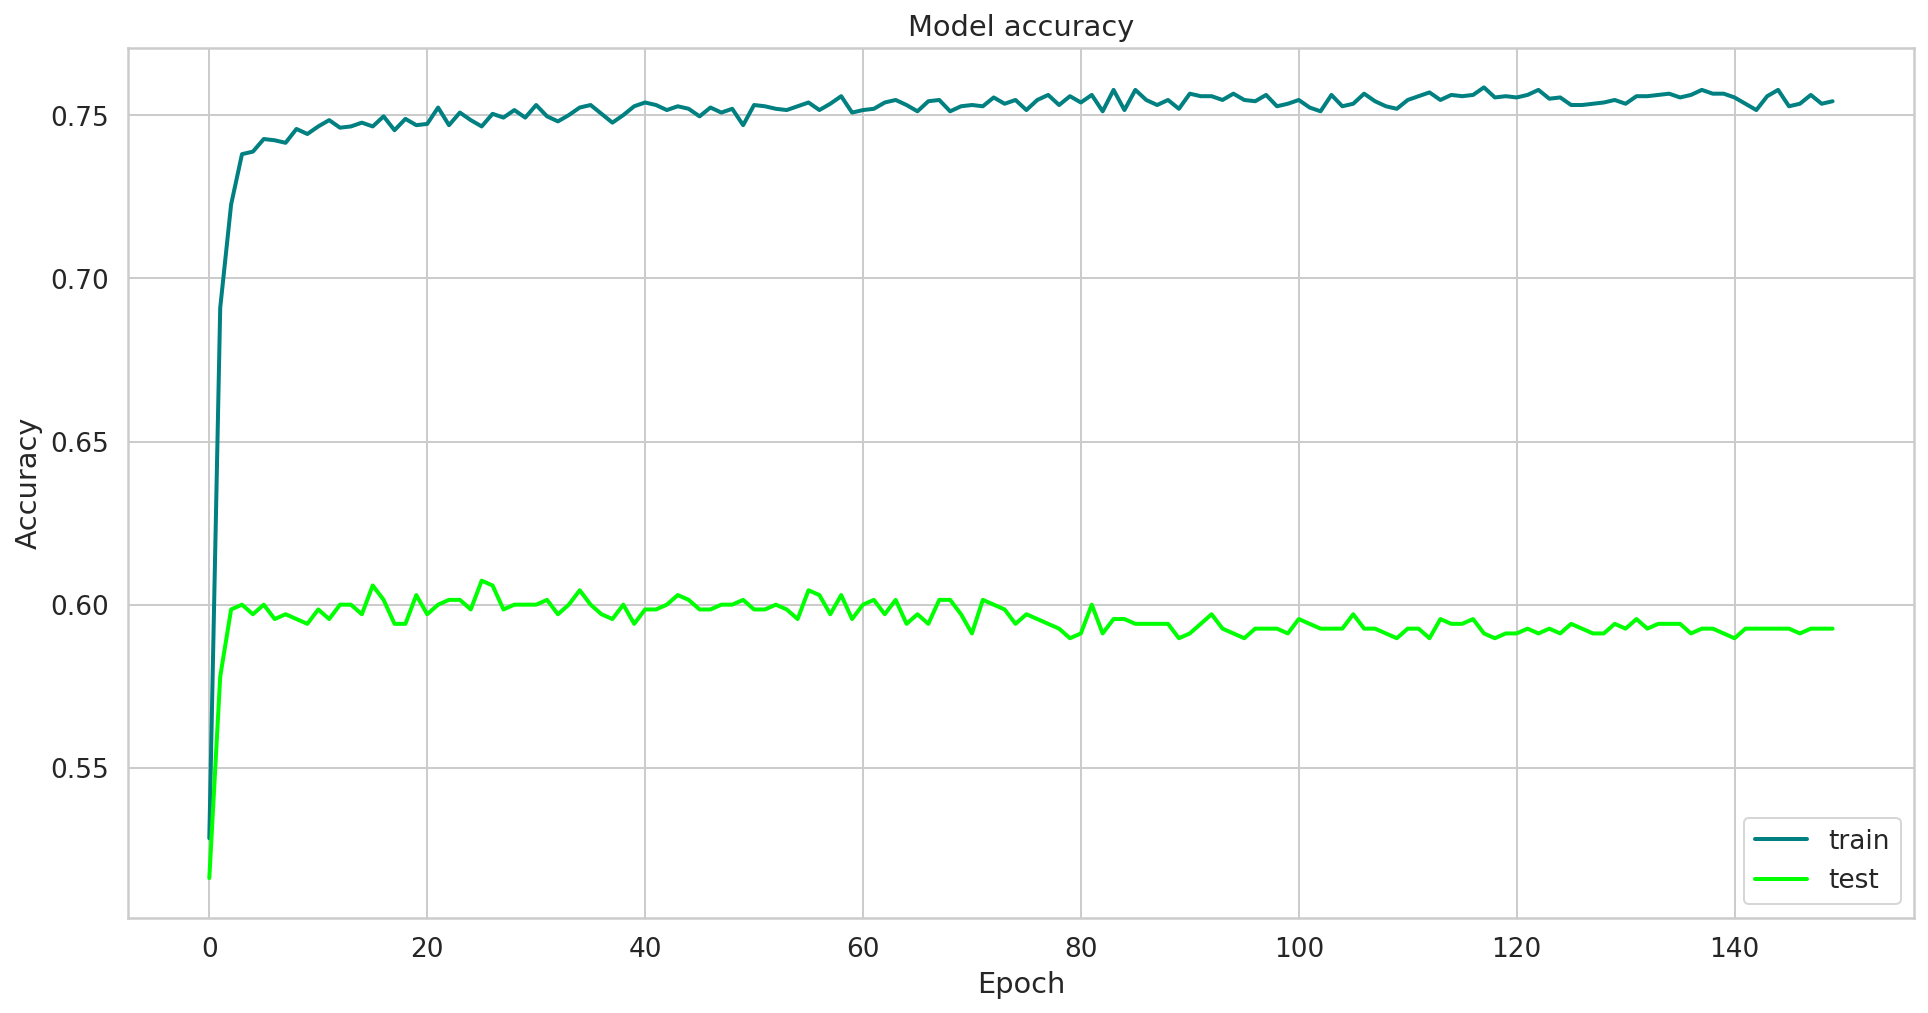

In [318]:
drow_ml_metrics(history)

In [319]:
# Добавим еще один слой с 4я нейронами

In [320]:
model_2_lay = Sequential()
model_2_lay.add(Dense(64, input_dim=30))
model_2_lay.add(BatchNormalization())
model_2_lay.add(LeakyReLU())
model_2_lay.add(Dense(4))
model_2_lay.add(BatchNormalization())
model_2_lay.add(LeakyReLU())
model_2_lay.add(Dense(2))
model_2_lay.add(Activation('softmax'))

In [321]:
opt = Nadam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model_2_lay.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [322]:
history_2_lay = model_2_lay.fit(X_class_train, Y_class_train, 
          nb_epoch = 150, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_class_test, Y_class_test),
          shuffle=True,
          callbacks=[reduce_lr])

Train on 2589 samples, validate on 680 samples
Epoch 1/150
2589/2589 [==============================] - 1s 291us/step - loss: 0.7032 - accuracy: 0.5245 - val_loss: 0.6558 - val_accuracy: 0.6147
Epoch 2/150
2589/2589 [==============================] - 0s 33us/step - loss: 0.6579 - accuracy: 0.5825 - val_loss: 0.6523 - val_accuracy: 0.6118
Epoch 3/150
2589/2589 [==============================] - 0s 38us/step - loss: 0.6334 - accuracy: 0.6976 - val_loss: 0.6522 - val_accuracy: 0.6118
Epoch 4/150
2589/2589 [==============================] - 0s 35us/step - loss: 0.6126 - accuracy: 0.7300 - val_loss: 0.6547 - val_accuracy: 0.6088
Epoch 5/150
2589/2589 [==============================] - 0s 40us/step - loss: 0.5896 - accuracy: 0.7281 - val_loss: 0.6655 - val_accuracy: 0.6147
Epoch 6/150
2589/2589 [==============================] - 0s 39us/step - loss: 0.5696 - accuracy: 0.7273 - val_loss: 0.6742 - val_accuracy: 0.6029
Epoch 7/150
2589/2589 [==============================] - 0s 39us/step - loss

2589/2589 [==============================] - 0s 41us/step - loss: 0.4718 - accuracy: 0.7694 - val_loss: 0.7327 - val_accuracy: 0.5941
Epoch 52/150
2589/2589 [==============================] - 0s 41us/step - loss: 0.4741 - accuracy: 0.7698 - val_loss: 0.7403 - val_accuracy: 0.5912
Epoch 53/150
2589/2589 [==============================] - 0s 39us/step - loss: 0.4698 - accuracy: 0.7690 - val_loss: 0.7436 - val_accuracy: 0.5897

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.
Epoch 54/150
2589/2589 [==============================] - 0s 28us/step - loss: 0.4679 - accuracy: 0.7775 - val_loss: 0.7472 - val_accuracy: 0.5824
Epoch 55/150
2589/2589 [==============================] - 0s 26us/step - loss: 0.4663 - accuracy: 0.7679 - val_loss: 0.7412 - val_accuracy: 0.5853
Epoch 56/150
2589/2589 [==============================] - 0s 36us/step - loss: 0.4656 - accuracy: 0.7710 - val_loss: 0.7442 - val_accuracy: 0.5897
Epoch 57/150
2589/2589 [==========================

2589/2589 [==============================] - 0s 29us/step - loss: 0.4431 - accuracy: 0.7833 - val_loss: 0.7757 - val_accuracy: 0.5926
Epoch 102/150
2589/2589 [==============================] - 0s 31us/step - loss: 0.4447 - accuracy: 0.7864 - val_loss: 0.7749 - val_accuracy: 0.5985
Epoch 103/150
2589/2589 [==============================] - 0s 39us/step - loss: 0.4396 - accuracy: 0.7856 - val_loss: 0.7817 - val_accuracy: 0.5941

Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.00012157666351413355.
Epoch 104/150
2589/2589 [==============================] - 0s 36us/step - loss: 0.4428 - accuracy: 0.7868 - val_loss: 0.7799 - val_accuracy: 0.5897
Epoch 105/150
2589/2589 [==============================] - 0s 29us/step - loss: 0.4363 - accuracy: 0.7891 - val_loss: 0.7801 - val_accuracy: 0.5956
Epoch 106/150
2589/2589 [==============================] - 0s 33us/step - loss: 0.4395 - accuracy: 0.7837 - val_loss: 0.7784 - val_accuracy: 0.5956
Epoch 107/150
2589/2589 [===================

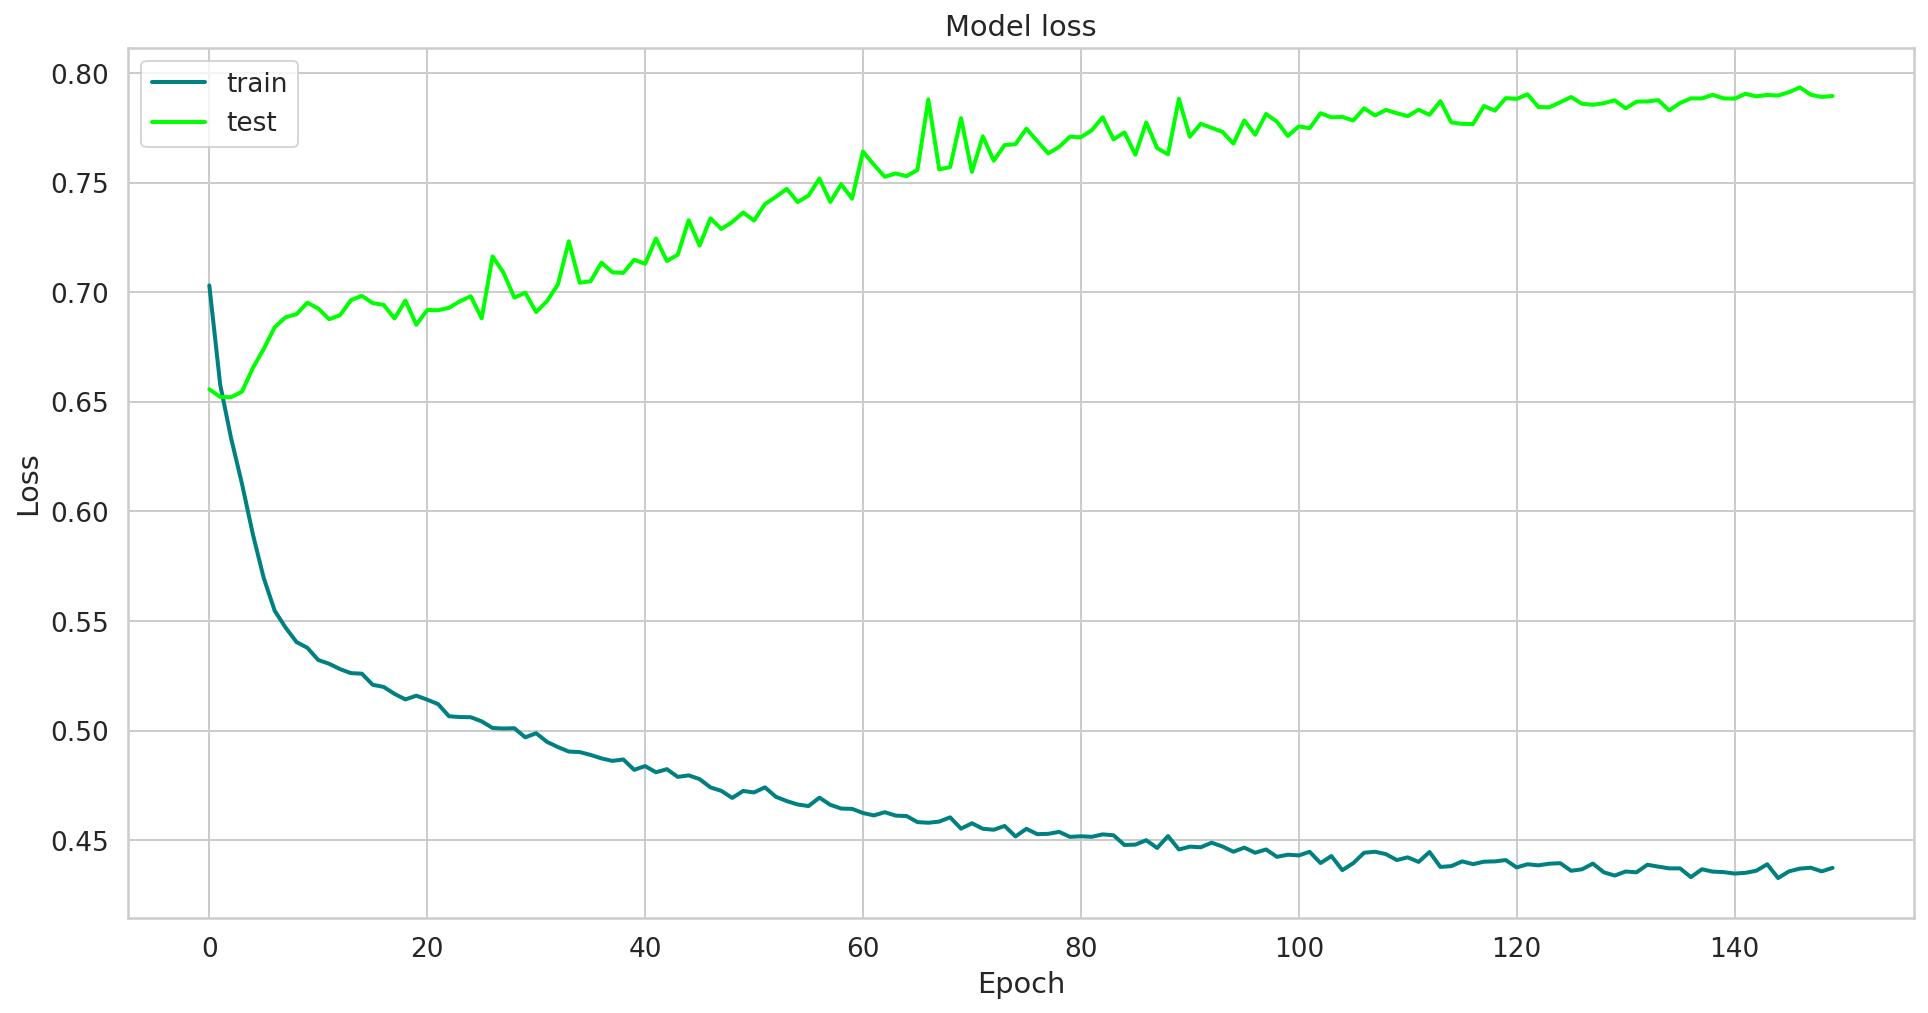

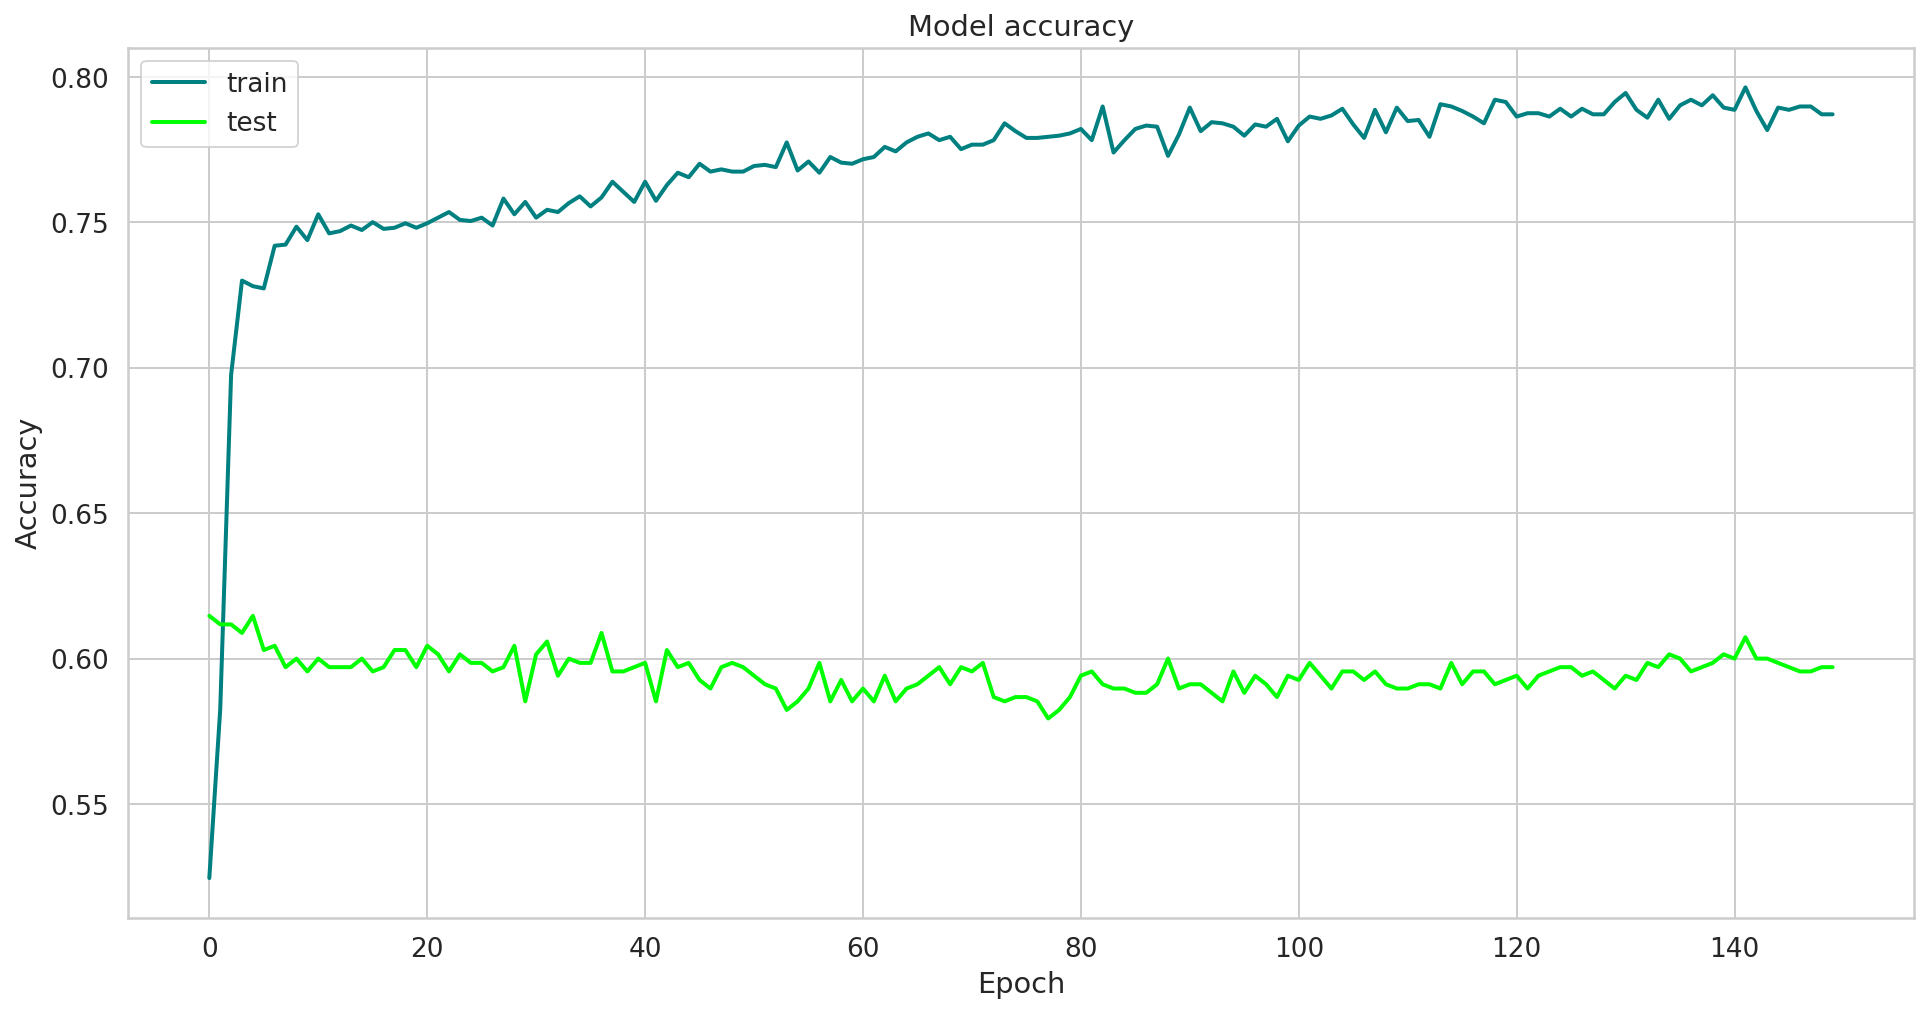

In [323]:
drow_ml_metrics(history_2_lay)

In [324]:
# Добавим регуляризацию 

In [325]:
model_regul = Sequential()
model_regul.add(Dense(64, input_dim=30, activity_regularizer=regularizers.l2(0.01)))
model_regul.add(BatchNormalization())
model_regul.add(LeakyReLU())
model_regul.add(Dense(4, activity_regularizer=regularizers.l2(0.01)))
model_regul.add(BatchNormalization())
model_regul.add(LeakyReLU())
model_regul.add(Dense(2))
model_regul.add(Activation('softmax'))

In [326]:
opt = Nadam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model_regul.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [327]:
history_regul = model_regul.fit(X_class_train, Y_class_train, 
                                nb_epoch = 300, 
                                batch_size = 128, 
                                verbose=1, 
                                validation_data=(X_class_test, Y_class_test),
                                shuffle=True,
                                callbacks=[reduce_lr])

Train on 2589 samples, validate on 680 samples
Epoch 1/300
2589/2589 [==============================] - 1s 293us/step - loss: 38.6712 - accuracy: 0.4480 - val_loss: 26.9327 - val_accuracy: 0.4324
Epoch 2/300
2589/2589 [==============================] - 0s 35us/step - loss: 23.5417 - accuracy: 0.4681 - val_loss: 17.0626 - val_accuracy: 0.4515
Epoch 3/300
2589/2589 [==============================] - 0s 39us/step - loss: 16.4045 - accuracy: 0.5114 - val_loss: 12.2377 - val_accuracy: 0.5353
Epoch 4/300
2589/2589 [==============================] - 0s 36us/step - loss: 12.6839 - accuracy: 0.5392 - val_loss: 9.5375 - val_accuracy: 0.5750
Epoch 5/300
2589/2589 [==============================] - 0s 44us/step - loss: 10.4334 - accuracy: 0.5751 - val_loss: 7.8282 - val_accuracy: 0.5912
Epoch 6/300
2589/2589 [==============================] - 0s 39us/step - loss: 8.8297 - accuracy: 0.6033 - val_loss: 6.6335 - val_accuracy: 0.5926
Epoch 7/300
2589/2589 [==============================] - 0s 37us/ste

2589/2589 [==============================] - 0s 33us/step - loss: 0.8455 - accuracy: 0.7505 - val_loss: 0.9402 - val_accuracy: 0.5897
Epoch 57/300
2589/2589 [==============================] - 0s 29us/step - loss: 0.8359 - accuracy: 0.7486 - val_loss: 0.9273 - val_accuracy: 0.6000
Epoch 58/300
2589/2589 [==============================] - 0s 34us/step - loss: 0.8160 - accuracy: 0.7501 - val_loss: 0.9431 - val_accuracy: 0.6029
Epoch 59/300
2589/2589 [==============================] - 0s 33us/step - loss: 0.8118 - accuracy: 0.7516 - val_loss: 0.9430 - val_accuracy: 0.5868
Epoch 60/300
2589/2589 [==============================] - 0s 32us/step - loss: 0.7988 - accuracy: 0.7536 - val_loss: 1.1227 - val_accuracy: 0.5985
Epoch 61/300
2589/2589 [==============================] - 0s 28us/step - loss: 0.8128 - accuracy: 0.7513 - val_loss: 0.9449 - val_accuracy: 0.6044
Epoch 62/300
2589/2589 [==============================] - 0s 31us/step - loss: 0.7756 - accuracy: 0.7543 - val_loss: 0.9062 - val_a

2589/2589 [==============================] - 0s 45us/step - loss: 0.5696 - accuracy: 0.7663 - val_loss: 0.7934 - val_accuracy: 0.6103
Epoch 110/300
2589/2589 [==============================] - 0s 56us/step - loss: 0.5779 - accuracy: 0.7655 - val_loss: 0.8184 - val_accuracy: 0.6029
Epoch 111/300
2589/2589 [==============================] - 0s 49us/step - loss: 0.5658 - accuracy: 0.7683 - val_loss: 0.7826 - val_accuracy: 0.6118
Epoch 112/300
2589/2589 [==============================] - 0s 59us/step - loss: 0.5608 - accuracy: 0.7640 - val_loss: 0.8337 - val_accuracy: 0.5926

Epoch 00112: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 113/300
2589/2589 [==============================] - 0s 54us/step - loss: 0.5673 - accuracy: 0.7679 - val_loss: 0.8233 - val_accuracy: 0.6029
Epoch 114/300
2589/2589 [==============================] - 0s 58us/step - loss: 0.5648 - accuracy: 0.7644 - val_loss: 0.7754 - val_accuracy: 0.6118
Epoch 115/300
2589/2589 [====================


Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 160/300
2589/2589 [==============================] - 0s 56us/step - loss: 0.4946 - accuracy: 0.7980 - val_loss: 0.7862 - val_accuracy: 0.5985
Epoch 161/300
2589/2589 [==============================] - 0s 62us/step - loss: 0.4808 - accuracy: 0.8061 - val_loss: 0.8353 - val_accuracy: 0.5897
Epoch 162/300
2589/2589 [==============================] - 0s 61us/step - loss: 0.4910 - accuracy: 0.8015 - val_loss: 0.8211 - val_accuracy: 0.6088
Epoch 163/300
2589/2589 [==============================] - 0s 47us/step - loss: 0.4799 - accuracy: 0.8026 - val_loss: 0.9454 - val_accuracy: 0.6000
Epoch 164/300
2589/2589 [==============================] - 0s 48us/step - loss: 0.4885 - accuracy: 0.8026 - val_loss: 0.7701 - val_accuracy: 0.6147

Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
Epoch 165/300
2589/2589 [==============================] - 0s 59us/step - loss: 0.4782 - accurac

Epoch 210/300
2589/2589 [==============================] - 0s 50us/step - loss: 0.4100 - accuracy: 0.8509 - val_loss: 0.7938 - val_accuracy: 0.5985

Epoch 00210: ReduceLROnPlateau reducing learning rate to 8.862938630045391e-05.
Epoch 211/300
2589/2589 [==============================] - 0s 43us/step - loss: 0.4223 - accuracy: 0.8385 - val_loss: 0.8200 - val_accuracy: 0.6191
Epoch 212/300
2589/2589 [==============================] - 0s 38us/step - loss: 0.4184 - accuracy: 0.8428 - val_loss: 0.8324 - val_accuracy: 0.5912
Epoch 213/300
2589/2589 [==============================] - 0s 35us/step - loss: 0.4108 - accuracy: 0.8451 - val_loss: 0.7948 - val_accuracy: 0.6000
Epoch 214/300
2589/2589 [==============================] - 0s 33us/step - loss: 0.4084 - accuracy: 0.8443 - val_loss: 0.8051 - val_accuracy: 0.6015
Epoch 215/300
2589/2589 [==============================] - 0s 39us/step - loss: 0.4129 - accuracy: 0.8416 - val_loss: 0.8091 - val_accuracy: 0.5985

Epoch 00215: ReduceLROnPlateau

Epoch 260/300
2589/2589 [==============================] - 0s 30us/step - loss: 0.3782 - accuracy: 0.8582 - val_loss: 0.8266 - val_accuracy: 0.5985

Epoch 00260: ReduceLROnPlateau reducing learning rate to 3.0903160222806036e-05.
Epoch 261/300
2589/2589 [==============================] - 0s 32us/step - loss: 0.3743 - accuracy: 0.8671 - val_loss: 0.8266 - val_accuracy: 0.5941
Epoch 262/300
2589/2589 [==============================] - 0s 30us/step - loss: 0.3787 - accuracy: 0.8602 - val_loss: 0.8274 - val_accuracy: 0.5868
Epoch 263/300
2589/2589 [==============================] - 0s 31us/step - loss: 0.3769 - accuracy: 0.8579 - val_loss: 0.8386 - val_accuracy: 0.5971
Epoch 264/300
2589/2589 [==============================] - 0s 34us/step - loss: 0.3725 - accuracy: 0.8633 - val_loss: 0.8345 - val_accuracy: 0.5838
Epoch 265/300
2589/2589 [==============================] - 0s 31us/step - loss: 0.3739 - accuracy: 0.8652 - val_loss: 0.8201 - val_accuracy: 0.5971

Epoch 00265: ReduceLROnPlatea

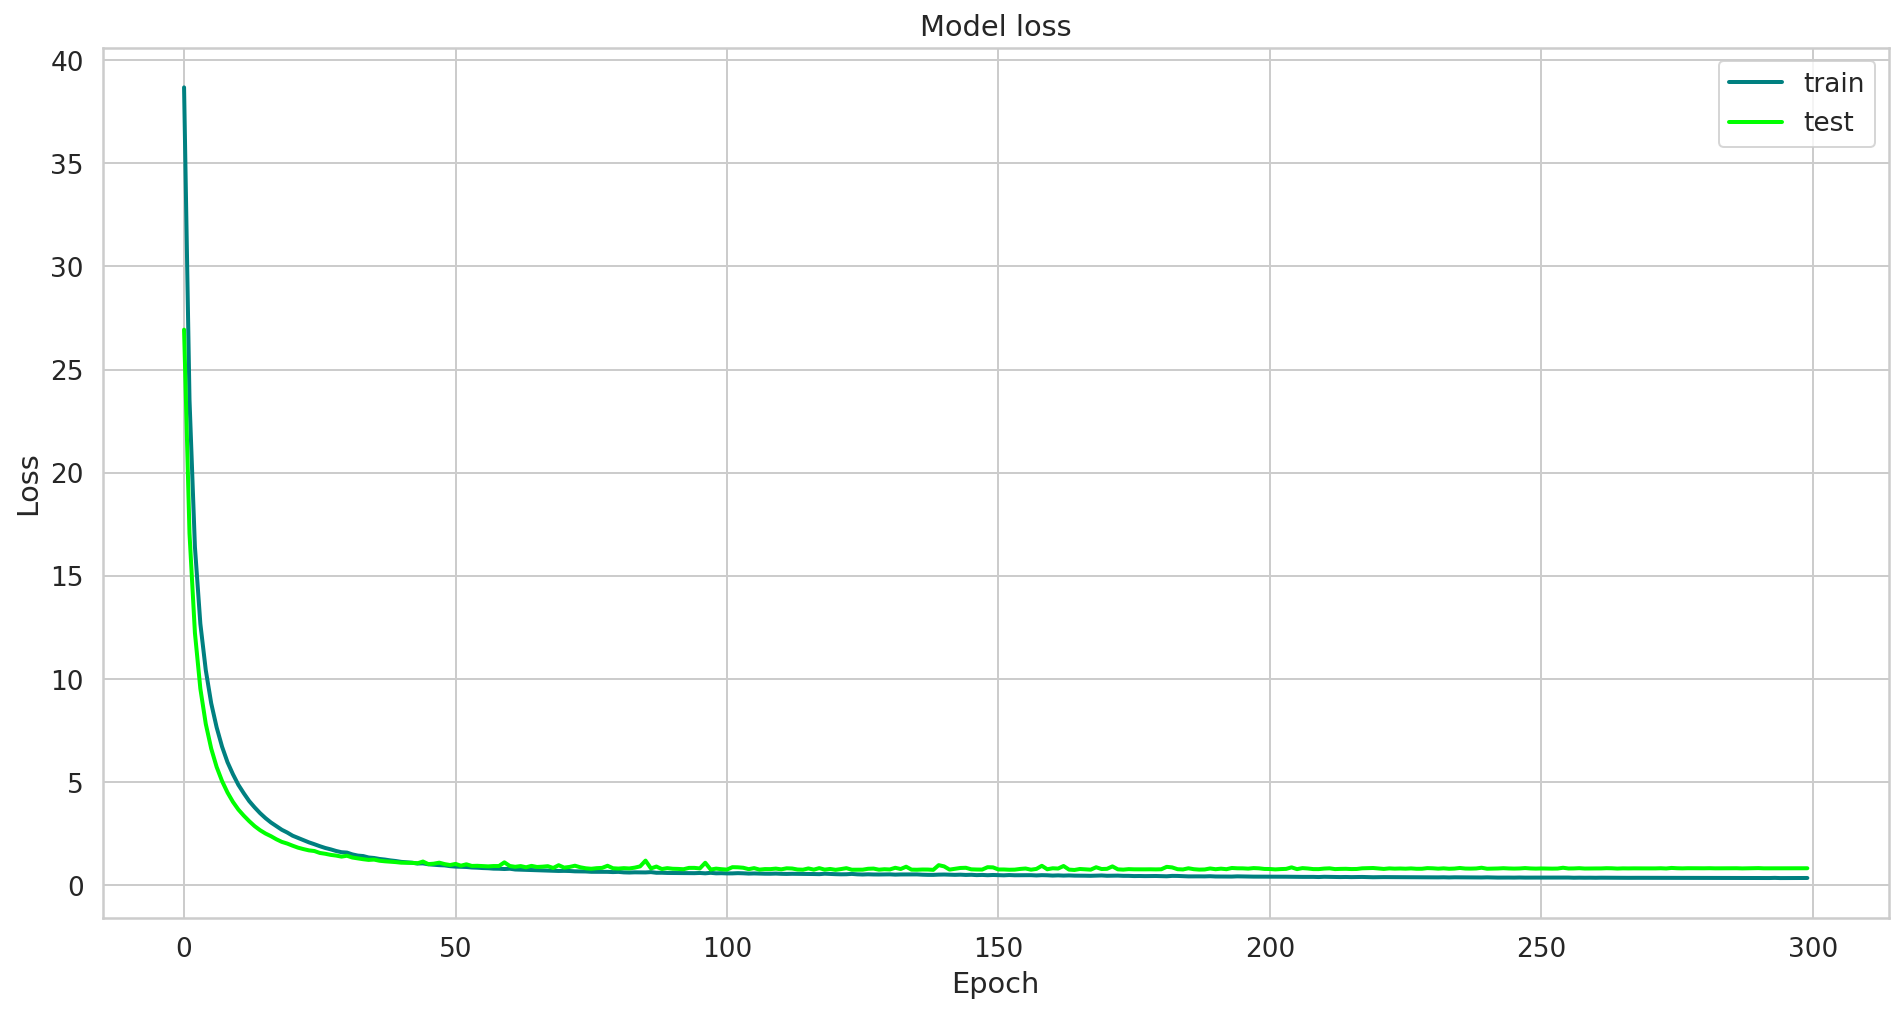

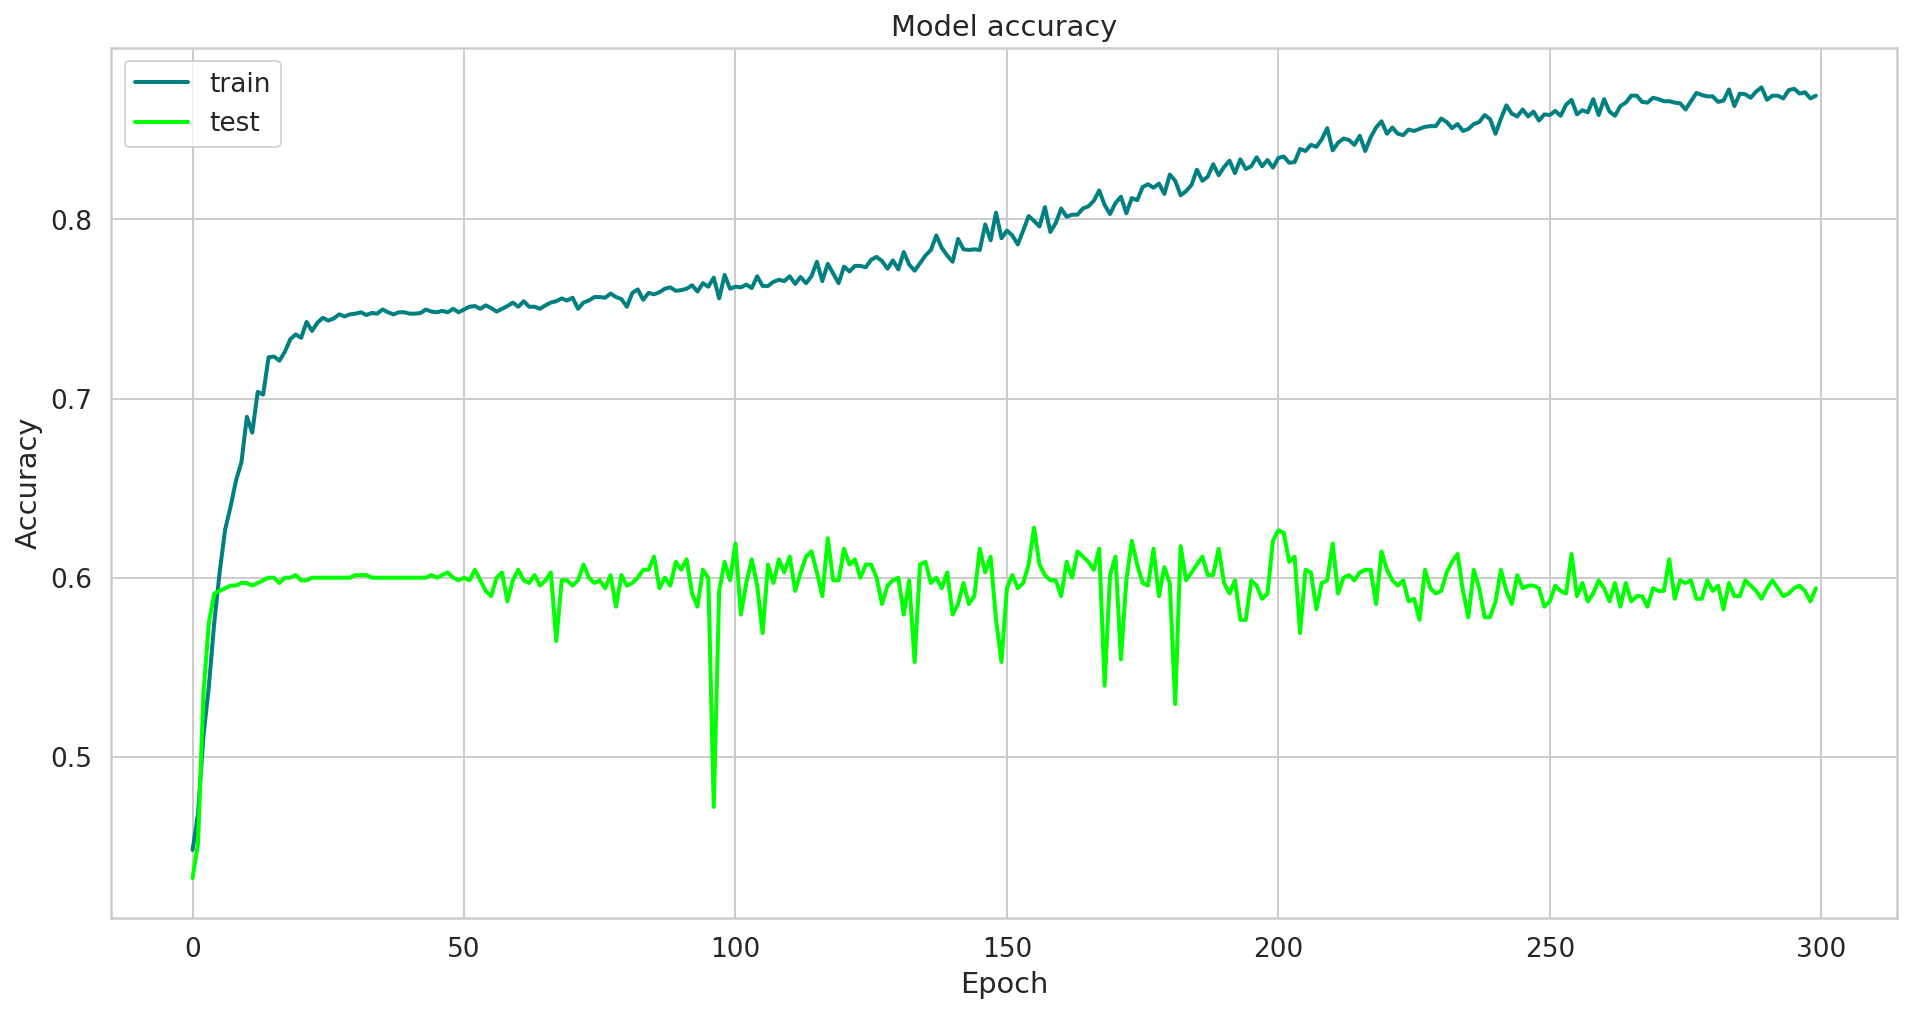

In [328]:
drow_ml_metrics(history_regul)

In [329]:
# Добавим слой Dropout (еще больше регуляризации)

In [330]:
model_drop = Sequential()
model_drop.add(Dense(64, input_dim=30, activity_regularizer=regularizers.l2(0.01)))
model_drop.add(BatchNormalization())
model_drop.add(LeakyReLU())

model_drop.add(Dropout(0.5))

model_drop.add(Dense(64, activity_regularizer=regularizers.l2(0.01)))
model_drop.add(BatchNormalization())
model_drop.add(LeakyReLU())


model_drop.add(Dense(2))
model_drop.add(Activation('softmax'))

In [331]:
opt = Nadam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

model_drop.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_drop = model_drop.fit(X_class_train, Y_class_train, 
                              nb_epoch = 120,
                              batch_size = 128, 
                              verbose=1, 
                              validation_data=(X_class_test, Y_class_test),
                              shuffle=True,
                              callbacks=[reduce_lr])

Train on 2589 samples, validate on 680 samples
Epoch 1/120
2589/2589 [==============================] - 1s 322us/step - loss: 117.6110 - accuracy: 0.5180 - val_loss: 42.2760 - val_accuracy: 0.5618
Epoch 2/120
2589/2589 [==============================] - 0s 39us/step - loss: 81.0142 - accuracy: 0.6122 - val_loss: 27.3643 - val_accuracy: 0.5676
Epoch 3/120
2589/2589 [==============================] - 0s 43us/step - loss: 59.1705 - accuracy: 0.6717 - val_loss: 19.7022 - val_accuracy: 0.5912
Epoch 4/120
2589/2589 [==============================] - 0s 40us/step - loss: 46.1821 - accuracy: 0.6813 - val_loss: 15.3018 - val_accuracy: 0.6029
Epoch 5/120
2589/2589 [==============================] - 0s 43us/step - loss: 36.8585 - accuracy: 0.7026 - val_loss: 12.4739 - val_accuracy: 0.6000
Epoch 6/120
2589/2589 [==============================] - 0s 38us/step - loss: 30.2508 - accuracy: 0.7169 - val_loss: 10.4678 - val_accuracy: 0.6000
Epoch 7/120
2589/2589 [==============================] - 0s 36u

2589/2589 [==============================] - 0s 49us/step - loss: 0.9011 - accuracy: 0.7462 - val_loss: 0.9311 - val_accuracy: 0.6000
Epoch 57/120
2589/2589 [==============================] - 0s 37us/step - loss: 0.8850 - accuracy: 0.7466 - val_loss: 0.9067 - val_accuracy: 0.6000
Epoch 58/120
2589/2589 [==============================] - 0s 32us/step - loss: 0.8637 - accuracy: 0.7466 - val_loss: 0.8929 - val_accuracy: 0.6000
Epoch 59/120
2589/2589 [==============================] - 0s 34us/step - loss: 0.8453 - accuracy: 0.7458 - val_loss: 0.8937 - val_accuracy: 0.6000
Epoch 60/120
2589/2589 [==============================] - 0s 34us/step - loss: 0.8287 - accuracy: 0.7455 - val_loss: 0.8800 - val_accuracy: 0.6000
Epoch 61/120
2589/2589 [==============================] - 0s 37us/step - loss: 0.8130 - accuracy: 0.7447 - val_loss: 0.8742 - val_accuracy: 0.6000
Epoch 62/120
2589/2589 [==============================] - 0s 37us/step - loss: 0.7978 - accuracy: 0.7458 - val_loss: 0.8640 - val_a

2589/2589 [==============================] - 0s 38us/step - loss: 0.5715 - accuracy: 0.7478 - val_loss: 0.7843 - val_accuracy: 0.5912
Epoch 112/120
2589/2589 [==============================] - 0s 50us/step - loss: 0.5749 - accuracy: 0.7462 - val_loss: 0.7436 - val_accuracy: 0.6000
Epoch 113/120
2589/2589 [==============================] - 0s 38us/step - loss: 0.5727 - accuracy: 0.7478 - val_loss: 0.7292 - val_accuracy: 0.6029

Epoch 00113: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
Epoch 114/120
2589/2589 [==============================] - 0s 42us/step - loss: 0.5780 - accuracy: 0.7528 - val_loss: 0.7243 - val_accuracy: 0.6015
Epoch 115/120
2589/2589 [==============================] - 0s 45us/step - loss: 0.5729 - accuracy: 0.7470 - val_loss: 0.7354 - val_accuracy: 0.5985
Epoch 116/120
2589/2589 [==============================] - 0s 49us/step - loss: 0.5723 - accuracy: 0.7482 - val_loss: 0.7517 - val_accuracy: 0.5985
Epoch 117/120
2589/2589 [====================

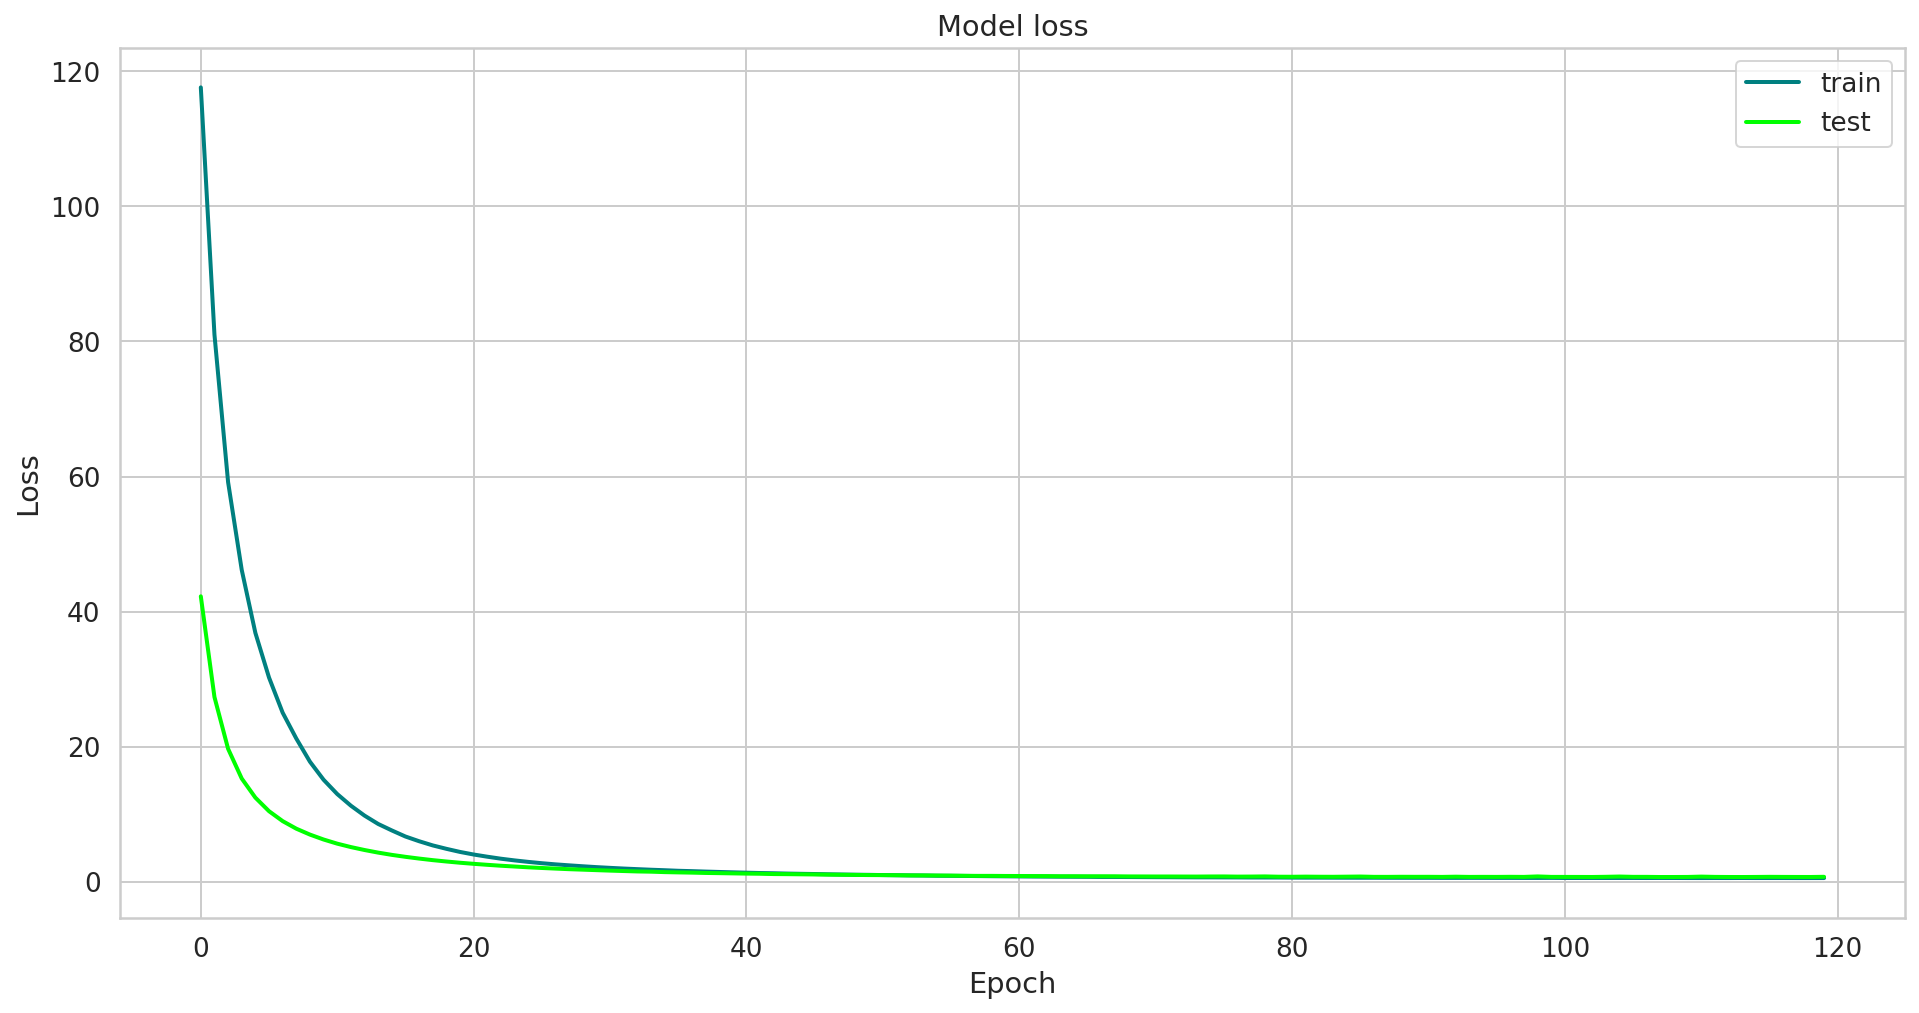

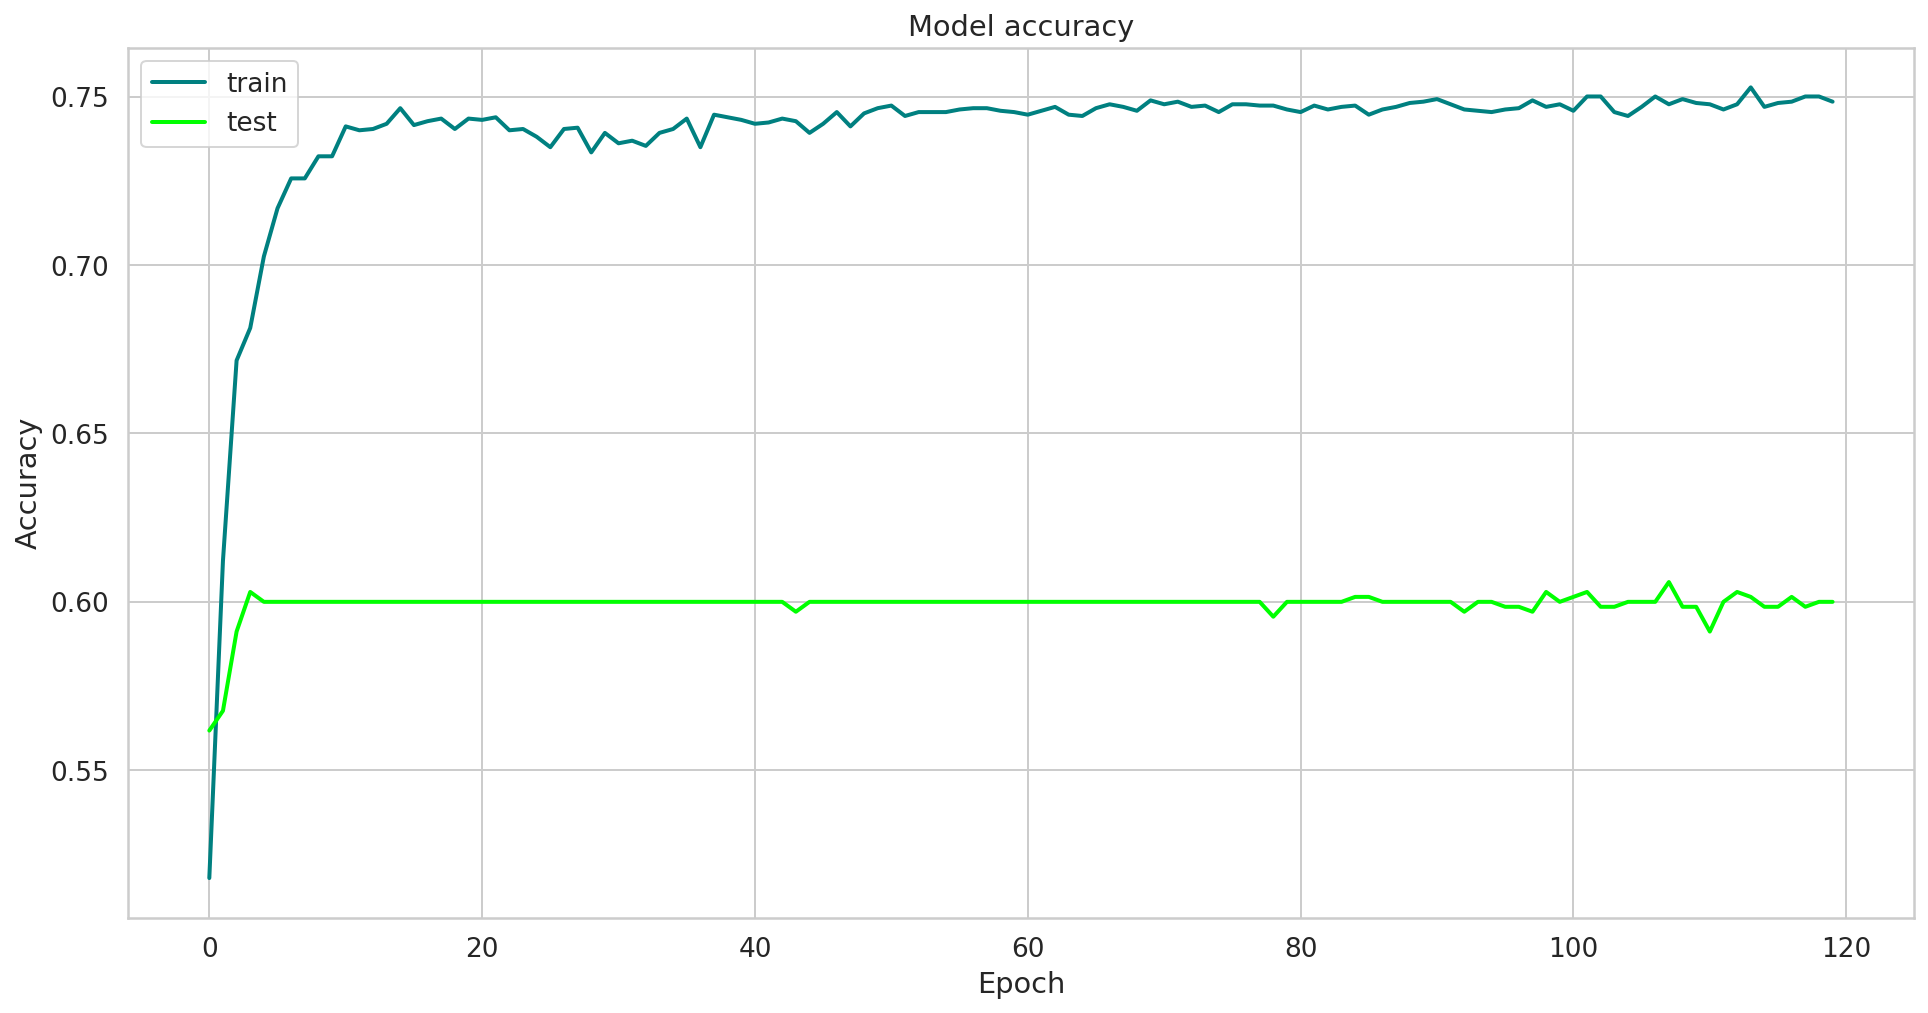

In [332]:
drow_ml_metrics(history_drop)

In [333]:
#регрессия

In [334]:
# Применем ту же сеть, кроме: 
# функцию активации заменим с softmax на linear,
# количество слоев в последнем нейроне заменим с 2х на 1
# loss c categorical_crossentropy заменим на mae, 
# увеличим количество эпох c 300 до 500
# данные не нормализуем

In [335]:
model_regr = Sequential()

model_regr.add(Dense(128, input_dim=30, activity_regularizer=regularizers.l2(0.01)))
model_regr.add(BatchNormalization())
model_regr.add(LeakyReLU())

model_regr.add(Dropout(0.5))

model_regr.add(Dense(4, activity_regularizer=regularizers.l2(0.01)))
model_regr.add(BatchNormalization())
model_regr.add(LeakyReLU())

model_regr.add(Dense(1))
model_regr.add(Activation('linear'))

In [336]:
opt = Nadam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

model_regr.compile(optimizer=opt, 
              loss='mae',
              metrics=['accuracy', 'mse', 'mae'])

In [337]:
history_regr = model_regr.fit(                  X_regr_train, Y_regr_train,
                              nb_epoch =        500,
                              batch_size =      128, 
                              verbose =         1, 
                              validation_data = (X_regr_test, Y_regr_test),
                              shuffle =         True,
                              callbacks =       [reduce_lr, checkpointer])

Train on 2589 samples, validate on 680 samples
Epoch 1/500
2589/2589 [==============================] - 1s 520us/step - loss: 21.9441 - accuracy: 7.7250e-04 - mse: 2.0334 - mae: 1.0920 - val_loss: 4.6044 - val_accuracy: 0.0000e+00 - val_mse: 0.5344 - val_mae: 0.7278

Epoch 00001: val_loss improved from inf to 4.60437, saving model to test.hdf5
Epoch 2/500
2589/2589 [==============================] - 0s 43us/step - loss: 5.4491 - accuracy: 0.0000e+00 - mse: 1.7753 - mae: 1.0228 - val_loss: 1.1466 - val_accuracy: 0.0000e+00 - val_mse: 0.4480 - val_mae: 0.6667

Epoch 00002: val_loss improved from 4.60437 to 1.14655, saving model to test.hdf5
Epoch 3/500
2589/2589 [==============================] - 0s 63us/step - loss: 2.5075 - accuracy: 3.8625e-04 - mse: 1.5783 - mae: 0.9445 - val_loss: 0.7084 - val_accuracy: 0.0000e+00 - val_mse: 0.3749 - val_mae: 0.6095

Epoch 00003: val_loss improved from 1.14655 to 0.70843, saving model to test.hdf5
Epoch 4/500
2589/2589 [=============================

2589/2589 [==============================] - 0s 50us/step - loss: 0.3017 - accuracy: 0.0031 - mse: 0.0567 - mae: 0.1144 - val_loss: 0.3527 - val_accuracy: 0.0000e+00 - val_mse: 0.0725 - val_mae: 0.2608

Epoch 00029: val_loss did not improve from 0.09162
Epoch 30/500
2589/2589 [==============================] - 0s 47us/step - loss: 0.2766 - accuracy: 0.0031 - mse: 0.0592 - mae: 0.1126 - val_loss: 0.1029 - val_accuracy: 0.0000e+00 - val_mse: 0.0045 - val_mae: 0.0521

Epoch 00030: val_loss did not improve from 0.09162
Epoch 31/500
2589/2589 [==============================] - 0s 43us/step - loss: 0.2696 - accuracy: 0.0031 - mse: 0.0488 - mae: 0.1119 - val_loss: 0.1328 - val_accuracy: 0.0000e+00 - val_mse: 0.0031 - val_mae: 0.0477

Epoch 00031: val_loss did not improve from 0.09162
Epoch 32/500
2589/2589 [==============================] - 0s 42us/step - loss: 0.2640 - accuracy: 0.0031 - mse: 0.0496 - mae: 0.1047 - val_loss: 0.3223 - val_accuracy: 0.0000e+00 - val_mse: 0.0131 - val_mae: 0.10

2589/2589 [==============================] - 0s 33us/step - loss: 0.1249 - accuracy: 0.0031 - mse: 0.0091 - mae: 0.0500 - val_loss: 0.0701 - val_accuracy: 0.0000e+00 - val_mse: 0.0013 - val_mae: 0.0332

Epoch 00058: val_loss did not improve from 0.04979
Epoch 59/500
2589/2589 [==============================] - 0s 36us/step - loss: 0.1309 - accuracy: 0.0031 - mse: 0.0122 - mae: 0.0517 - val_loss: 0.0914 - val_accuracy: 0.0000e+00 - val_mse: 0.0034 - val_mae: 0.0553

Epoch 00059: val_loss did not improve from 0.04979
Epoch 60/500
2589/2589 [==============================] - 0s 37us/step - loss: 0.1213 - accuracy: 0.0031 - mse: 0.0094 - mae: 0.0496 - val_loss: 0.1005 - val_accuracy: 0.0000e+00 - val_mse: 0.0042 - val_mae: 0.0618

Epoch 00060: val_loss did not improve from 0.04979
Epoch 61/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.1247 - accuracy: 0.0031 - mse: 0.0115 - mae: 0.0557 - val_loss: 0.1018 - val_accuracy: 0.0000e+00 - val_mse: 0.0081 - val_mae: 0.08

2589/2589 [==============================] - 0s 31us/step - loss: 0.0858 - accuracy: 0.0031 - mse: 0.0046 - mae: 0.0376 - val_loss: 0.0986 - val_accuracy: 0.0000e+00 - val_mse: 0.0033 - val_mae: 0.0553

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.

Epoch 00087: val_loss did not improve from 0.01878
Epoch 88/500
2589/2589 [==============================] - 0s 37us/step - loss: 0.0898 - accuracy: 0.0031 - mse: 0.0055 - mae: 0.0394 - val_loss: 0.0344 - val_accuracy: 0.0000e+00 - val_mse: 7.6725e-04 - val_mae: 0.0251

Epoch 00088: val_loss did not improve from 0.01878
Epoch 89/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0904 - accuracy: 0.0031 - mse: 0.0054 - mae: 0.0413 - val_loss: 0.0240 - val_accuracy: 0.0000e+00 - val_mse: 4.2291e-04 - val_mae: 0.0176

Epoch 00089: val_loss did not improve from 0.01878
Epoch 90/500
2589/2589 [==============================] - 0s 38us/step - loss: 0.0885 - accuracy: 0.0031 - mse: 0.0073 - ma


Epoch 00115: val_loss did not improve from 0.01252
Epoch 116/500
2589/2589 [==============================] - 0s 39us/step - loss: 0.0750 - accuracy: 0.0031 - mse: 0.0047 - mae: 0.0353 - val_loss: 0.0131 - val_accuracy: 0.0000e+00 - val_mse: 9.1451e-05 - val_mae: 0.0075

Epoch 00116: val_loss did not improve from 0.01252
Epoch 117/500
2589/2589 [==============================] - 0s 39us/step - loss: 0.0739 - accuracy: 0.0031 - mse: 0.0039 - mae: 0.0339 - val_loss: 0.0128 - val_accuracy: 0.0000e+00 - val_mse: 1.2149e-04 - val_mae: 0.0079

Epoch 00117: val_loss did not improve from 0.01252
Epoch 118/500
2589/2589 [==============================] - 0s 34us/step - loss: 0.0717 - accuracy: 0.0031 - mse: 0.0035 - mae: 0.0335 - val_loss: 0.0219 - val_accuracy: 0.0000e+00 - val_mse: 3.8749e-04 - val_mae: 0.0178

Epoch 00118: val_loss did not improve from 0.01252
Epoch 119/500
2589/2589 [==============================] - 0s 34us/step - loss: 0.0737 - accuracy: 0.0031 - mse: 0.0045 - mae: 0.035

2589/2589 [==============================] - 0s 36us/step - loss: 0.0678 - accuracy: 0.0031 - mse: 0.0039 - mae: 0.0319 - val_loss: 0.0196 - val_accuracy: 0.0000e+00 - val_mse: 2.8679e-04 - val_mae: 0.0151

Epoch 00144: ReduceLROnPlateau reducing learning rate to 9.847709443420172e-05.

Epoch 00144: val_loss did not improve from 0.01252
Epoch 145/500
2589/2589 [==============================] - 0s 36us/step - loss: 0.0667 - accuracy: 0.0031 - mse: 0.0035 - mae: 0.0311 - val_loss: 0.0159 - val_accuracy: 0.0000e+00 - val_mse: 1.8803e-04 - val_mae: 0.0119

Epoch 00145: val_loss did not improve from 0.01252
Epoch 146/500
2589/2589 [==============================] - 0s 41us/step - loss: 0.0658 - accuracy: 0.0031 - mse: 0.0034 - mae: 0.0312 - val_loss: 0.0141 - val_accuracy: 0.0000e+00 - val_mse: 1.2821e-04 - val_mae: 0.0087

Epoch 00146: val_loss did not improve from 0.01252
Epoch 147/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0664 - accuracy: 0.0031 - mse: 0.00

2589/2589 [==============================] - 0s 30us/step - loss: 0.0617 - accuracy: 0.0031 - mse: 0.0034 - mae: 0.0304 - val_loss: 0.0152 - val_accuracy: 0.0000e+00 - val_mse: 1.6111e-04 - val_mae: 0.0114

Epoch 00172: val_loss did not improve from 0.01252
Epoch 173/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0636 - accuracy: 0.0031 - mse: 0.0032 - mae: 0.0316 - val_loss: 0.0279 - val_accuracy: 0.0000e+00 - val_mse: 7.0698e-04 - val_mae: 0.0246

Epoch 00173: val_loss did not improve from 0.01252
Epoch 174/500
2589/2589 [==============================] - 0s 43us/step - loss: 0.0612 - accuracy: 0.0031 - mse: 0.0027 - mae: 0.0298 - val_loss: 0.0129 - val_accuracy: 0.0000e+00 - val_mse: 1.4893e-04 - val_mae: 0.0088

Epoch 00174: ReduceLROnPlateau reducing learning rate to 5.233476658759173e-05.

Epoch 00174: val_loss did not improve from 0.01252
Epoch 175/500
2589/2589 [==============================] - 0s 32us/step - loss: 0.0630 - accuracy: 0.0031 - mse: 0.00


Epoch 00200: val_loss did not improve from 0.01202
Epoch 201/500
2589/2589 [==============================] - 0s 40us/step - loss: 0.0599 - accuracy: 0.0031 - mse: 0.0024 - mae: 0.0291 - val_loss: 0.0149 - val_accuracy: 0.0000e+00 - val_mse: 1.5282e-04 - val_mae: 0.0111

Epoch 00201: val_loss did not improve from 0.01202
Epoch 202/500
2589/2589 [==============================] - 0s 32us/step - loss: 0.0564 - accuracy: 0.0031 - mse: 0.0024 - mae: 0.0265 - val_loss: 0.0140 - val_accuracy: 0.0000e+00 - val_mse: 1.6572e-04 - val_mae: 0.0098

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.0903160222806036e-05.

Epoch 00202: val_loss did not improve from 0.01202
Epoch 203/500
2589/2589 [==============================] - 0s 37us/step - loss: 0.0583 - accuracy: 0.0031 - mse: 0.0026 - mae: 0.0281 - val_loss: 0.0198 - val_accuracy: 0.0000e+00 - val_mse: 3.0820e-04 - val_mae: 0.0158

Epoch 00203: val_loss did not improve from 0.01202
Epoch 204/500
2589/2589 [=========================

2589/2589 [==============================] - 0s 40us/step - loss: 0.0590 - accuracy: 0.0031 - mse: 0.0026 - mae: 0.0288 - val_loss: 0.0163 - val_accuracy: 0.0000e+00 - val_mse: 1.8872e-04 - val_mae: 0.0125

Epoch 00229: val_loss did not improve from 0.01202
Epoch 230/500
2589/2589 [==============================] - 0s 53us/step - loss: 0.0586 - accuracy: 0.0031 - mse: 0.0029 - mae: 0.0279 - val_loss: 0.0195 - val_accuracy: 0.0000e+00 - val_mse: 3.1733e-04 - val_mae: 0.0160

Epoch 00230: val_loss did not improve from 0.01202
Epoch 231/500
2589/2589 [==============================] - 0s 51us/step - loss: 0.0597 - accuracy: 0.0031 - mse: 0.0028 - mae: 0.0296 - val_loss: 0.0159 - val_accuracy: 0.0000e+00 - val_mse: 1.7993e-04 - val_mae: 0.0122

Epoch 00231: val_loss did not improve from 0.01202
Epoch 232/500
2589/2589 [==============================] - 0s 57us/step - loss: 0.0576 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0278 - val_loss: 0.0141 - val_accuracy: 0.0000e+00 - val_mse: 1.4117e


Epoch 00257: ReduceLROnPlateau reducing learning rate to 9.697739187686238e-06.

Epoch 00257: val_loss did not improve from 0.01202
Epoch 258/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0561 - accuracy: 0.0031 - mse: 0.0025 - mae: 0.0278 - val_loss: 0.0136 - val_accuracy: 0.0000e+00 - val_mse: 1.3459e-04 - val_mae: 0.0098

Epoch 00258: val_loss did not improve from 0.01202
Epoch 259/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0569 - accuracy: 0.0031 - mse: 0.0023 - mae: 0.0275 - val_loss: 0.0165 - val_accuracy: 0.0000e+00 - val_mse: 2.0114e-04 - val_mae: 0.0129

Epoch 00259: val_loss did not improve from 0.01202
Epoch 260/500
2589/2589 [==============================] - 0s 44us/step - loss: 0.0559 - accuracy: 0.0031 - mse: 0.0027 - mae: 0.0275 - val_loss: 0.0181 - val_accuracy: 0.0000e+00 - val_mse: 2.5919e-04 - val_mae: 0.0146

Epoch 00260: val_loss did not improve from 0.01202
Epoch 261/500
2589/2589 [==========================

2589/2589 [==============================] - 0s 52us/step - loss: 0.0563 - accuracy: 0.0031 - mse: 0.0024 - mae: 0.0271 - val_loss: 0.0162 - val_accuracy: 0.0000e+00 - val_mse: 1.9525e-04 - val_mae: 0.0127

Epoch 00286: val_loss did not improve from 0.01202
Epoch 287/500
2589/2589 [==============================] - 0s 40us/step - loss: 0.0572 - accuracy: 0.0031 - mse: 0.0027 - mae: 0.0279 - val_loss: 0.0146 - val_accuracy: 0.0000e+00 - val_mse: 1.5014e-04 - val_mae: 0.0110

Epoch 00287: ReduceLROnPlateau reducing learning rate to 5.15377605552203e-06.

Epoch 00287: val_loss did not improve from 0.01202
Epoch 288/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0571 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0277 - val_loss: 0.0145 - val_accuracy: 0.0000e+00 - val_mse: 1.4951e-04 - val_mae: 0.0108

Epoch 00288: val_loss did not improve from 0.01202
Epoch 289/500
2589/2589 [==============================] - 0s 34us/step - loss: 0.0558 - accuracy: 0.0031 - mse: 0.002

2589/2589 [==============================] - 0s 31us/step - loss: 0.0570 - accuracy: 0.0031 - mse: 0.0024 - mae: 0.0282 - val_loss: 0.0156 - val_accuracy: 0.0000e+00 - val_mse: 1.7367e-04 - val_mae: 0.0120

Epoch 00314: val_loss did not improve from 0.01202
Epoch 315/500
2589/2589 [==============================] - 0s 33us/step - loss: 0.0553 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0267 - val_loss: 0.0160 - val_accuracy: 0.0000e+00 - val_mse: 1.8402e-04 - val_mae: 0.0124

Epoch 00315: val_loss did not improve from 0.01202
Epoch 316/500
2589/2589 [==============================] - 0s 33us/step - loss: 0.0568 - accuracy: 0.0031 - mse: 0.0028 - mae: 0.0276 - val_loss: 0.0167 - val_accuracy: 0.0000e+00 - val_mse: 2.1401e-04 - val_mae: 0.0132

Epoch 00316: val_loss did not improve from 0.01202
Epoch 317/500
2589/2589 [==============================] - 0s 34us/step - loss: 0.0537 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0259 - val_loss: 0.0165 - val_accuracy: 0.0000e+00 - val_mse: 2.0570e


Epoch 00342: ReduceLROnPlateau reducing learning rate to 1.6173093968063768e-06.

Epoch 00342: val_loss did not improve from 0.01202
Epoch 343/500
2589/2589 [==============================] - 0s 48us/step - loss: 0.0556 - accuracy: 0.0031 - mse: 0.0028 - mae: 0.0267 - val_loss: 0.0155 - val_accuracy: 0.0000e+00 - val_mse: 1.7162e-04 - val_mae: 0.0119

Epoch 00343: val_loss did not improve from 0.01202
Epoch 344/500
2589/2589 [==============================] - 0s 31us/step - loss: 0.0556 - accuracy: 0.0031 - mse: 0.0032 - mae: 0.0271 - val_loss: 0.0156 - val_accuracy: 0.0000e+00 - val_mse: 1.7516e-04 - val_mae: 0.0120

Epoch 00344: val_loss did not improve from 0.01202
Epoch 345/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0550 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0260 - val_loss: 0.0159 - val_accuracy: 0.0000e+00 - val_mse: 1.8339e-04 - val_mae: 0.0123

Epoch 00345: val_loss did not improve from 0.01202
Epoch 346/500
2589/2589 [=========================

2589/2589 [==============================] - 0s 34us/step - loss: 0.0566 - accuracy: 0.0031 - mse: 0.0024 - mae: 0.0288 - val_loss: 0.0157 - val_accuracy: 0.0000e+00 - val_mse: 1.7708e-04 - val_mae: 0.0121

Epoch 00371: val_loss did not improve from 0.01202
Epoch 372/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0547 - accuracy: 0.0031 - mse: 0.0020 - mae: 0.0266 - val_loss: 0.0154 - val_accuracy: 0.0000e+00 - val_mse: 1.6793e-04 - val_mae: 0.0118

Epoch 00372: val_loss did not improve from 0.01202
Epoch 373/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0582 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0295 - val_loss: 0.0154 - val_accuracy: 0.0000e+00 - val_mse: 1.6952e-04 - val_mae: 0.0118

Epoch 00373: val_loss did not improve from 0.01202
Epoch 374/500
2589/2589 [==============================] - 0s 33us/step - loss: 0.0585 - accuracy: 0.0031 - mse: 0.0029 - mae: 0.0298 - val_loss: 0.0158 - val_accuracy: 0.0000e+00 - val_mse: 1.7999e

2589/2589 [==============================] - 0s 34us/step - loss: 0.0574 - accuracy: 0.0031 - mse: 0.0029 - mae: 0.0286 - val_loss: 0.0164 - val_accuracy: 0.0000e+00 - val_mse: 2.0085e-04 - val_mae: 0.0129

Epoch 00401: val_loss did not improve from 0.01202
Epoch 402/500
2589/2589 [==============================] - 0s 34us/step - loss: 0.0557 - accuracy: 0.0031 - mse: 0.0021 - mae: 0.0269 - val_loss: 0.0163 - val_accuracy: 0.0000e+00 - val_mse: 1.9540e-04 - val_mae: 0.0127

Epoch 00402: val_loss did not improve from 0.01202
Epoch 403/500
2589/2589 [==============================] - 0s 32us/step - loss: 0.0545 - accuracy: 0.0031 - mse: 0.0019 - mae: 0.0260 - val_loss: 0.0162 - val_accuracy: 0.0000e+00 - val_mse: 1.9061e-04 - val_mae: 0.0126

Epoch 00403: val_loss did not improve from 0.01202
Epoch 404/500
2589/2589 [==============================] - 0s 33us/step - loss: 0.0556 - accuracy: 0.0031 - mse: 0.0025 - mae: 0.0266 - val_loss: 0.0160 - val_accuracy: 0.0000e+00 - val_mse: 1.8719e

2589/2589 [==============================] - 0s 28us/step - loss: 0.0564 - accuracy: 0.0031 - mse: 0.0025 - mae: 0.0277 - val_loss: 0.0157 - val_accuracy: 0.0000e+00 - val_mse: 1.7706e-04 - val_mae: 0.0121

Epoch 00431: val_loss did not improve from 0.01202
Epoch 432/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0562 - accuracy: 0.0031 - mse: 0.0020 - mae: 0.0269 - val_loss: 0.0161 - val_accuracy: 0.0000e+00 - val_mse: 1.8947e-04 - val_mae: 0.0125

Epoch 00432: val_loss did not improve from 0.01202
Epoch 433/500
2589/2589 [==============================] - 0s 33us/step - loss: 0.0563 - accuracy: 0.0031 - mse: 0.0023 - mae: 0.0266 - val_loss: 0.0169 - val_accuracy: 0.0000e+00 - val_mse: 2.1756e-04 - val_mae: 0.0134

Epoch 00433: val_loss did not improve from 0.01202
Epoch 434/500
2589/2589 [==============================] - 0s 30us/step - loss: 0.0569 - accuracy: 0.0031 - mse: 0.0029 - mae: 0.0285 - val_loss: 0.0164 - val_accuracy: 0.0000e+00 - val_mse: 2.0222e

2589/2589 [==============================] - 0s 36us/step - loss: 0.0561 - accuracy: 0.0031 - mse: 0.0021 - mae: 0.0280 - val_loss: 0.0161 - val_accuracy: 0.0000e+00 - val_mse: 1.8864e-04 - val_mae: 0.0125

Epoch 00461: val_loss did not improve from 0.01202
Epoch 462/500
2589/2589 [==============================] - 0s 38us/step - loss: 0.0566 - accuracy: 0.0031 - mse: 0.0026 - mae: 0.0284 - val_loss: 0.0163 - val_accuracy: 0.0000e+00 - val_mse: 1.9669e-04 - val_mae: 0.0128

Epoch 00462: val_loss did not improve from 0.01202
Epoch 463/500
2589/2589 [==============================] - 0s 34us/step - loss: 0.0554 - accuracy: 0.0031 - mse: 0.0021 - mae: 0.0263 - val_loss: 0.0162 - val_accuracy: 0.0000e+00 - val_mse: 1.9428e-04 - val_mae: 0.0127

Epoch 00463: val_loss did not improve from 0.01202
Epoch 464/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0571 - accuracy: 0.0031 - mse: 0.0025 - mae: 0.0287 - val_loss: 0.0164 - val_accuracy: 0.0000e+00 - val_mse: 2.0172e

2589/2589 [==============================] - 0s 39us/step - loss: 0.0554 - accuracy: 0.0031 - mse: 0.0020 - mae: 0.0272 - val_loss: 0.0163 - val_accuracy: 0.0000e+00 - val_mse: 1.9790e-04 - val_mae: 0.0128

Epoch 00491: val_loss did not improve from 0.01202
Epoch 492/500
2589/2589 [==============================] - 0s 33us/step - loss: 0.0552 - accuracy: 0.0031 - mse: 0.0026 - mae: 0.0274 - val_loss: 0.0164 - val_accuracy: 0.0000e+00 - val_mse: 2.0252e-04 - val_mae: 0.0129

Epoch 00492: val_loss did not improve from 0.01202
Epoch 493/500
2589/2589 [==============================] - 0s 38us/step - loss: 0.0557 - accuracy: 0.0031 - mse: 0.0021 - mae: 0.0271 - val_loss: 0.0160 - val_accuracy: 0.0000e+00 - val_mse: 1.9020e-04 - val_mae: 0.0125

Epoch 00493: val_loss did not improve from 0.01202
Epoch 494/500
2589/2589 [==============================] - 0s 35us/step - loss: 0.0558 - accuracy: 0.0031 - mse: 0.0022 - mae: 0.0271 - val_loss: 0.0155 - val_accuracy: 0.0000e+00 - val_mse: 1.7236e

In [338]:
predict_regr = model_regr.predict(np.array(X_regr_test))

In [339]:
dates = pd.date_range('20180201',periods=len(Y_regr_test))
df_test = pd.DataFrame(Y_regr_test,  index = dates)
df_pred = pd.DataFrame(predict_regr, index = dates)

 r2: 0.95 
 rmse: 0.01 
 mae: 0.01


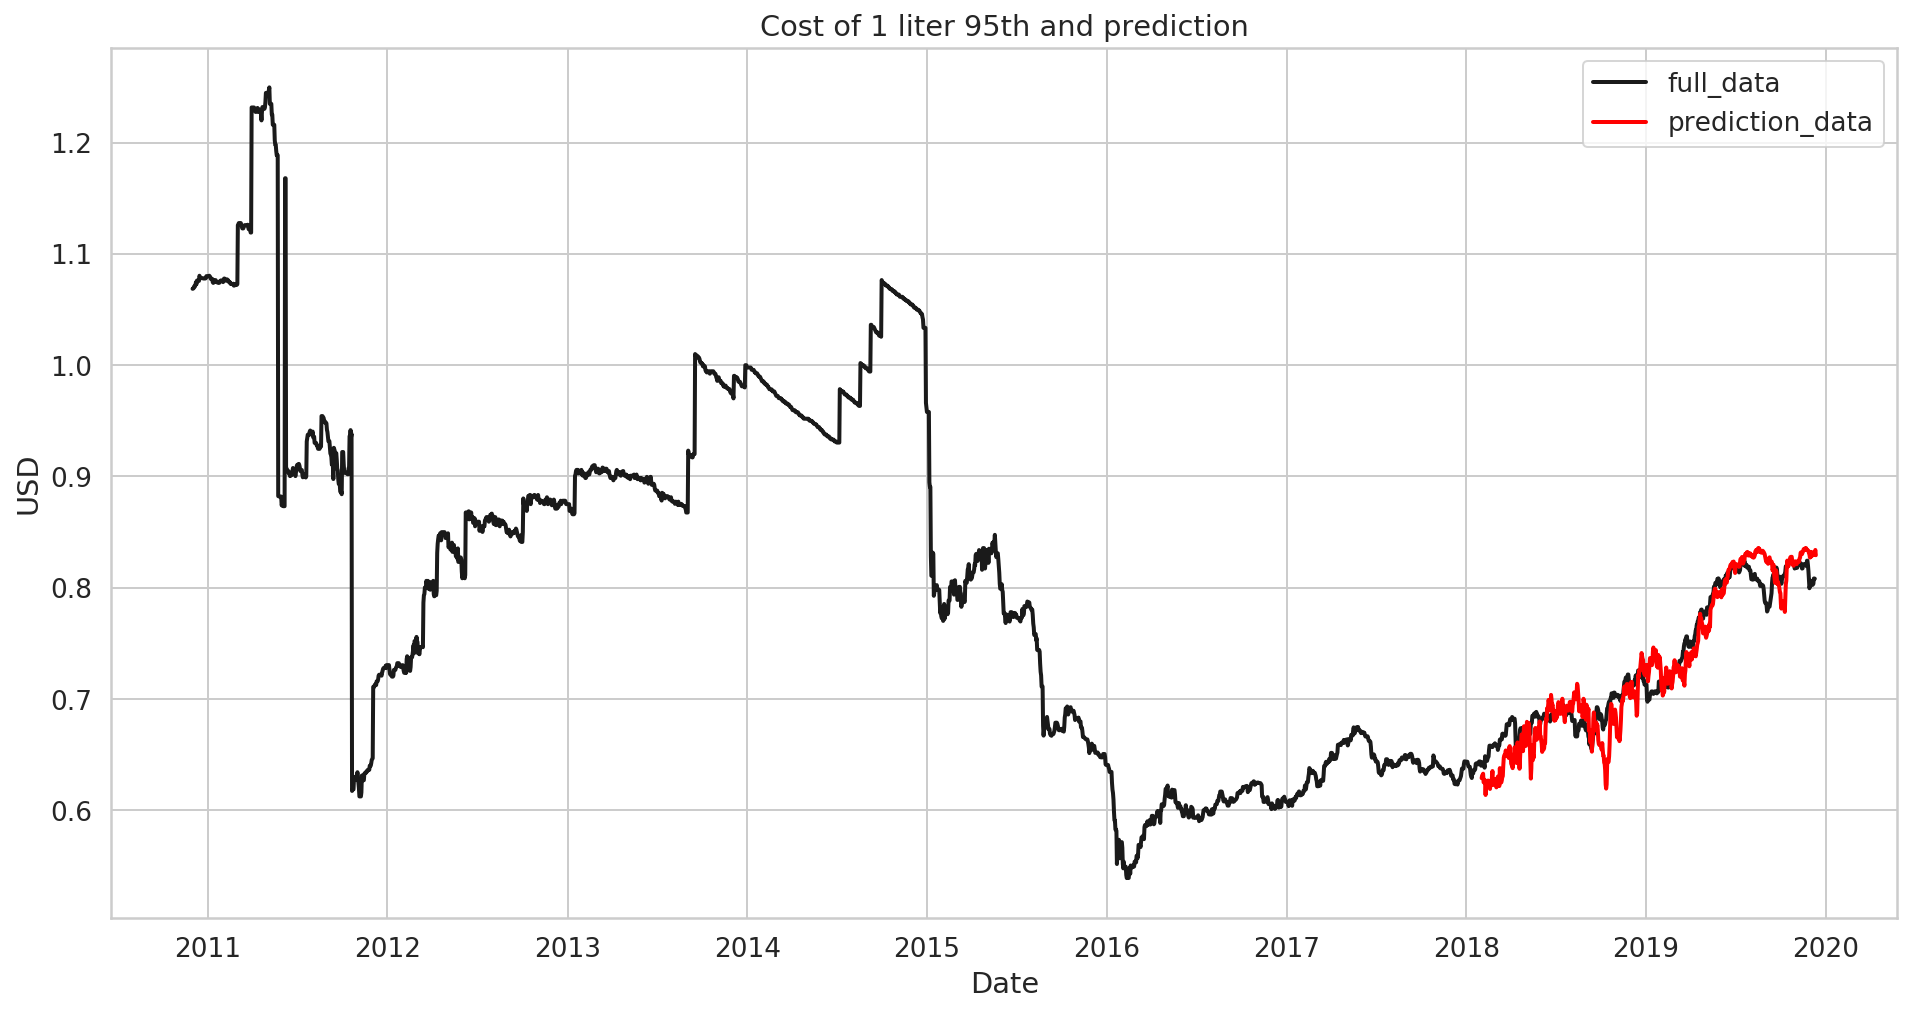

In [350]:
r2_regr, rmse_regr, mae_regr = describe_prediction(data['USD_by_liter'], df_test, df_pred)

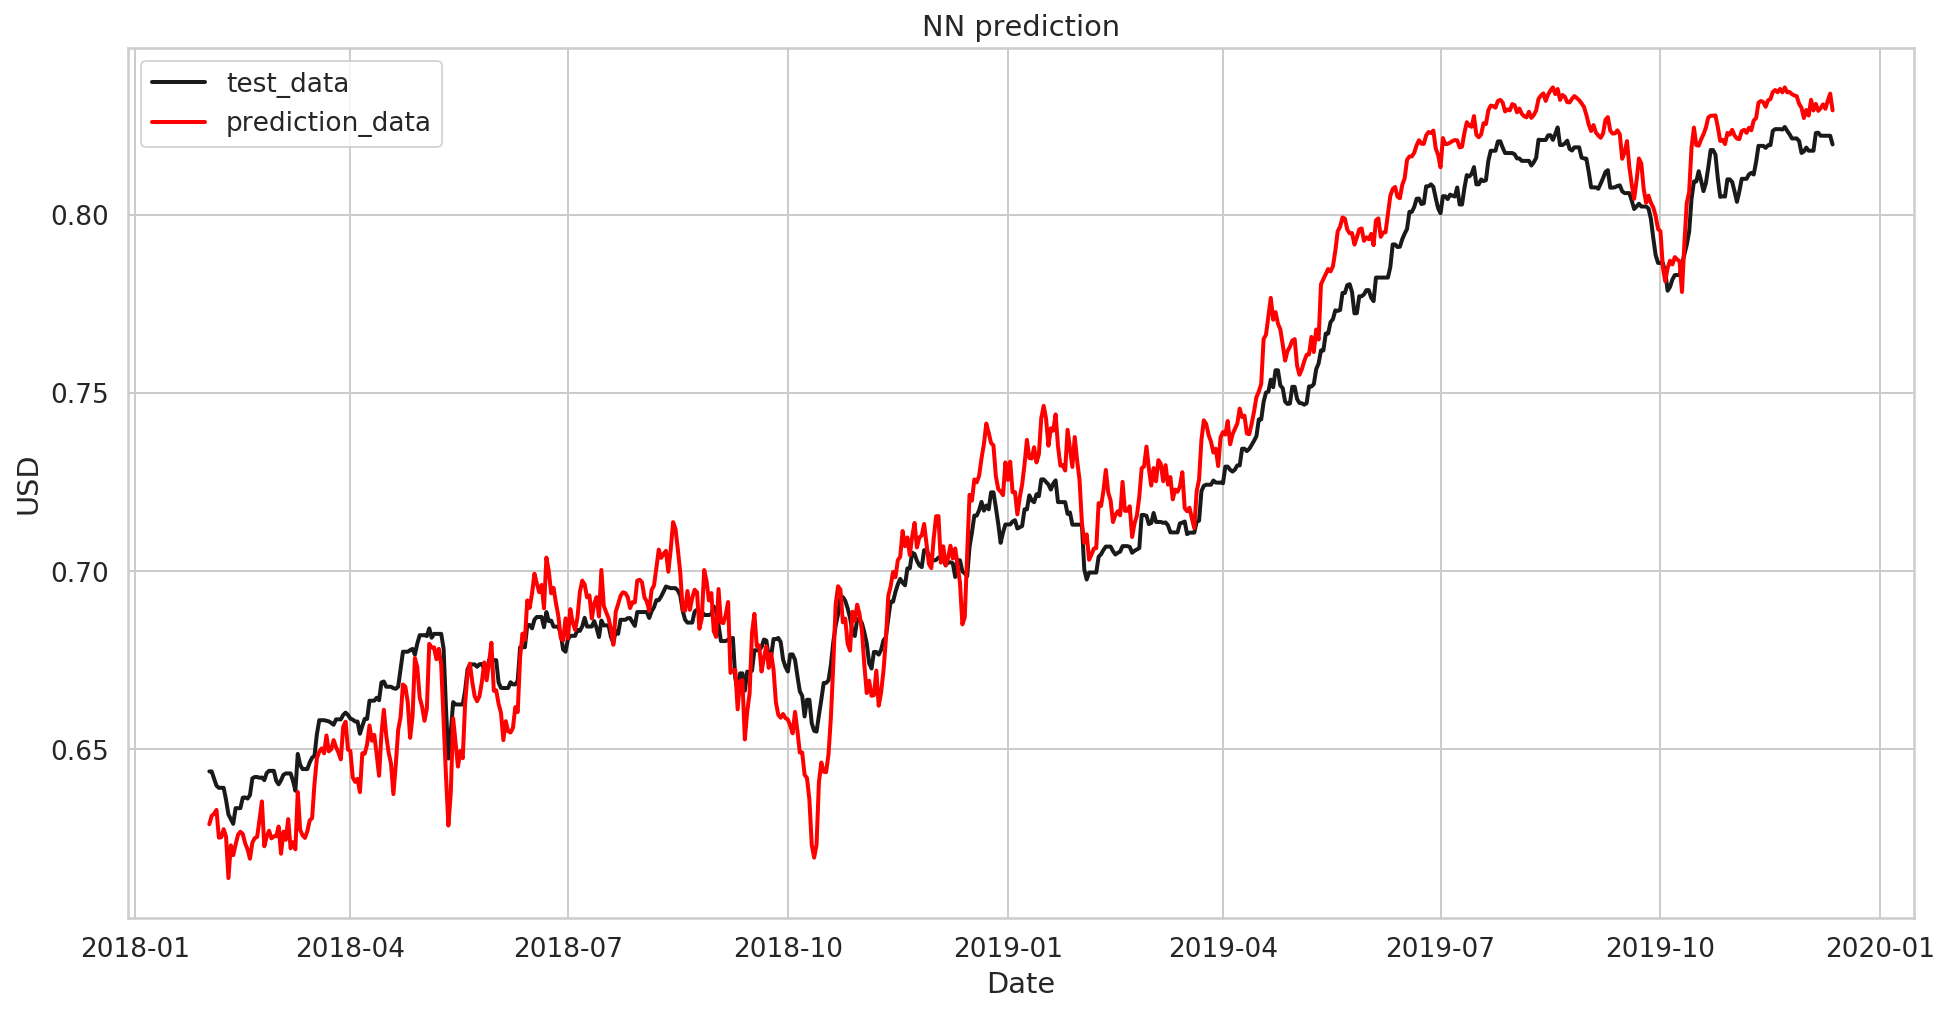

In [366]:
fig, ax = plt.subplots()

ax.plot(df_test, c='k', linewidth = 2)
ax.plot(df_pred, c='#FF0000', linewidth = 2)

plt.title('NN prediction')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(['test_data','prediction_data'])

In [367]:
def feature_maker(model_name, day_set, next_data, count_days):
    
    feature_data = []
    
    for i in range(count_days):
        next_day_prediction = model_regr.predict(day_set)   
        day_set = np.append(day_set, next_day_prediction)
        day_set = np.delete(day_set, [0])
        day_set = np.array([day_set,])
        feature_data.append(next_day_prediction[0])
        
    df_feature = pd.DataFrame(data = feature_data, 
                              index = pd.date_range(next_data,periods=count_days), 
                             columns = ['USD_by_litter'])
    
    return df_feature

In [368]:
feature = feature_maker(model_name   = model_regr,
                        day_set      = np.array([X_regr_test[679],]), # last day set 2019-12-10
                        next_data    = '20191211',
                        count_days   = 365)

Text(0.5, 0, 'Date')

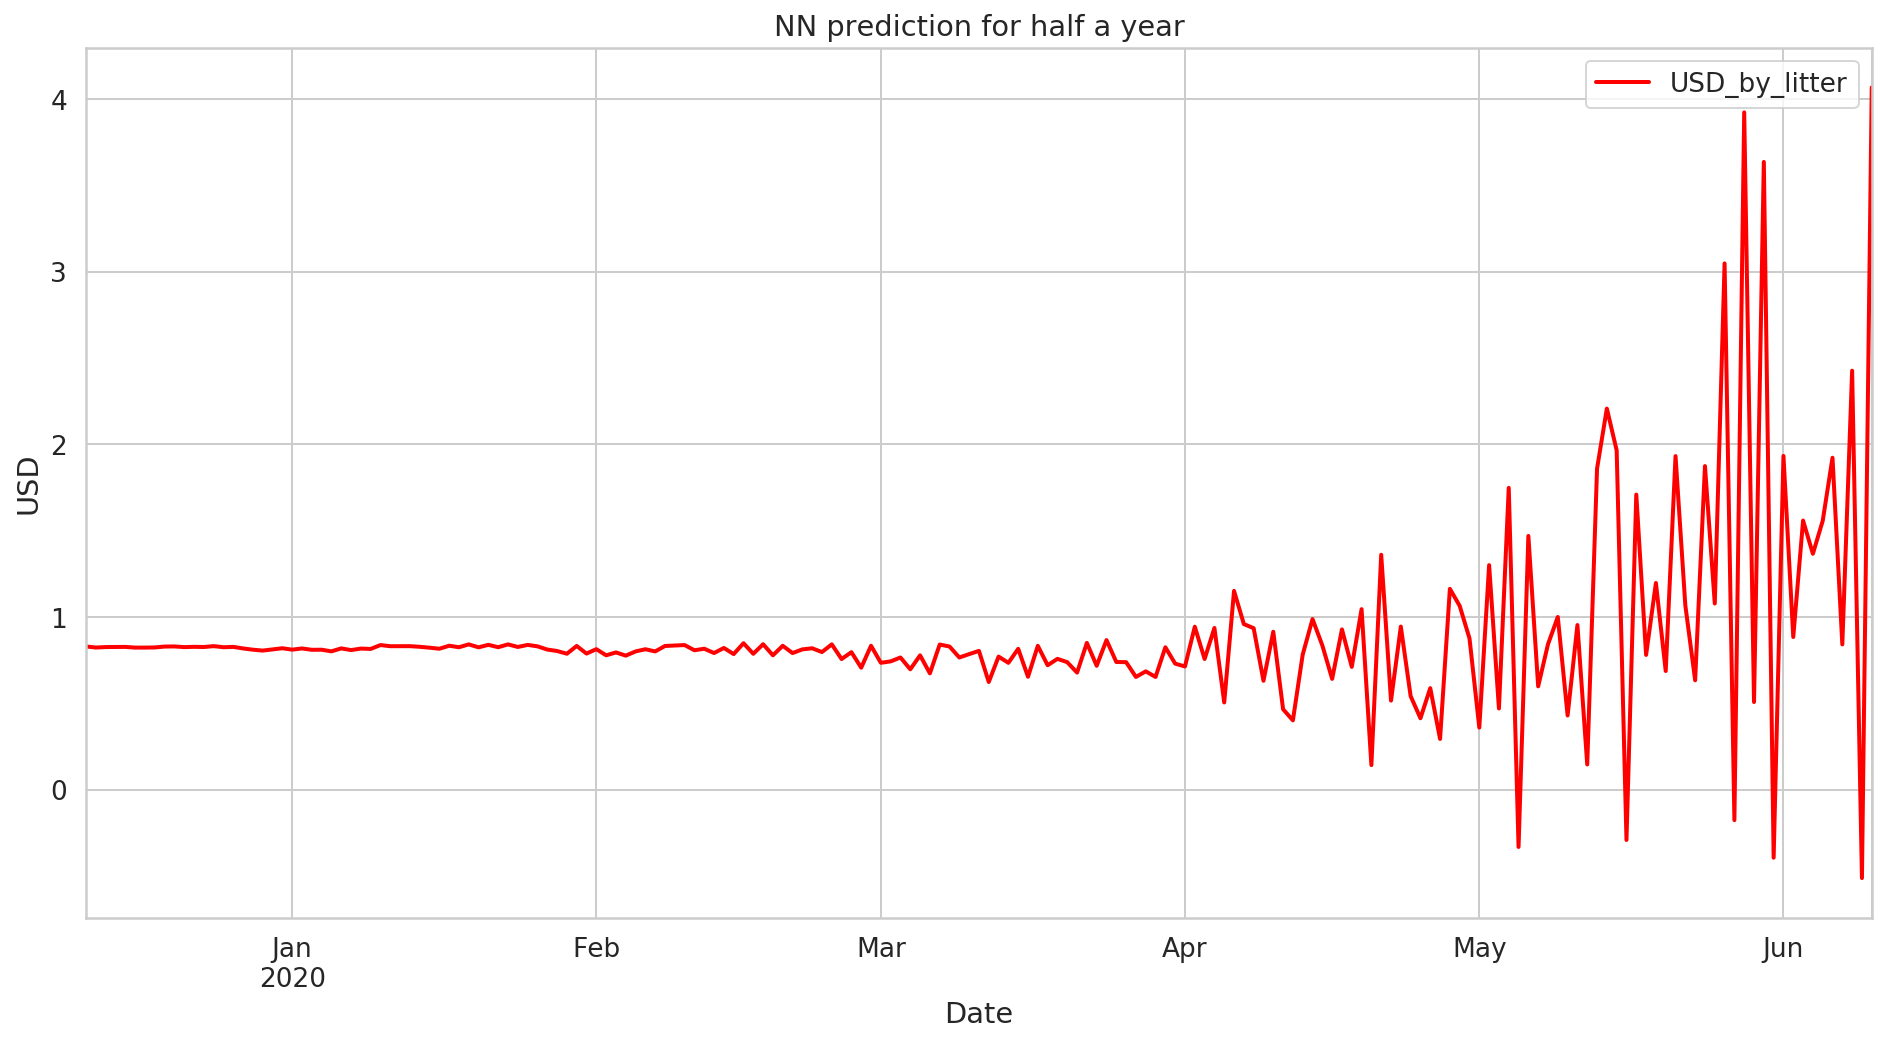

In [370]:
feature[0:183].plot(c='#FF0000', linewidth = 2)

plt.title('NN prediction for half a year')
plt.ylabel('USD')
plt.xlabel('Date')

In [371]:
# не смотря на хорошие показатели, на долгосрочные прогнозы модель не способна

In [166]:
# остатки от NN

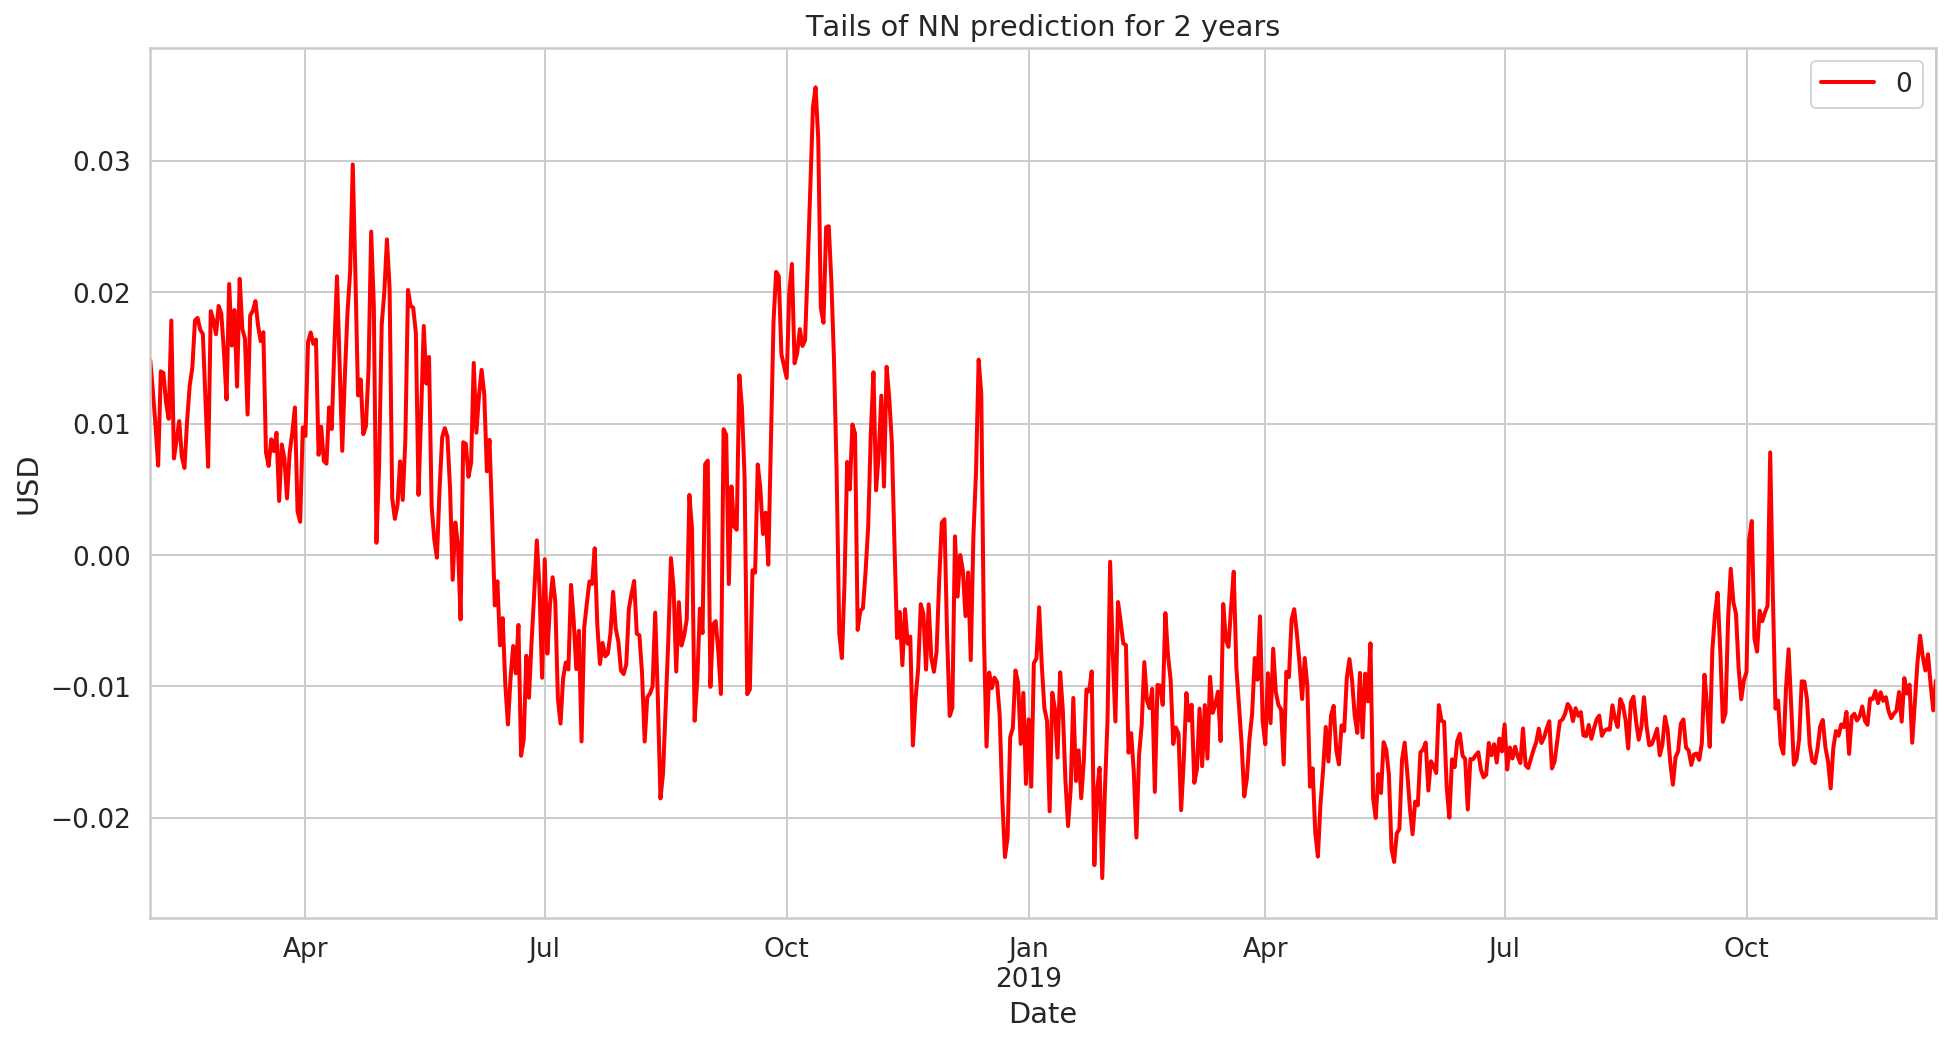

In [394]:
(df_test - df_pred).plot(c='#FF0000', linewidth = 2)

plt.title('Tails of NN prediction for 2 years')
plt.ylabel('USD')
plt.xlabel('Date');

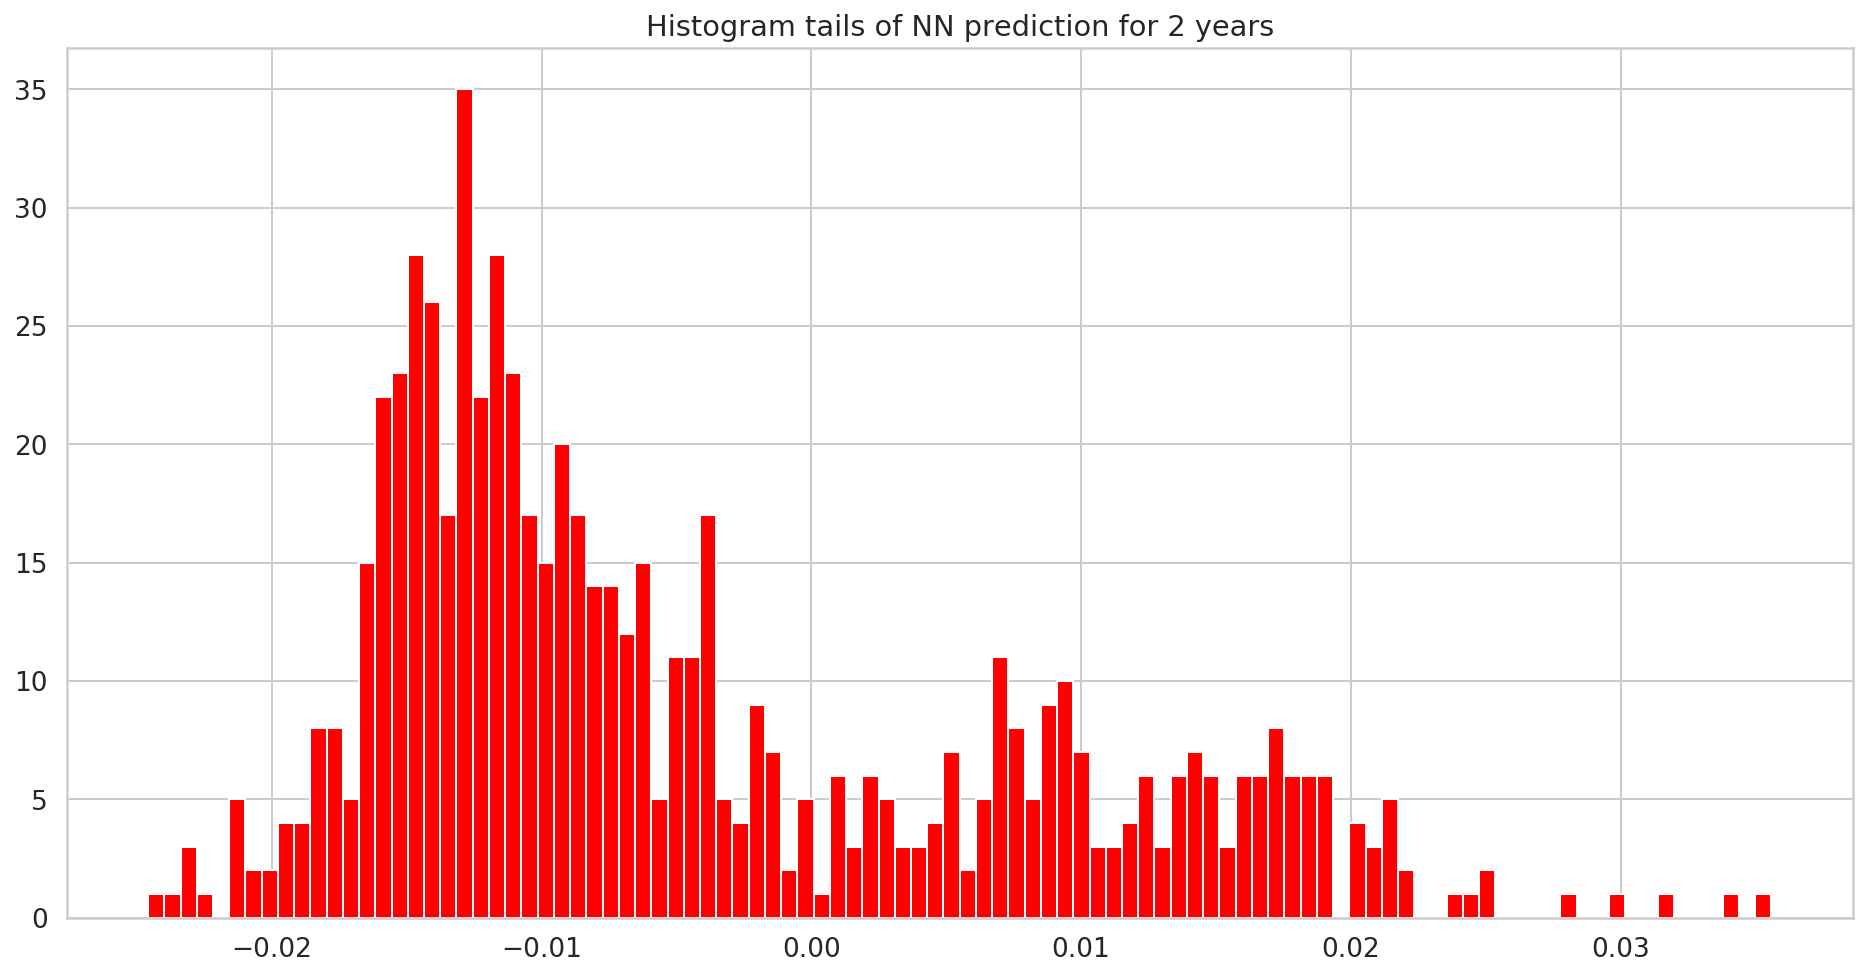

In [375]:
(df_test - df_pred).hist(color = '#FF0000', bins=100)

plt.title('Histogram tails of NN prediction for 2 years');

In [378]:
results = pd.DataFrame(data = [[r2_sarimax_aic, rmse_sarimax_aic, mae_sarimax_aic],\
                               [r2_sarimax_r2, rmse_sarimax_r2, mae_sarimax_r2],\
                               [r2_prophet, rmse_prophet, mae_prophet],\
                               [r2_regr, rmse_regr, mae_regr]],\
                     columns = ['r2', 'rmse', 'mae'], \
                       index = ['sarimax_aic', 'sarimax_r2', 'prophet', 'nn'])

In [379]:
results

r2      rmse       mae
sarimax_aic -1.996130  0.105051  0.086186
sarimax_r2   0.885462  0.020540  0.016293
prophet     -0.138154  0.082140  0.064208
nn           0.954638  0.012634  0.011379

In [381]:
SARIMAX_r2_feature = SARIMAX_r2.forecast(steps=365*5)

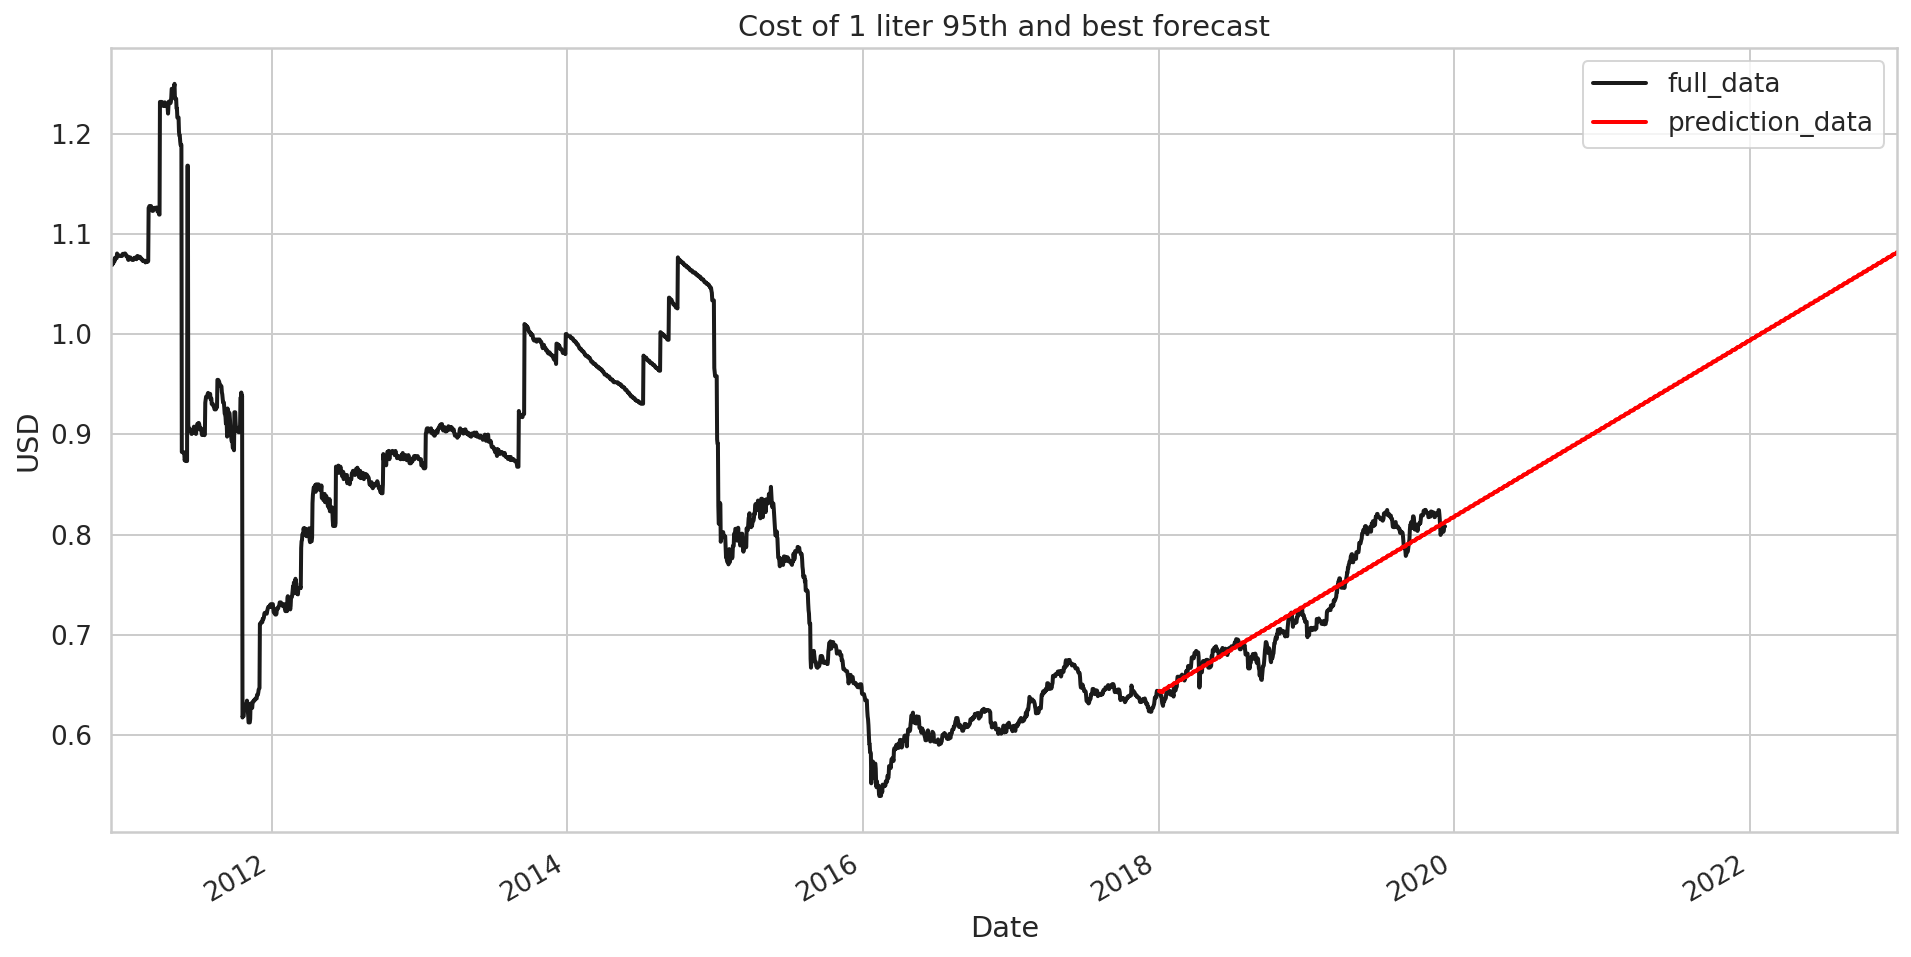

In [392]:
data['USD_by_liter'].plot(c = 'k', linewidth = 2)
SARIMAX_r2_feature.plot(c = '#FF0000', linewidth = 2)

plt.title('Сost of 1 liter 95th and best forecast')
plt.ylabel('USD')
plt.legend(['full_data','prediction_data']);

In [ ]:
'''
 ВЫВОДЫ:

 1) fbProphet - быстрая в плане вхождения и применения, легкая в настройках библиотека;
 2) Семейство моделей ARMA требует глубоких знаний для настройки модели, ресурсоемка в подборе параметров, 
    в данной работе лучшая модель sarimax, судя по остаткам, требует доработки.
    Варианты доработки:
    - изменить дату разбиения на test/train c 01.01.2018
    - избавиться от не значащих слоев
    - еще более точно подобрать коэффициенты модели
    - отдельно кроссвалидировать Х
 3) Нейросеть не смотря на лучшие прогнозы на тестовом наборе не способна на долгосрочные прогнозы
    Варианты доработки модели:
    - изменить дату разбиения на test/train c 01.01.2018
    - уточнить пораметры регуляризации и Dropout
    - придумать и внедрить в модель дополнительный механизм сглаживания для прогнозирования "за горизонт"
 4) У прогнозирования нестационарных рядов с меняющимся трендом и без ярко-выраженной сезонности 
    на кроткосрочный период привилегия у нейросетей, на долгосрочный период - моделей семейства ARMA
'''
